In [1]:
# Importing Python modules
from error_reduction_rate.err import err
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from time import perf_counter
from loguru import logger
import os
import mat73
from bispectrum_real_data_analysis.scripts.utils import seconds_to_formatted_time
import matplotlib 
from numpy.linalg import inv
from high_order_spectra_analysis.hosa.hosa import Tdhosa, tdqs
from pathos.multiprocessing import ProcessingPool as Pool
import pickle
import plotly
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [2]:
fontsize = 30
matplotlib.rc('xtick', labelsize=fontsize) 
matplotlib.rc('ytick', labelsize=fontsize) 
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['axes.labelsize'] = fontsize
plt.rcParams['axes.titlesize'] = fontsize
plt.rcParams.update({'font.size': fontsize})

%matplotlib inline

In [3]:
id_file: str = "train_freezing"

In [4]:
zoom: bool = True

# ----------------------------------------------------------
lim: tuple[float, float] = (4, 15)*zoom or None

logger.info(f"zoom: {zoom}")
logger.info(f"Limits: {lim}")

2023-09-07 15:42:59.346 | INFO     | __main__:<module>:6 - zoom: True
2023-09-07 15:42:59.347 | INFO     | __main__:<module>:7 - Limits: (4, 15)


In [5]:
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ticks = np.sort(np.append(np.linspace((lim or [4, 60])[0], (lim or [4, 60])[1], 2 if zoom else 4), [53.71]))
labels = np.round(ticks, 2)

# Methods

In [6]:
def decimate(
    data: pd.DataFrame, 
    desired_frequency_sampling: float, 
    FrequencySampling: float | None = None, 
    filter_antialiasing: bool = True, 
    time: np.ndarray | None = None,
    columns_to_exclude: list | None = None
):
        
    if FrequencySampling is None:
        if time is None:
            time = data.Time.to_numpy()
        TimeSampling = round(np.mean(time[1:] - time[:-1]), 6)
        FrequencySampling = 1.0/TimeSampling
    else:
        TimeSampling = 1.0/FrequencySampling
        
    logger.info(f"The time sampling is {TimeSampling} seconds and the frequency is "
        f"{FrequencySampling/float(1000**(FrequencySampling<=1000))} {'k'*bool(FrequencySampling>=1000)}Hz")

    newTimeSampling = 1.0/desired_frequency_sampling
    decimation_rate = np.ceil(newTimeSampling/TimeSampling).astype(int)
    logger.info(f"The data will be decimated by the rate 1:{decimation_rate}")

    if filter:
        if columns_to_exclude:
            matrix = data.loc[:, ~data.columns.isin(columns_to_exclude)].to_numpy()
        else:
            matrix = data.to_numpy()
        decimated_matrix = signal.decimate(matrix, decimation_rate, axis=0, ftype='fir', zero_phase=True)
        new_data = data.copy()[::decimation_rate]
        if columns_to_exclude:
            new_data.loc[:, ~data.columns.isin(columns_to_exclude)] = decimated_matrix
        else:
            new_data.iloc[:] = decimated_matrix
    else:
        new_data = data[::decimation_rate]

    TimeSampling = TimeSampling*decimation_rate
    
    FrequencySampling = 1.0/TimeSampling
    logger.info(f"The new time sampling is {np.round(TimeSampling, 5)} s and the new frequency is "
    f"{FrequencySampling/float(1000**(FrequencySampling>=1000))} {'k'*bool(FrequencySampling>=1000)}Hz")
    
    return new_data, TimeSampling, FrequencySampling

In [7]:
# Method to extract events from dataframe

def select_event_window(
    df: pd.DataFrame, 
    event_name: str, 
    samples_before: int = 0, 
    samples_after: int = 0,
    freezing: bool = False
) -> pd.DataFrame:
    """
    Method to extract the slice of the dataframe which contais the event, with some data before and after, 
    given number of samples to add to the begin and end, respectively.
    """
    if not freezing:
        window_index = np.argwhere(df.event.to_numpy() == event_name).flatten()
    else:
        window_index = np.argwhere(df.freezing.to_numpy() == event_name).flatten()
    begin_index = window_index[0] - samples_before
    end_index = window_index[-1] + samples_after
    return df[begin_index:end_index]

In [8]:
def moving_average(x, N):
    return np.convolve(x, np.ones(N), 'same') / N

In [9]:
def get_events(data, threshold, window_size, time_sampling):
    
    x = data.CS_modulating.to_numpy()
    time = data.Time.to_numpy()
    N = len(x)
    index = np.arange(N)
    plt.figure(figsize=(16,14))
    plt.subplot(321)
    plt.plot(index, x)
    plt.ylabel("x")

    x = x - np.mean(x[:10])
    plt.subplot(322)
    plt.plot(index, x)
    plt.ylabel("$x - \overline{x}$")

    x = x**2
    plt.subplot(323)
    plt.plot(index, x)
    
    plt.ylabel("$(x - \overline{x})^2$")

    x = moving_average(x, window_size)
    plt.subplot(324)
    plt.plot(index, x)
    plt.axhline(threshold, color="red", label="threshold")
    plt.legend(loc='upper right')
    plt.ylabel("$\dfrac{1}{k} \sum _{i=n-k+1}^{n}(x - \overline{x})_i^2$")

    x[x>threshold] = 1
    x[x<threshold] = 0

    plt.subplot(325)
    plt.plot(index, x)
    plt.ylabel("threshold($\dfrac{1}{k} \sum _{i=n-k+1}^{n}(x - \overline{x})_i^2$)")

    indices = index[np.append(False, x[1:] - x[:-1]) != 0]

    for event, s, e in zip(range(1, 6), indices[0::2], indices[1::2]):
        print(f"\nEvent: {event}")
        print(f"index start: {s}\nindex end: {e}") 
        print(f"time start: {time[s]}\ntime end: {time[e]}")
        print(f"time duration: {(e-s)*time_sampling}")

    print(f"\nlen(indices) = {len(indices)}")

    data = data.assign(event=np.empty(len(data), dtype=str))
    data.loc[:, "event"] = "base"

    for i, event in zip(range(0, len(indices), 2), np.arange(1, 6)):
        start = indices[i]
        end = indices[i+1]
        data.loc[start:end, "event"] = f"event_{event}"

    data.event.unique()

    plt.subplot(326)
    for event in data.event.unique():
        plt.plot(data.loc[data.event==event, "Time"], data.loc[data.event==event, "CS_modulating"], label=event)

    plt.legend(loc="center left")
    plt.ylabel("events")
    
    plt.show()
    return data

In [10]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    return signal.butter(order, [lowcut, highcut], fs=fs, btype='band')

In [11]:
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5, filtfilt=False):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    if filtfilt:
        return signal.filtfilt(b, a, data)
    return signal.lfilter(b, a, data)

In [12]:
def filter_function(column): 
    return butter_bandpass_filter(
        data=column, 
        lowcut=low_cut_hz, 
        highcut=high_cut_hz,
        fs=fs,
        order=filter_order, 
        filtfilt=True
    )

In [13]:
# Método que calcula a FFT unilateral e retorna um plot,
# o vetor de frequências em Hertz e os ganhos
def fft(x, fs):
    N = len(x)
    FFT = np.fft.fft(x)
    P2 = np.abs(FFT/N)
    intensity = P2[0:N//2]
    intensity[1:-1] = 2*intensity[1:-1]
    frequency = fs*np.arange(0,N//2)/N
    angle = np.angle(FFT)
    angle = angle[0:N//2]
    return frequency, intensity, angle

In [14]:
class TDQS(Tdhosa):

    def run_td4spectrum(self, signal_dict: np.ndarray | pd.Series): 
        event, signal = list(signal_dict.items())[0]
        return {
            event: self.run_tdqs(
                signal
            )
        }

In [15]:
def get_time_given_time_sampling_and_N(time_sampling: float, N: int, start_in_seconds: float = 0):
    end_time = (N)*time_sampling + start_in_seconds
    return np.arange(start_in_seconds, end_time, time_sampling)

# Loading files

In [16]:
BASE_PATH = "/home/matheus/Documents/repositories/bispectrum_real_data_analysis/bispectrum_real_data_analysis/data/"    

In [17]:
list_of_files: list[str] = os.listdir(BASE_PATH)
[(i, file) for i, file in enumerate(list_of_files)]

[(0, 'rats'),
 (1, '1_Etapa_paper_Simoes-20230328T020230Z-001.zip'),
 (2, 'only_rats'),
 (3, '.gitkeep'),
 (4, 'F04__PT_data.mat'),
 (5, 'rats_simoes'),
 (6, 'F04__T_data.mat'),
 (7, 'html')]

In [18]:
file_to_load: str = "F04__PT_data.mat"
file_to_load

'F04__PT_data.mat'

In [19]:
# Loading and creating the data matrix

logger.info(f"Loading .mat file...")

complete_path: str = f"{BASE_PATH}/{file_to_load}"

complete_data = mat73.loadmat(complete_path)

data = complete_data["data"]["data"][0]

FrequencySampling = complete_data["parameters"]["srate"].item()
TimeSampling = 1.0/FrequencySampling

logger.info(f"Time Sampling: {TimeSampling}")

logger.info(f"Frequency Sampling: {FrequencySampling}")

logger.success("Loaded!")

2023-09-07 15:42:59.507 | INFO     | __main__:<module>:3 - Loading .mat file...
2023-09-07 15:43:00.158 | INFO     | __main__:<module>:14 - Time Sampling: 0.001
2023-09-07 15:43:00.158 | INFO     | __main__:<module>:16 - Frequency Sampling: 1000.0
2023-09-07 15:43:00.158 | SUCCESS  | __main__:<module>:18 - Loaded!


In [20]:
all_columns = [
    "CS_modulating",
    "mPFC_pre_limbic_1",
    "mPFC_pre_limbic_2",
    "mPFC_infra_limbic_1" ,
    "mPFC_infra_limbic_2" ,
    "Hippocampus_CA1" ,
    "Hippocampus_MOL_layer" ,
    "Hippocampus_GD_1" ,
    "Hippocampus_GD_2" ,
    "Amygdala_lateral_1" ,
    "Amygdala_lateral_2" ,
    "Amygdala_basolateral_1",
    "Amygdala_basolateral_2" ,
    "Inferior_colliculus_1" ,
    "Inferior_colliculus_2" ,
    "Inferior_colliculus_3" ,
    "Inferior_colliculus_4"
]

columns = [
    "CS_modulating",
    "mPFC_pre_limbic_2",
    "mPFC_infra_limbic_1" ,
    "Amygdala_lateral_1" ,
    "Amygdala_basolateral_2" ,
    "Inferior_colliculus_3"
]


In [21]:
data = pd.DataFrame(data=data.T, columns=all_columns)

In [22]:
data = data.loc[:, columns]

In [23]:
time = get_time_given_time_sampling_and_N(
    time_sampling=TimeSampling,
    N=data.shape[0],
    start_in_seconds=0
)

data = data.assign(Time=time)

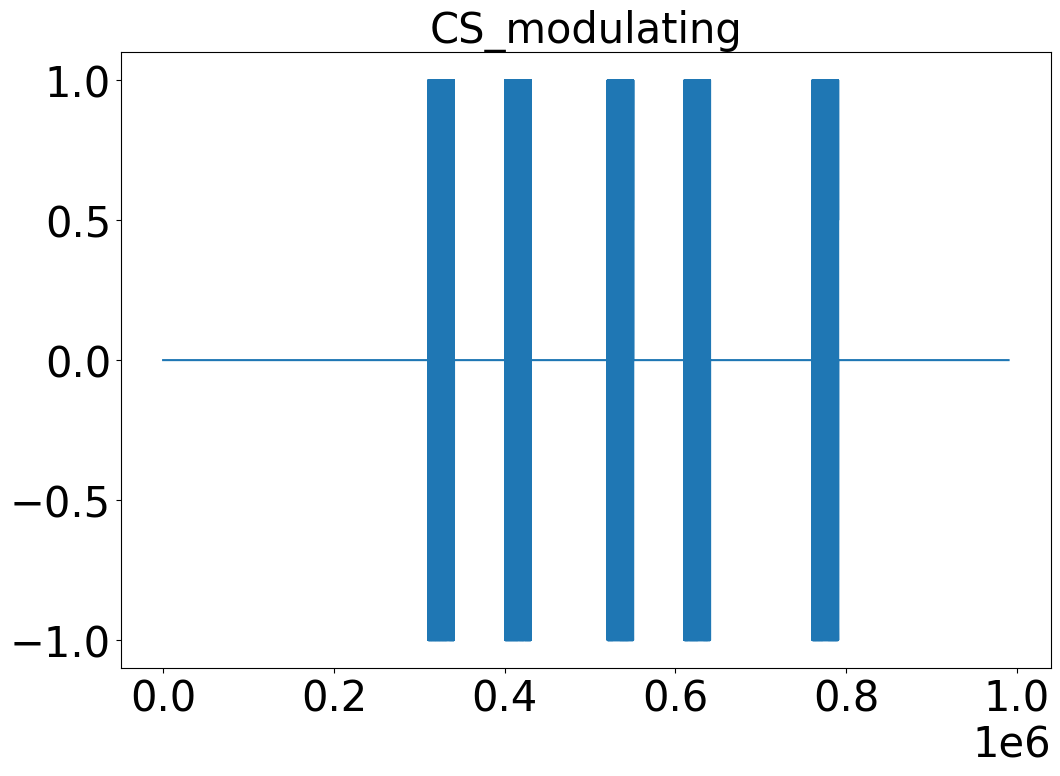

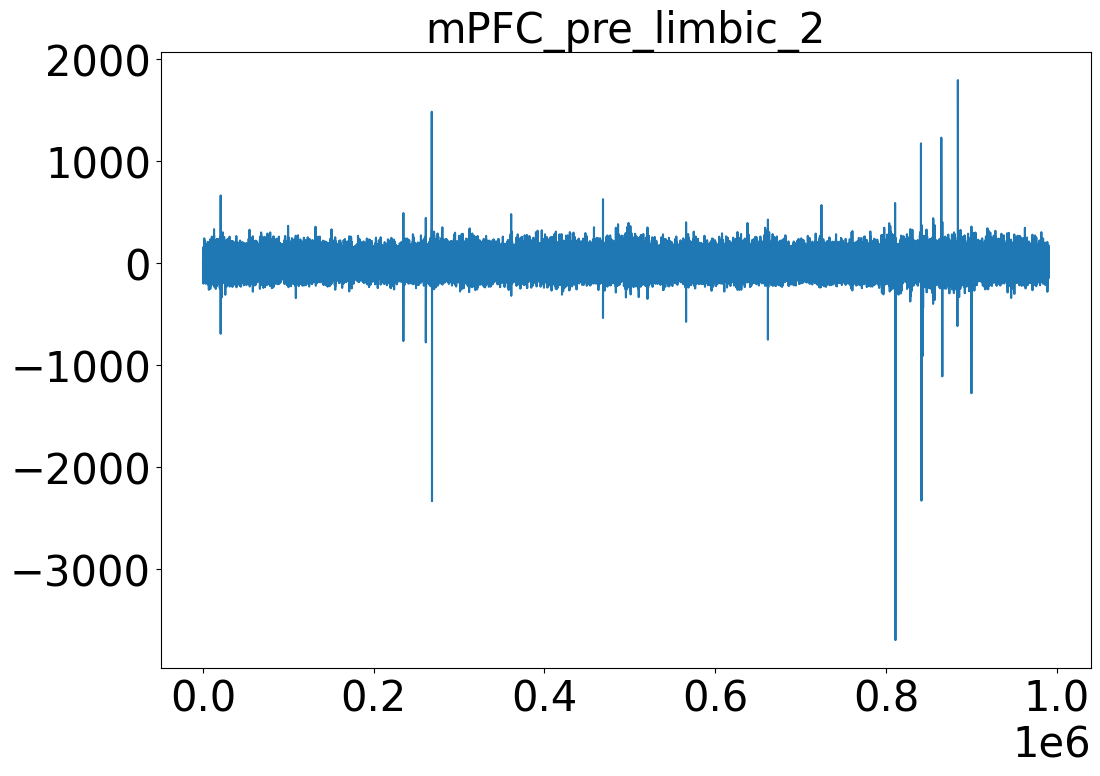

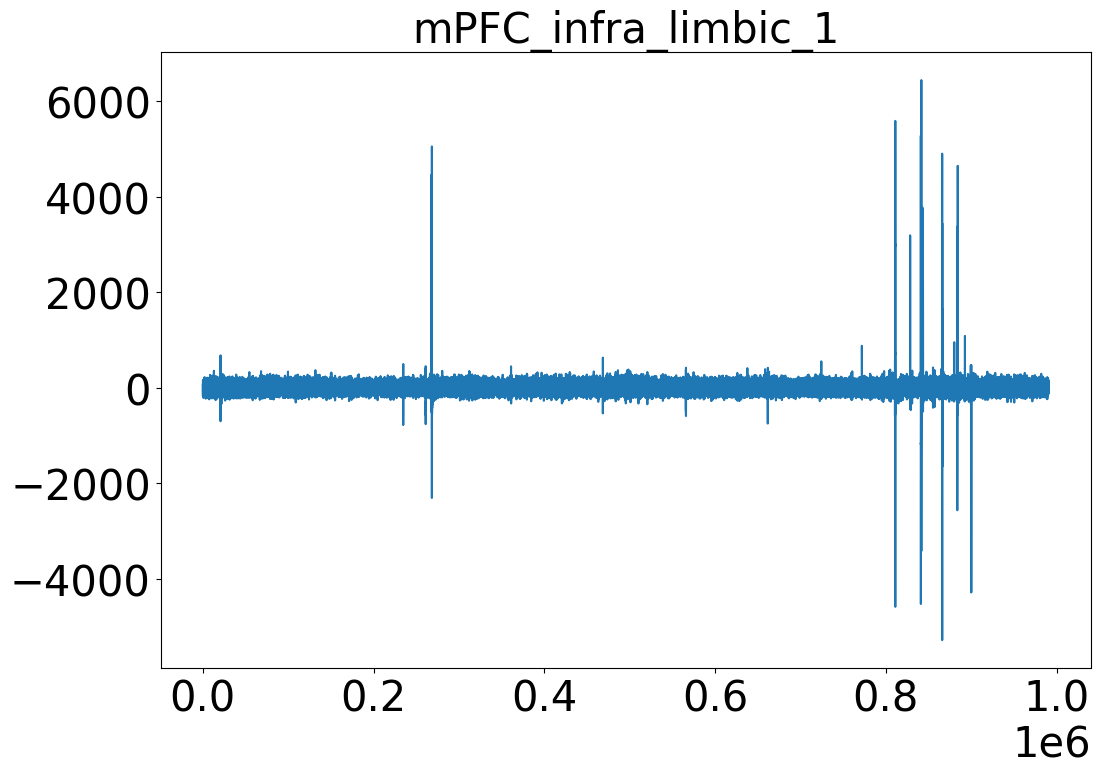

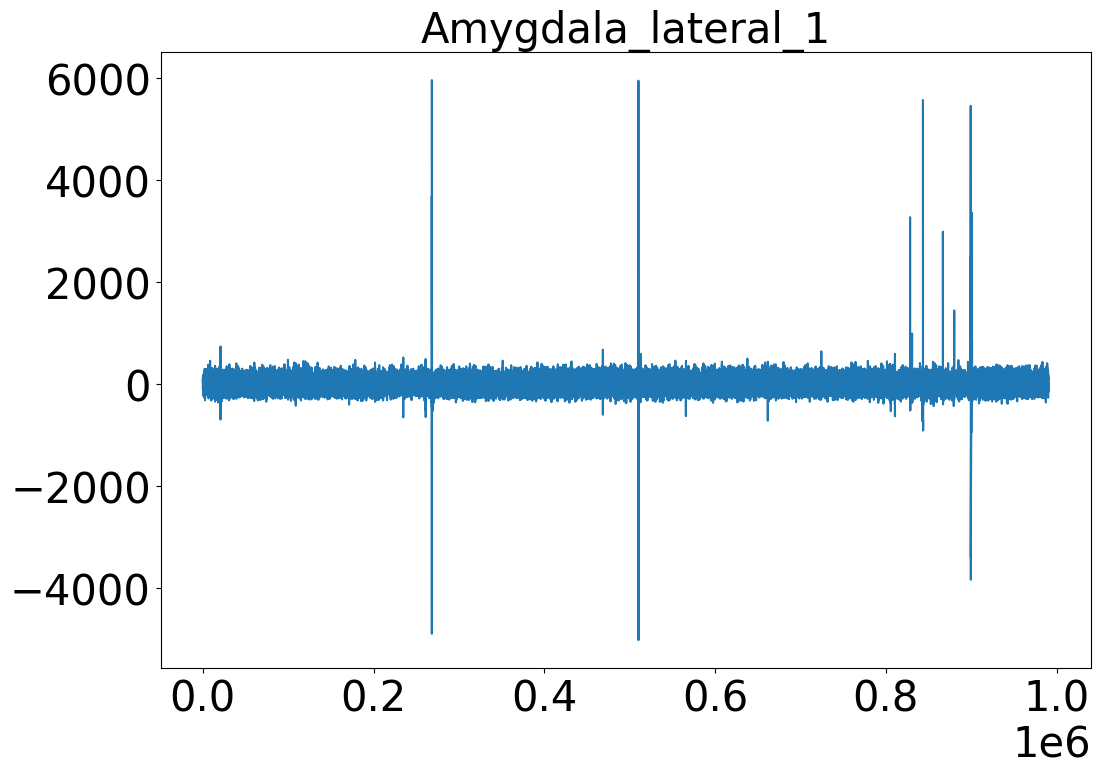

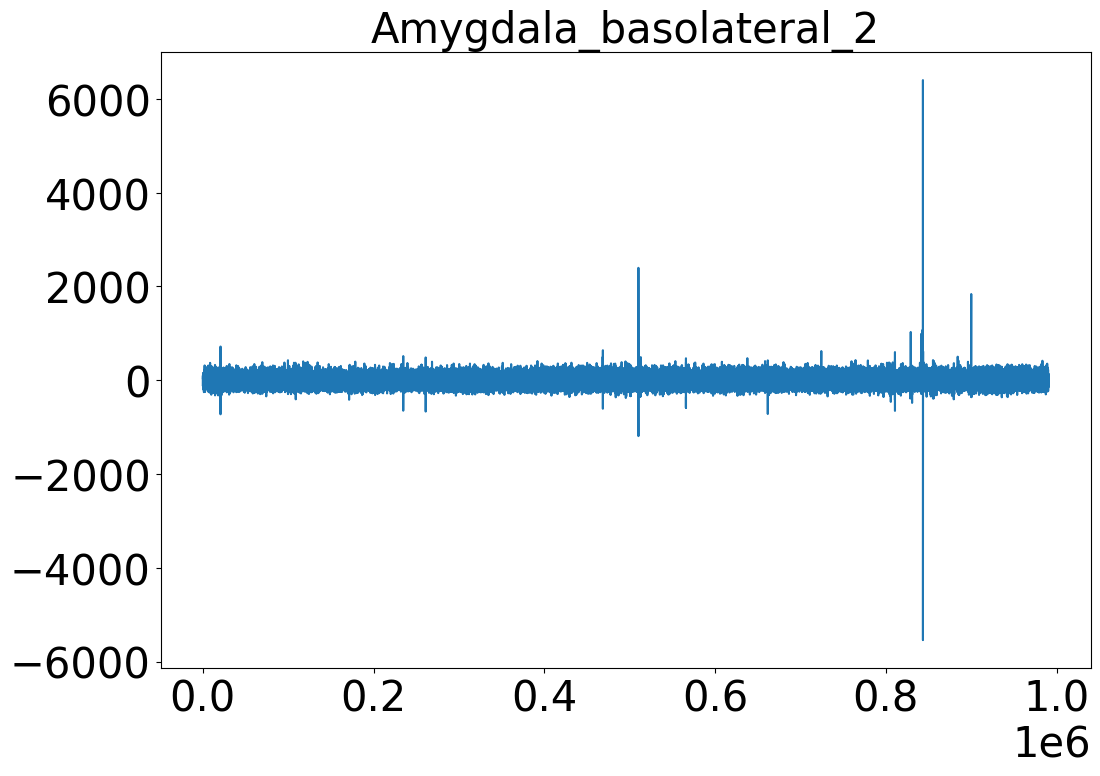

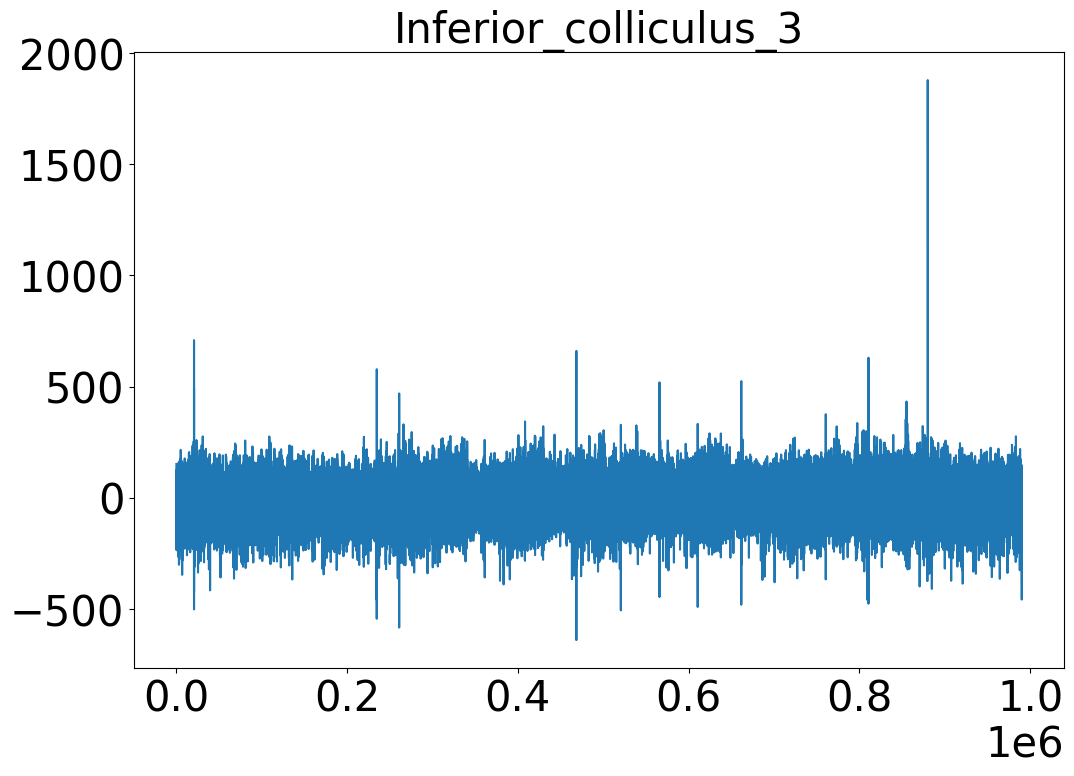

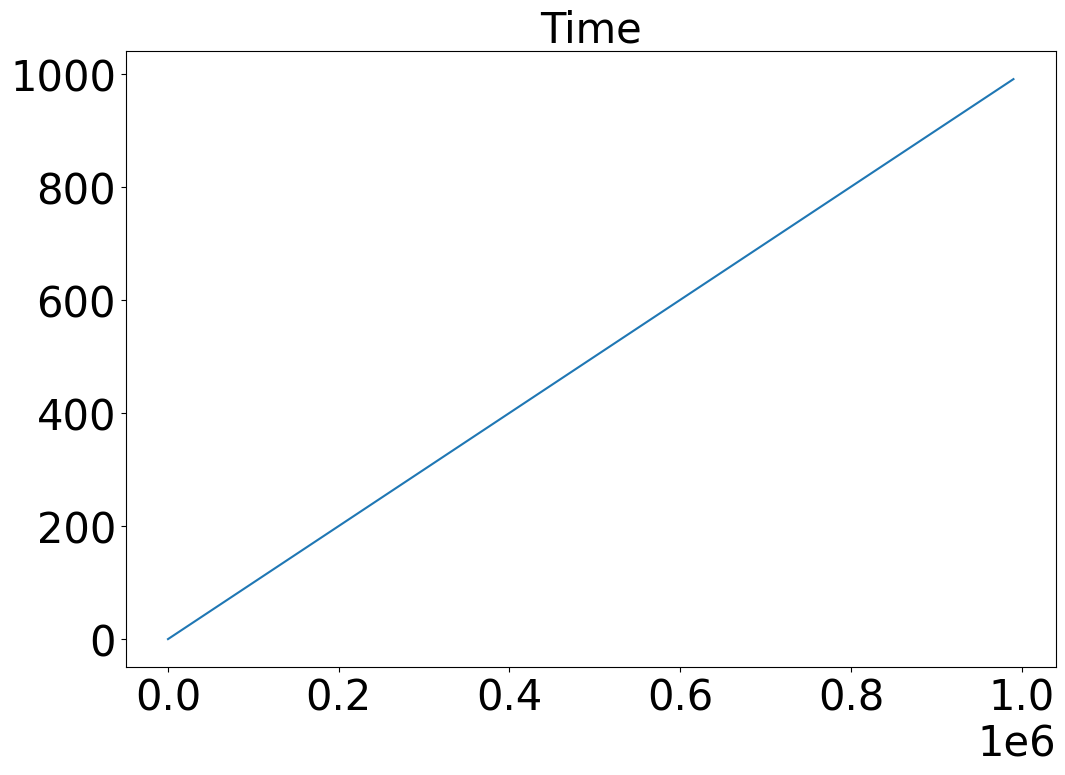

In [24]:
for column in data.columns:
    data.loc[:, column].plot()
    plt.title(column)
    plt.show()


Event: 1
index start: 310565
index end: 340646
time start: 310.565
time end: 340.646
time duration: 30.081

Event: 2
index start: 400566
index end: 430647
time start: 400.56600000000003
time end: 430.647
time duration: 30.081

Event: 3
index start: 520567
index end: 550648
time start: 520.567
time end: 550.648
time duration: 30.081

Event: 4
index start: 610568
index end: 640649
time start: 610.568
time end: 640.649
time duration: 30.081

Event: 5
index start: 760568
index end: 790649
time start: 760.568
time end: 790.649
time duration: 30.081

len(indices) = 10


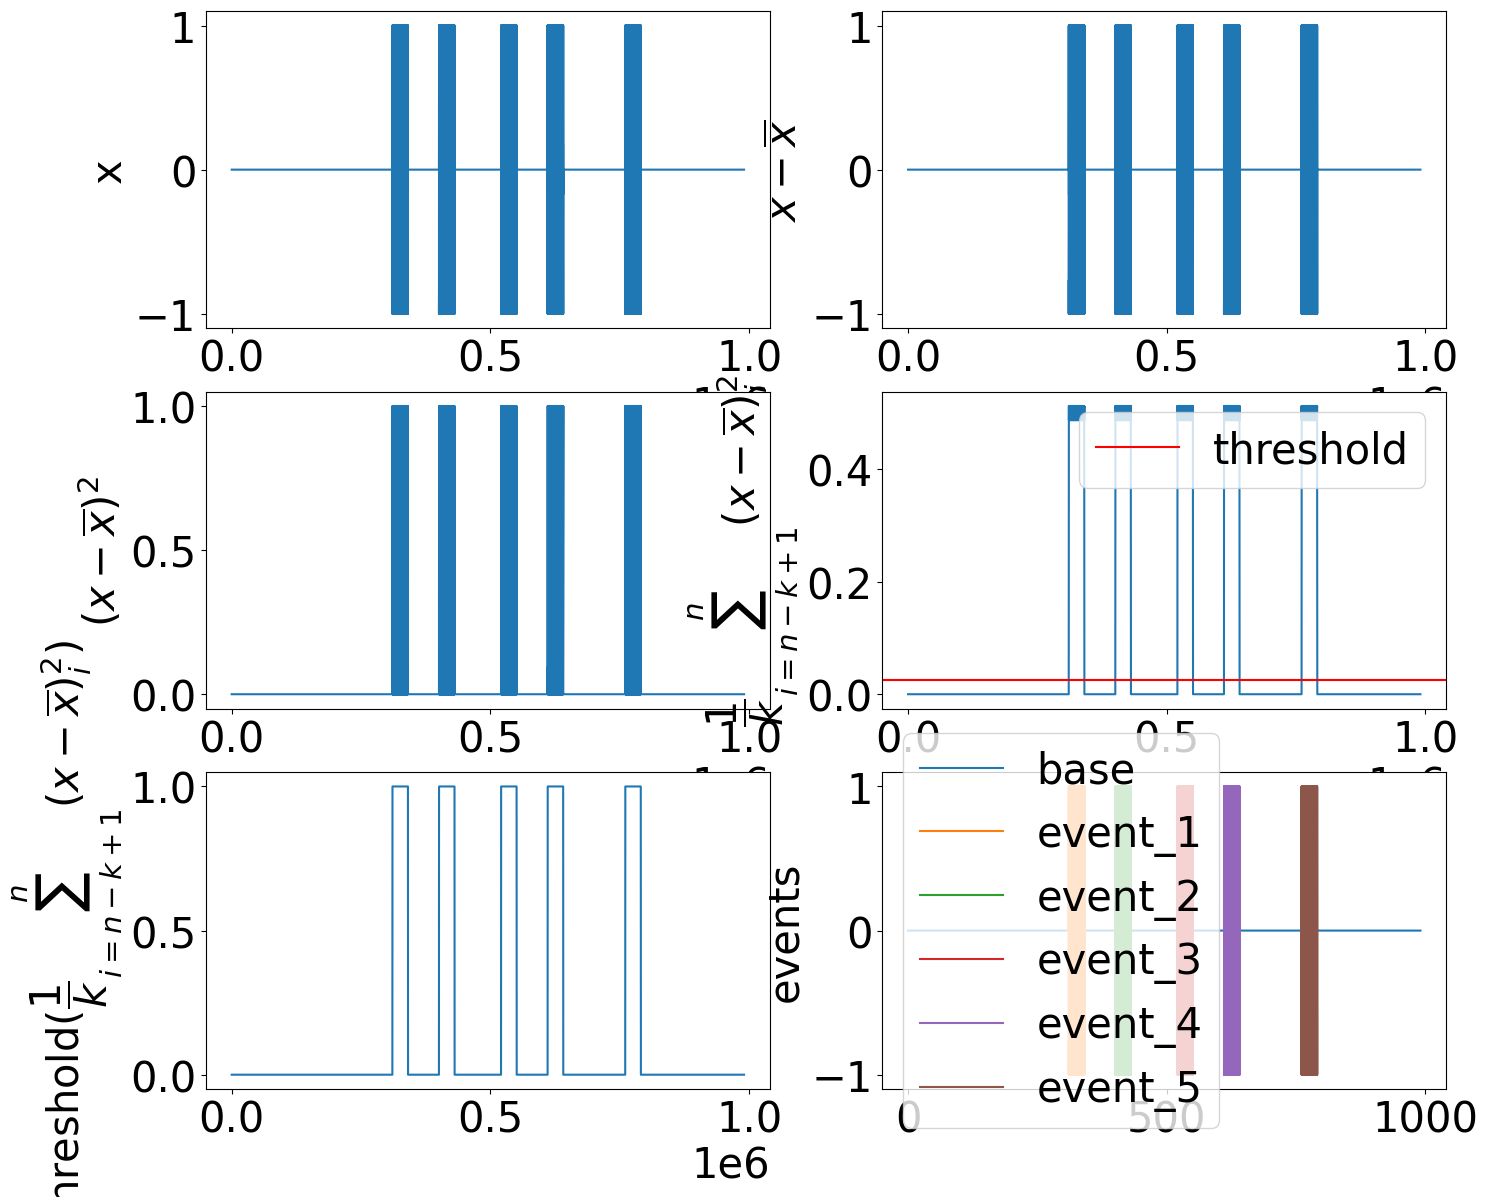

In [25]:
threshold = 0.025
window_size = 100

data = get_events(
    data=data, 
    threshold=threshold, 
    window_size=window_size, 
    time_sampling=TimeSampling
)

In [26]:
base_interval_1: tuple[int, float, float] = (1, 260.0, 290.0)
base_interval_2: tuple[int, float, float] = (2, 480.0, 510.0)
base_interval_3: tuple[int, float, float] = (3, 810.0, 840.0)
    
for base_index, time_start, time_end in [base_interval_1, base_interval_2, base_interval_3]:
    data.loc[(data.Time >= time_start)&(data.Time <= time_end), "event"] = f"base_{base_index}"

In [27]:
data.head()

CS_modulating  mPFC_pre_limbic_2  mPFC_infra_limbic_1  Amygdala_lateral_1  \
0            0.0          37.298648            53.808822           52.651653   
1            0.0          24.648042            28.258616           67.595394   
2            0.0         -25.287153           -15.634174           38.627809   
3            0.0         -26.214741             2.599901           43.209880   
4            0.0           0.654156            25.463381           80.566398   

   Amygdala_basolateral_2  Inferior_colliculus_3   Time event  
0               43.101950             151.121921  0.000  base  
1               54.288636             117.804381  0.001  base  
2               26.147833              84.938906  0.002  base  
3               30.029931              25.648619  0.003  base  
4               65.044447              77.645042  0.004  base

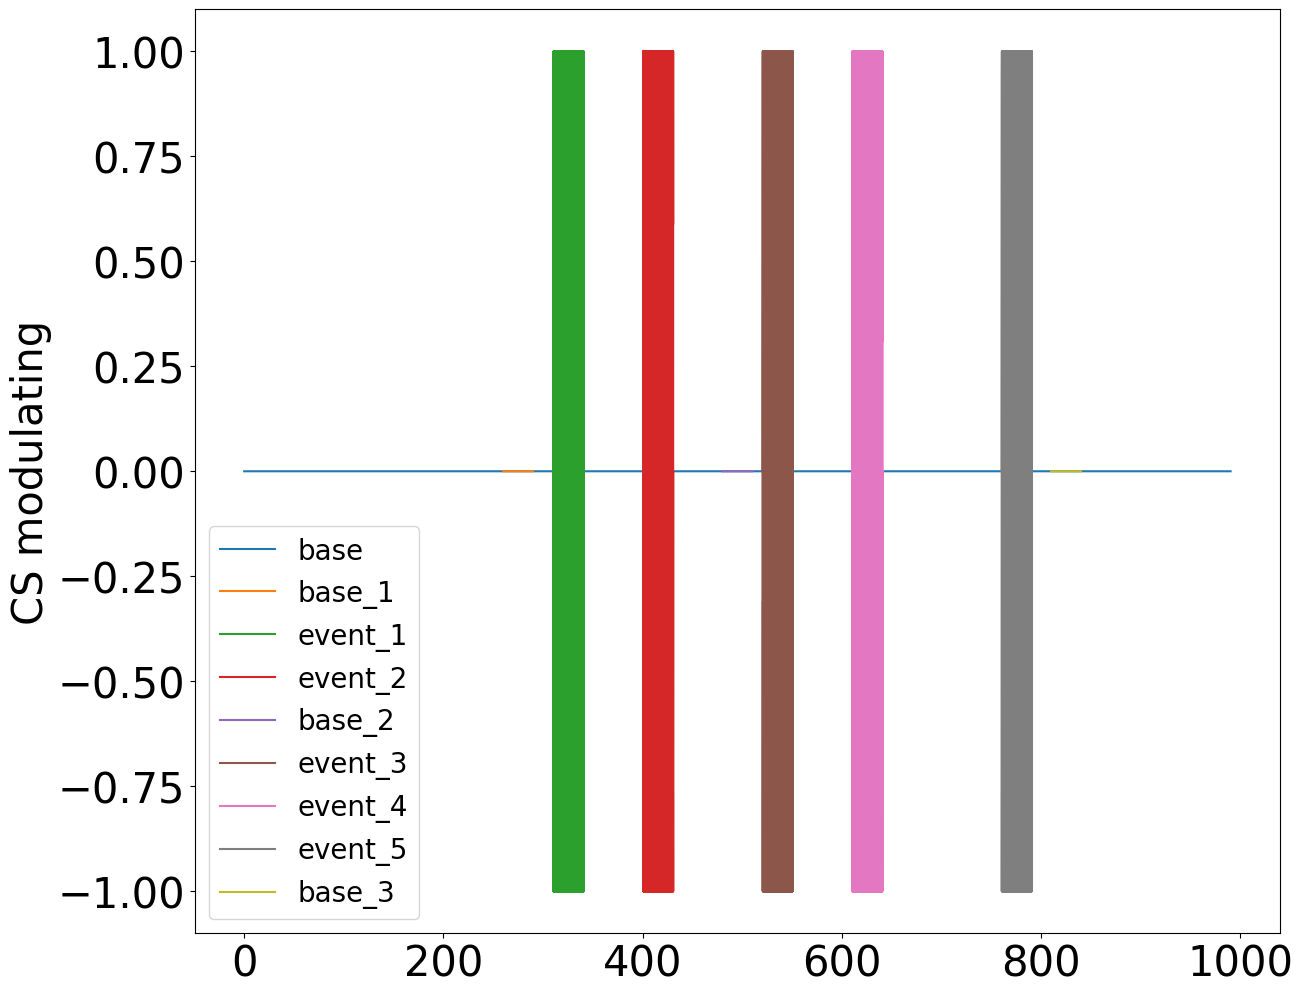

In [28]:
plt.figure(figsize=(14,12))

for event in data.event.unique():
    plt.plot(data.loc[data.event==event, "Time"], data.loc[data.event==event, "CS_modulating"], label=event)
plt.legend(loc='lower left', prop={'size': 20})
plt.ylabel("CS modulating")

plt.show()

# Data filtering

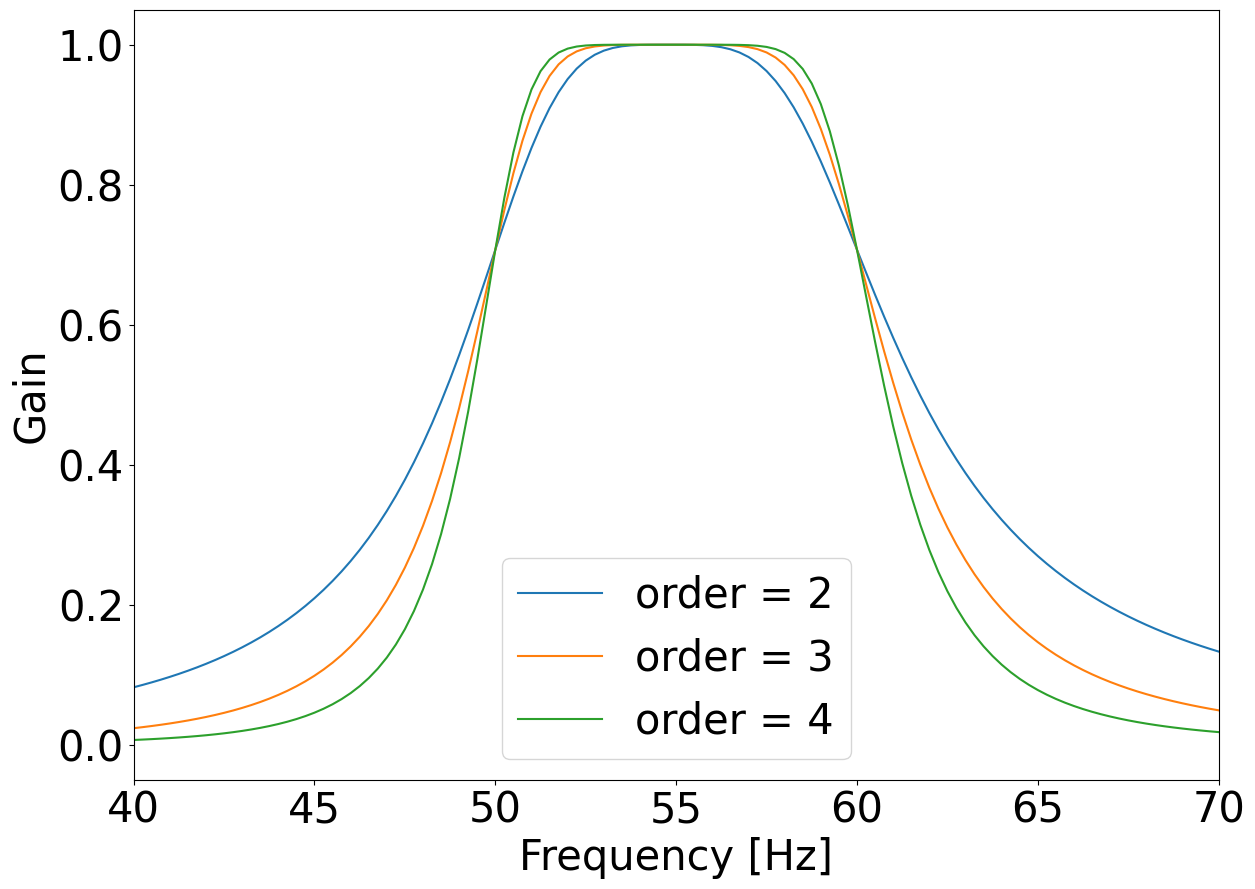

In [29]:
low_cut_hz = 50
high_cut_hz = 60
fs = 1.0/TimeSampling

plt.figure(figsize=(14,10))
plt.clf()

for order in range(2,5):
    b, a = butter_bandpass(low_cut_hz, high_cut_hz, fs, order=order)
    w, h = signal.freqz(b, a, fs=fs, worN=2000)
    plt.plot(w, abs(h), label="order = %d" % order)


plt.xlabel('Frequency [Hz]')
plt.ylabel('Gain')
plt.legend()
plt.xlim([low_cut_hz-10, high_cut_hz+10])
plt.show()

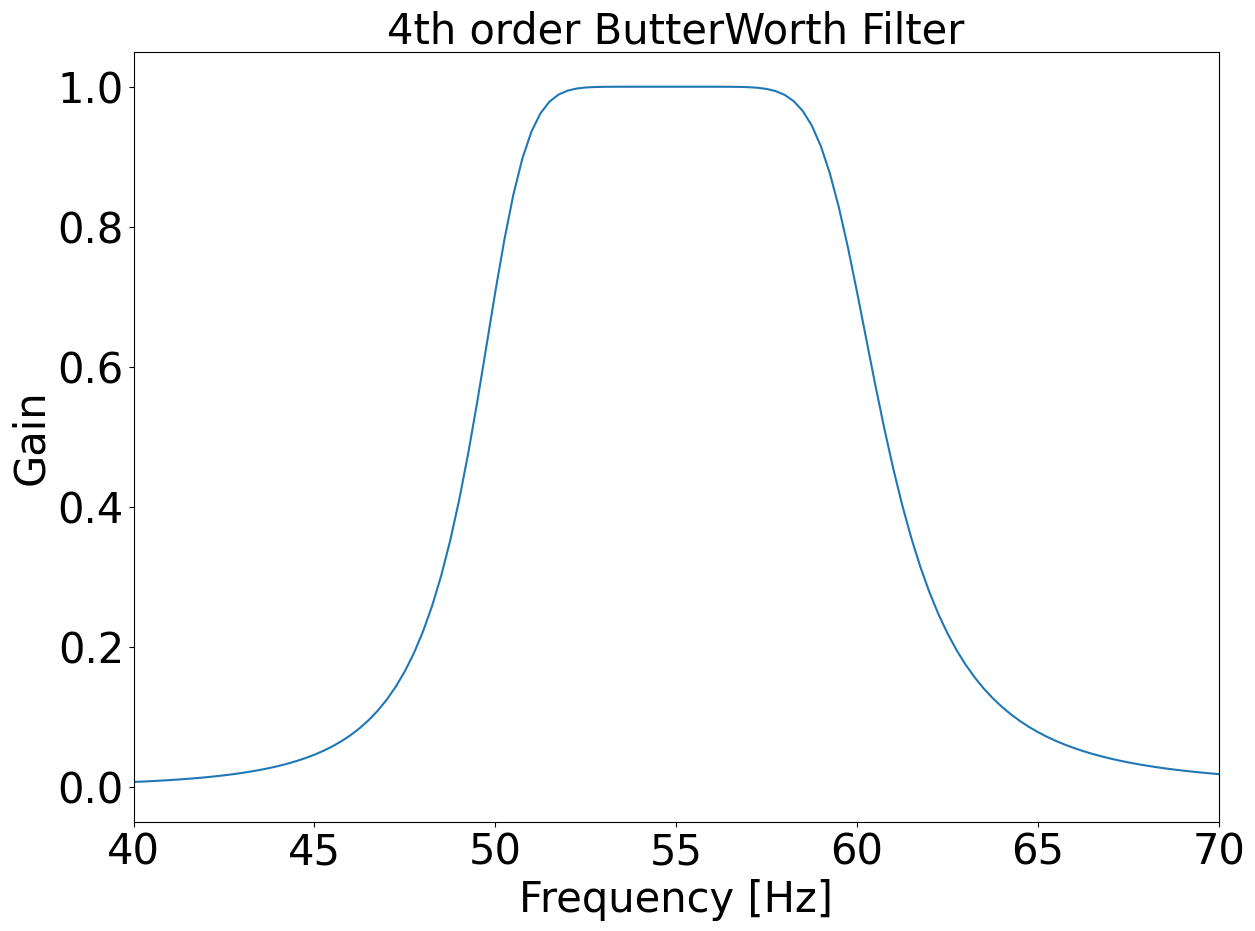

In [30]:
filter_order = 4
b, a = butter_bandpass(low_cut_hz, high_cut_hz, fs=fs, order=filter_order)

plt.figure(figsize=(14,10))
plt.clf()
w, h = signal.freqz(b, a, fs=fs, worN=2000)
plt.plot(w, abs(h))
plt.xlabel('Frequency [Hz]')
plt.ylabel('Gain')
plt.xlim([low_cut_hz-10, high_cut_hz+10])
plt.title(f"{filter_order}th order ButterWorth Filter")
plt.show()

## Filtering using filtfilt to avoid phase changes

## Filtering data

In [31]:
data.columns

Index(['CS_modulating', 'mPFC_pre_limbic_2', 'mPFC_infra_limbic_1',
       'Amygdala_lateral_1', 'Amygdala_basolateral_2', 'Inferior_colliculus_3',
       'Time', 'event'],
      dtype='object')

In [32]:
for column in columns[1:]:
    logger.info(f"Filtering the {column}")
    data = data.assign(
        **{
            f"filtered_{column}": filter_function(data.loc[:, column].to_numpy())
        }
    )
    
logger.success(f"Done filtering!")

2023-09-07 15:43:04.993 | INFO     | __main__:<module>:2 - Filtering the mPFC_pre_limbic_2
2023-09-07 15:43:05.042 | INFO     | __main__:<module>:2 - Filtering the mPFC_infra_limbic_1
2023-09-07 15:43:05.109 | INFO     | __main__:<module>:2 - Filtering the Amygdala_lateral_1
2023-09-07 15:43:05.175 | INFO     | __main__:<module>:2 - Filtering the Amygdala_basolateral_2
2023-09-07 15:43:05.254 | INFO     | __main__:<module>:2 - Filtering the Inferior_colliculus_3
2023-09-07 15:43:05.331 | SUCCESS  | __main__:<module>:9 - Done filtering!


## Decimation

In [33]:
desired_frequency_sampling = 250

data, TimeSampling, FrequencySampling = decimate(
    data=data, 
    desired_frequency_sampling=desired_frequency_sampling,
    filter_antialiasing=True,
    columns_to_exclude=["Time", "event"]
)

data_backup = data

2023-09-07 15:43:05.336 | INFO     | __main__:decimate:18 - The time sampling is 0.001 seconds and the frequency is 1.0 kHz
2023-09-07 15:43:05.336 | INFO     | __main__:decimate:23 - The data will be decimated by the rate 1:4
2023-09-07 15:43:05.694 | INFO     | __main__:decimate:42 - The new time sampling is 0.004 s and the new frequency is 250.0 Hz


In [34]:
data = data_backup

# Selecting Data to model - EVENT 1

In [35]:
event_number = 1
id_results: str = f"event_{event_number}"

event_data = select_event_window(
    df=data_backup, 
    event_name=f"event_{event_number}", 
    samples_before=0, 
    samples_after=0,
    freezing=False
)

In [36]:
frequency_array = np.arange(start=4, stop=60, step=0.01)

TDQS_PARAMETERS = {
    "frequency_array": frequency_array,
    "phase_step": 0.01
}

tdqs_object = TDQS(
    frequency_sampling=FrequencySampling,
    frequency_array=TDQS_PARAMETERS.get("frequency_array"),
    fmin=TDQS_PARAMETERS.get("fmin"),
    fmax=TDQS_PARAMETERS.get("fmax"),
    freq_step=TDQS_PARAMETERS.get("freq_step"),
    phase_step=TDQS_PARAMETERS["phase_step"]
)

In [37]:
path_files = f'{os.getcwd()}/hosa_{id_file}_{id_results}.csv'
load_already_calculated: bool = os.path.isfile(path_files)
if load_already_calculated:
    logger.info("HOSA already calculated. Loading...")
    hosa_df = pd.read_csv(path_files)
    logger.success("HOSA loaded!")

else:
    logger.info("HOSA not calculated yet. Generating hosa...")
    logger.info(f"\nProcessing event {event_number}")

    spectrum_df_amps = pd.DataFrame()
    spectrum_df_phases = pd.DataFrame()

    bispectrum_df_amps = pd.DataFrame()
    bispectrum_df_phases = pd.DataFrame()

    trispectrum_df_amps = pd.DataFrame()
    trispectrum_df_phases = pd.DataFrame()

    quadrispectrum_df_amps = pd.DataFrame()
    quadrispectrum_df_phases = pd.DataFrame()

    hosa_df = pd.DataFrame()

    logger.info("Processing the tdqs... This may take a while...\n")
    start_time = perf_counter()

    # Process the tdbs for each channel, in parallel

    f = lambda x: tdqs_object.run_td4spectrum(x)
    channels_columns = columns[1:]

    with Pool() as pool:

        for result in pool.map(f, [{column: event_data.loc[: , column].to_numpy()} for column in channels_columns]):
            column, result_data = list(result.items())[0]
            (
                frequency_array, 
                spectrum, 
                phase_spectrum, 
                bispectrum, 
                phase_bispectrum, 
                trispectrum, 
                phase_trispectrum, 
                tetraspectrum, 
                phase_tetraspectrum
            ) = result_data

            if (
                "frequency" not in spectrum_df_amps.columns or 
                "frequency" not in bispectrum_df_amps.columns or
                "frequency" not in hosa_df
            ):
                spectrum_df_amps = spectrum_df_amps.assign(frequency=frequency_array)
                bispectrum_df_amps = bispectrum_df_amps.assign(frequency=frequency_array)
                hosa_df =hosa_df.assign(frequency=frequency_array)


            spectrum_df_amps = spectrum_df_amps.assign(**{f"tds_amp_{column}": spectrum})
            spectrum_df_phases = spectrum_df_phases.assign(**{f"tds_phase_{column}": phase_spectrum})

            bispectrum_df_amps = bispectrum_df_amps.assign(**{f"tdbs_amp_{column}": bispectrum})
            bispectrum_df_phases = bispectrum_df_phases.assign(**{f"tdbs_phase_{column}": phase_bispectrum})

            trispectrum_df_amps = bispectrum_df_amps.assign(**{f"tdts_amp_{column}": trispectrum})
            trispectrum_df_phases = bispectrum_df_phases.assign(**{f"tdts_phase_{column}": phase_trispectrum})

            quadrispectrum_df_amps = bispectrum_df_amps.assign(**{f"tdqs_amp_{column}": tetraspectrum})
            quadrispectrum_df_phases = bispectrum_df_phases.assign(**{f"tdqs_phase_{column}": phase_tetraspectrum})

            hosa_df = hosa_df.assign(**{f"tds_amp_{column}": spectrum})
            hosa_df = hosa_df.assign(**{f"tdbs_amp_{column}": bispectrum})
            hosa_df = hosa_df.assign(**{f"tdts_amp_{column}": trispectrum})
            hosa_df = hosa_df.assign(**{f"tdqs_amp_{column}": tetraspectrum})


    spectrum_df = pd.concat([spectrum_df_amps, spectrum_df_phases], axis=1)
    bispectrum_df = pd.concat([bispectrum_df_amps, bispectrum_df_phases], axis=1)
    trispectrum_df = pd.concat([trispectrum_df_amps, trispectrum_df_phases], axis=1)
    quadrispectrum_df = pd.concat([quadrispectrum_df_amps, quadrispectrum_df_phases], axis=1)

    hosa_df.to_csv(f'{os.getcwd()}/hosa_{id_file}_{id_results}.csv', index=False)

    end_time = perf_counter()

    logger.success(f"Done. Elapsed time: {seconds_to_formatted_time(end_time - start_time)}")

2023-09-07 15:43:05.741 | INFO     | __main__:<module>:4 - HOSA already calculated. Loading...
2023-09-07 15:43:05.761 | SUCCESS  | __main__:<module>:6 - HOSA loaded!


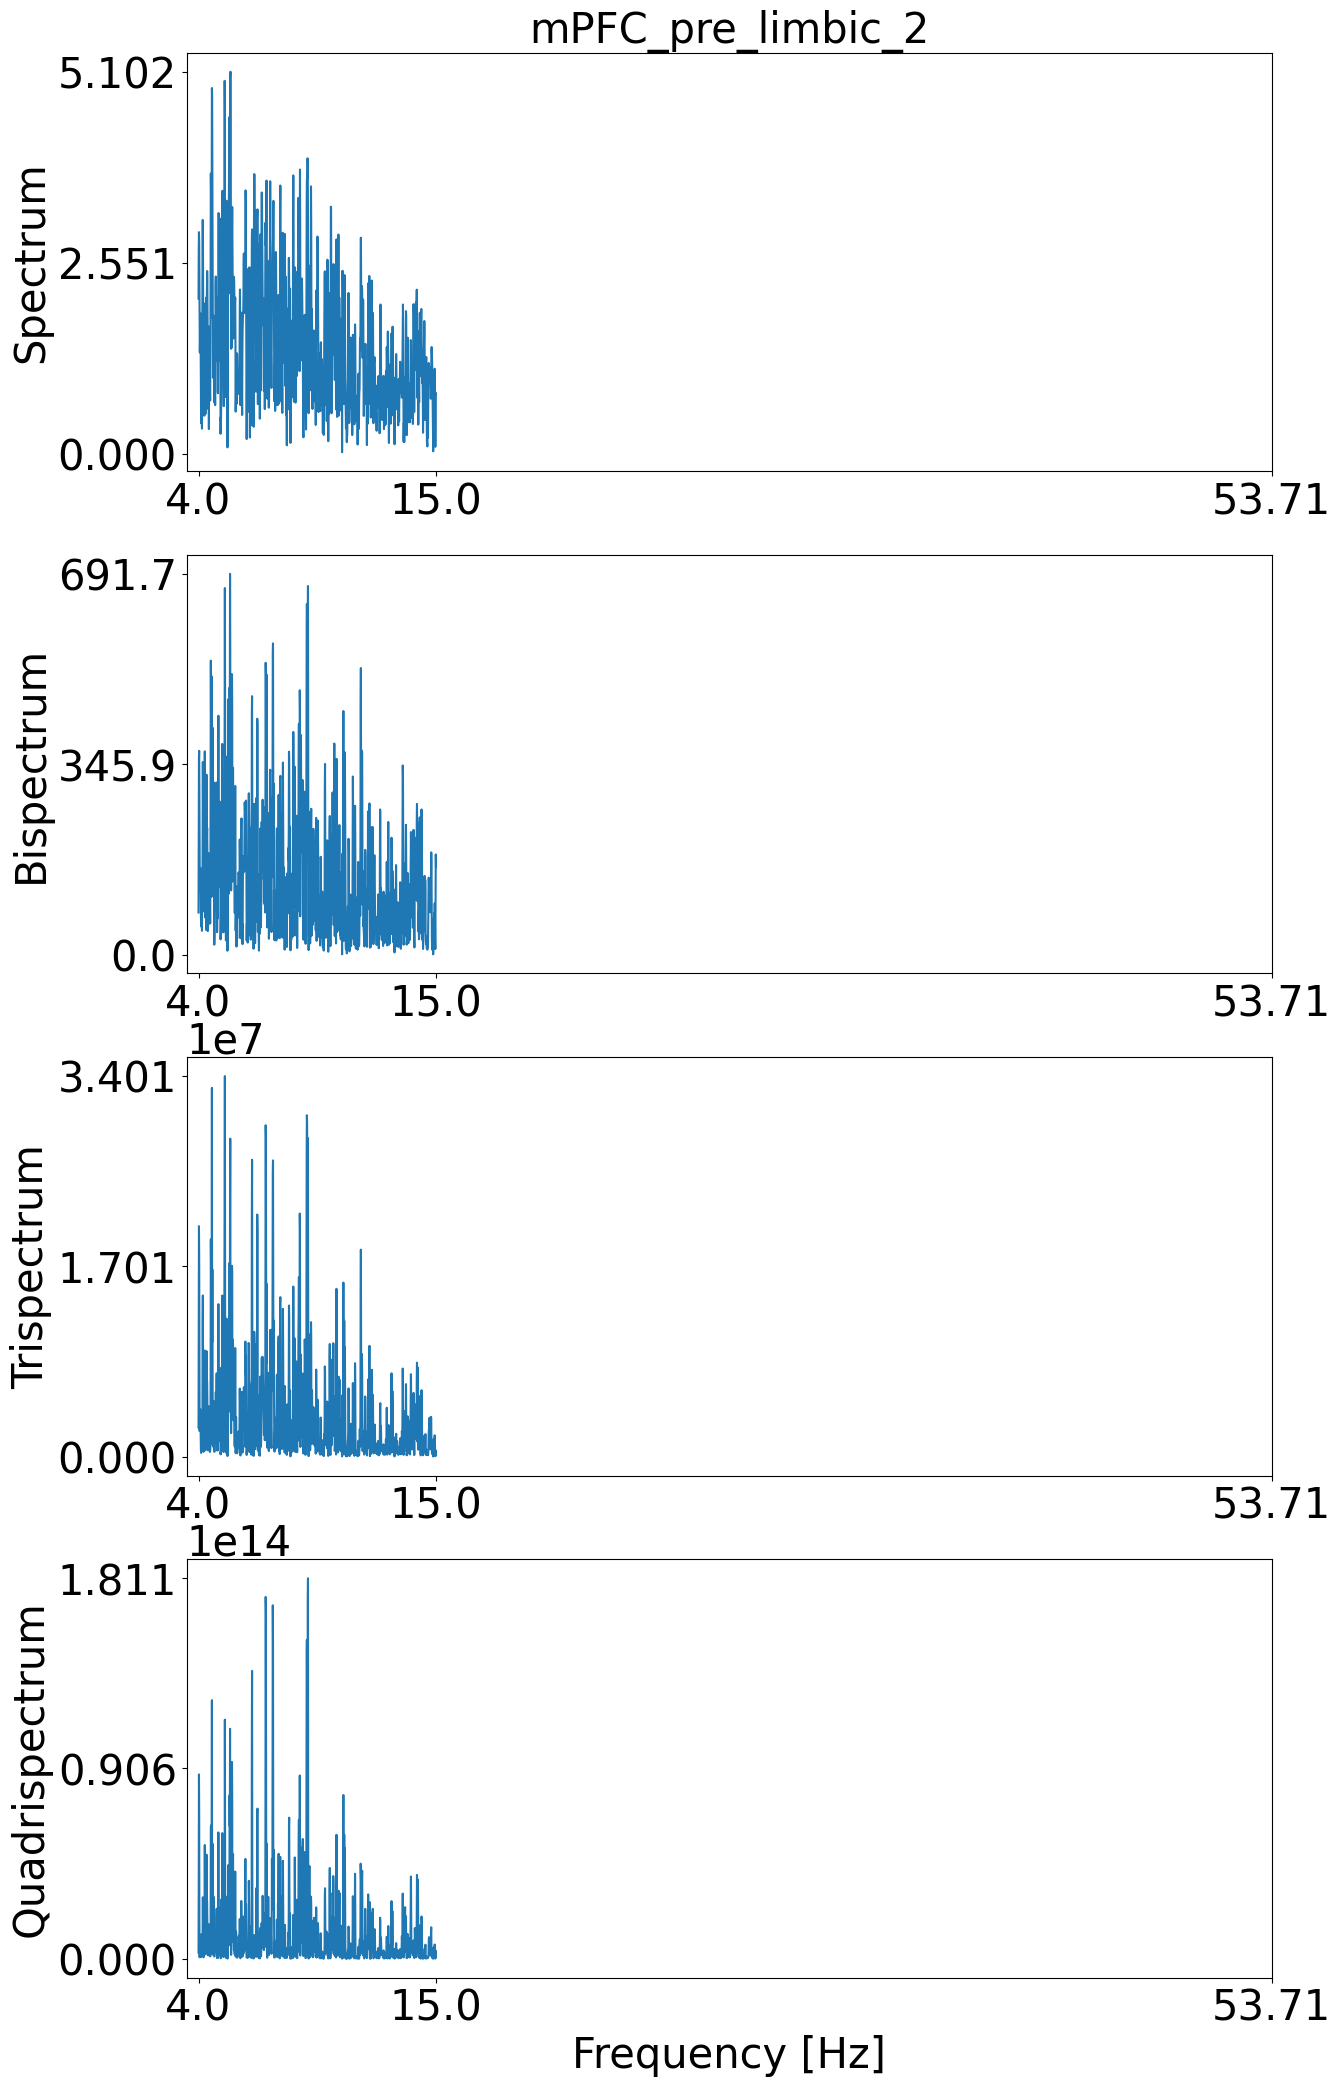

####################################################################################################


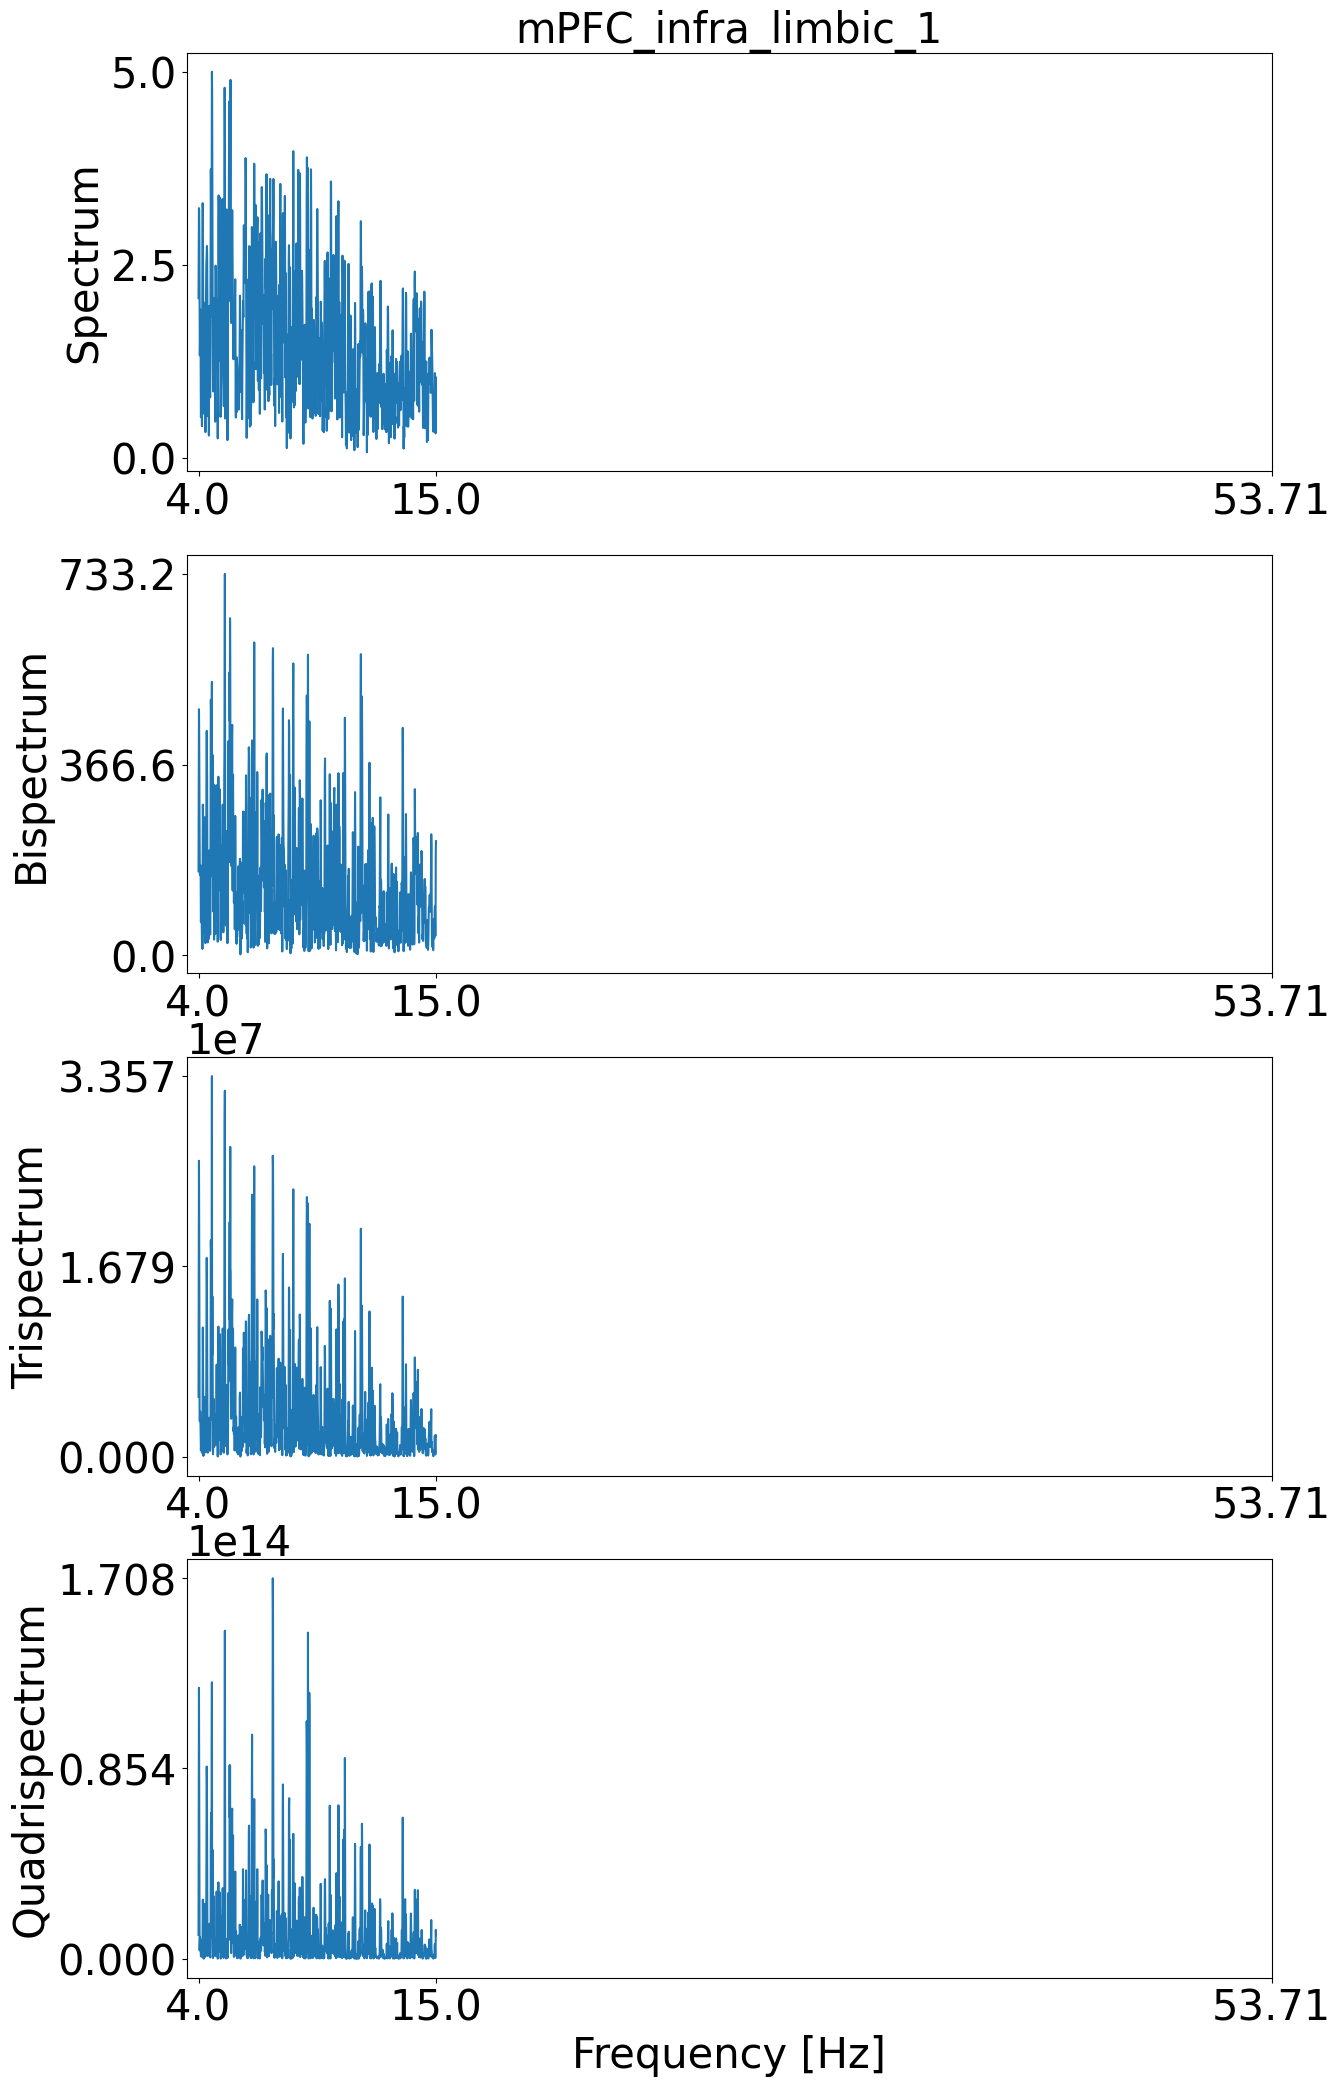

####################################################################################################


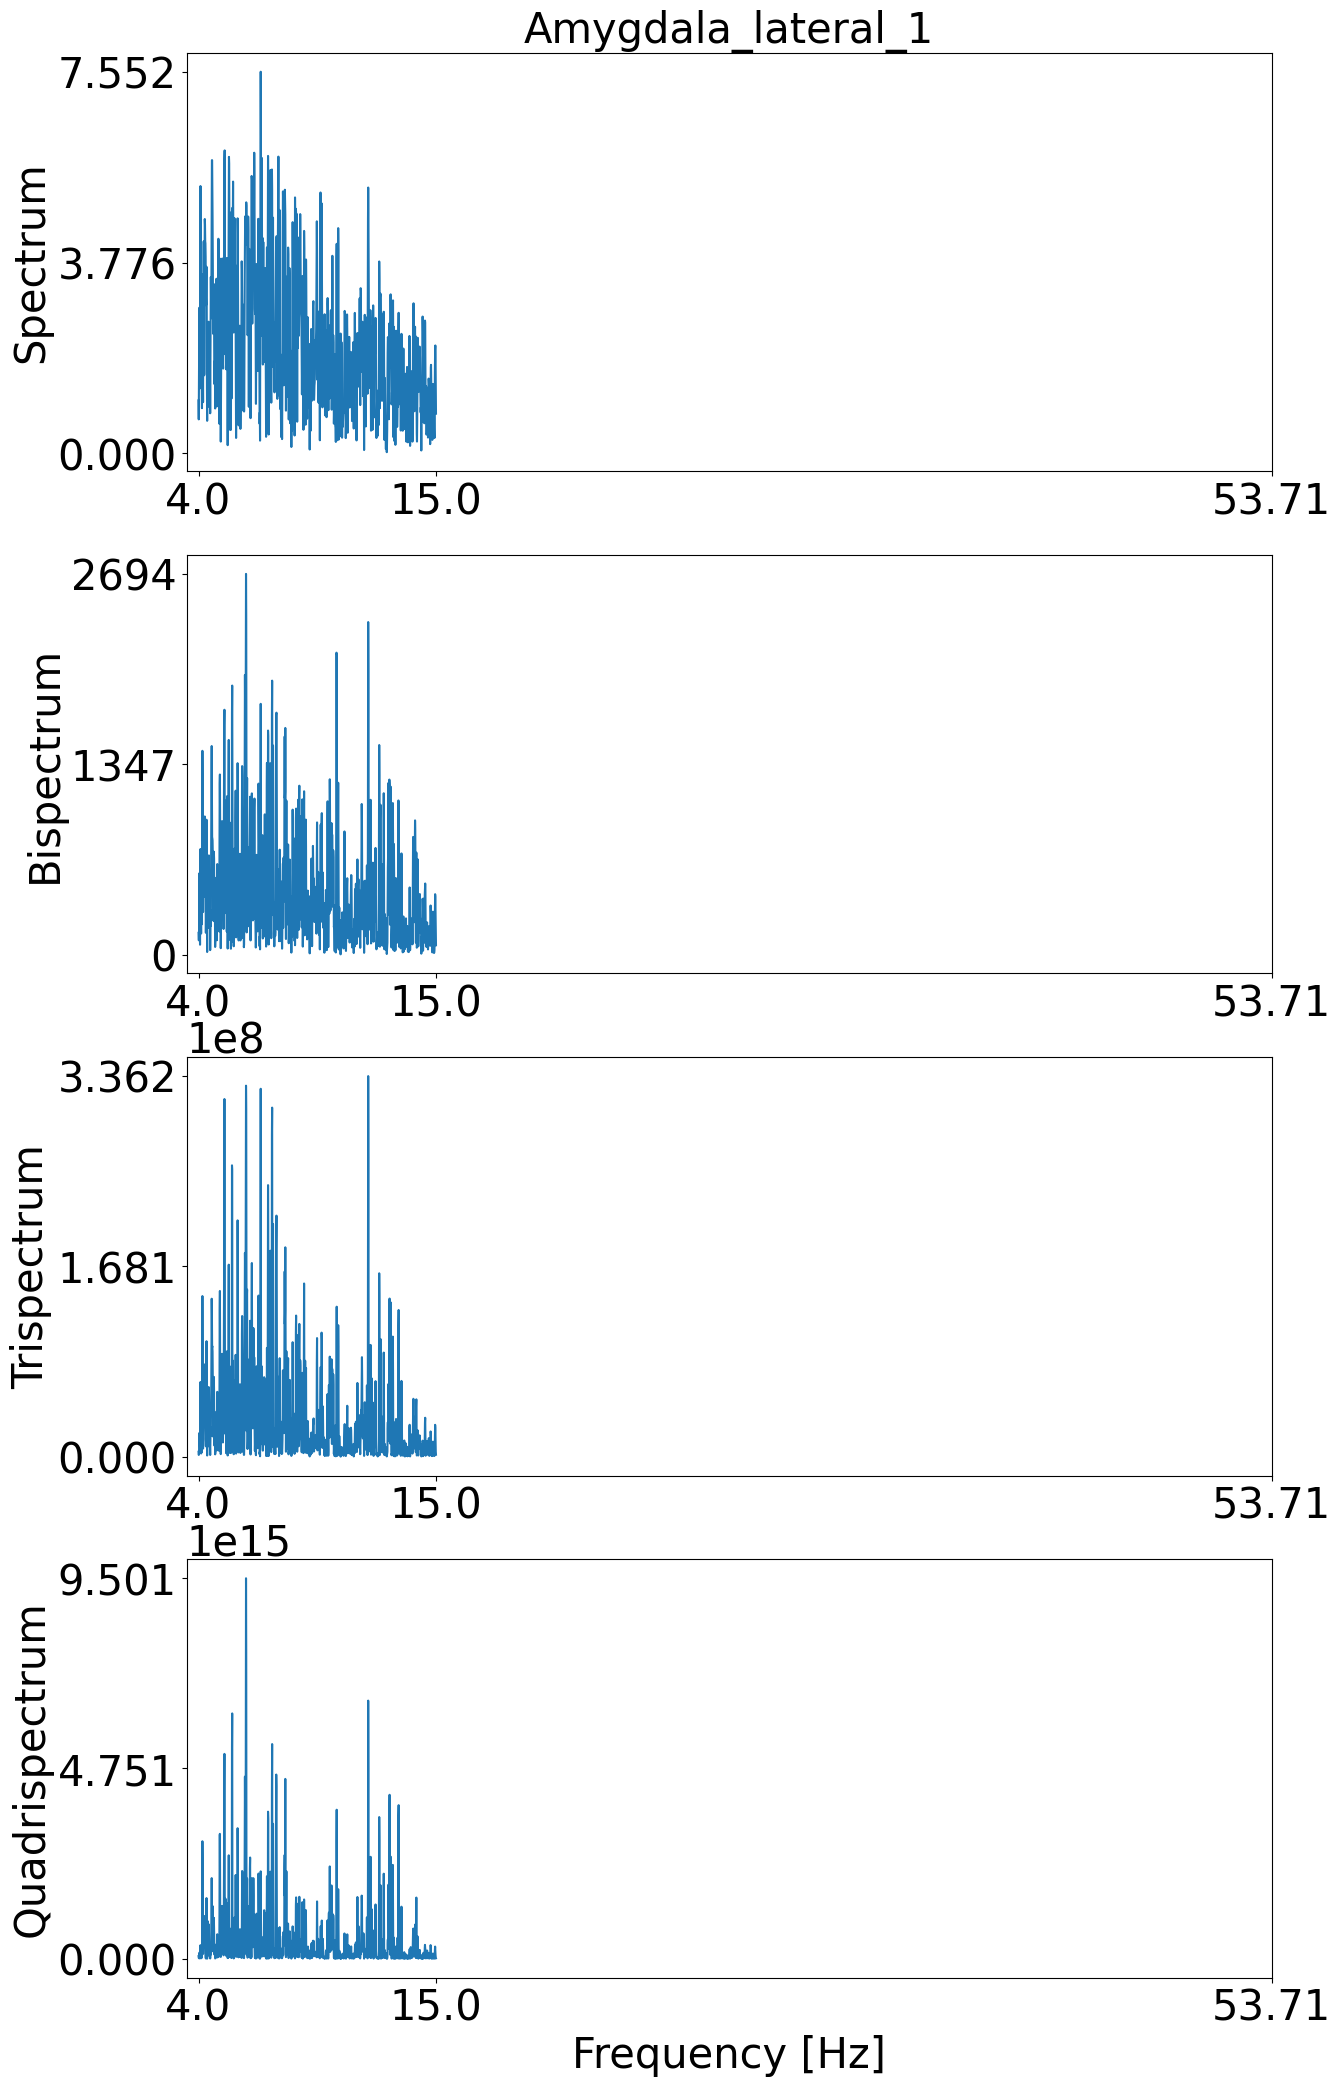

####################################################################################################


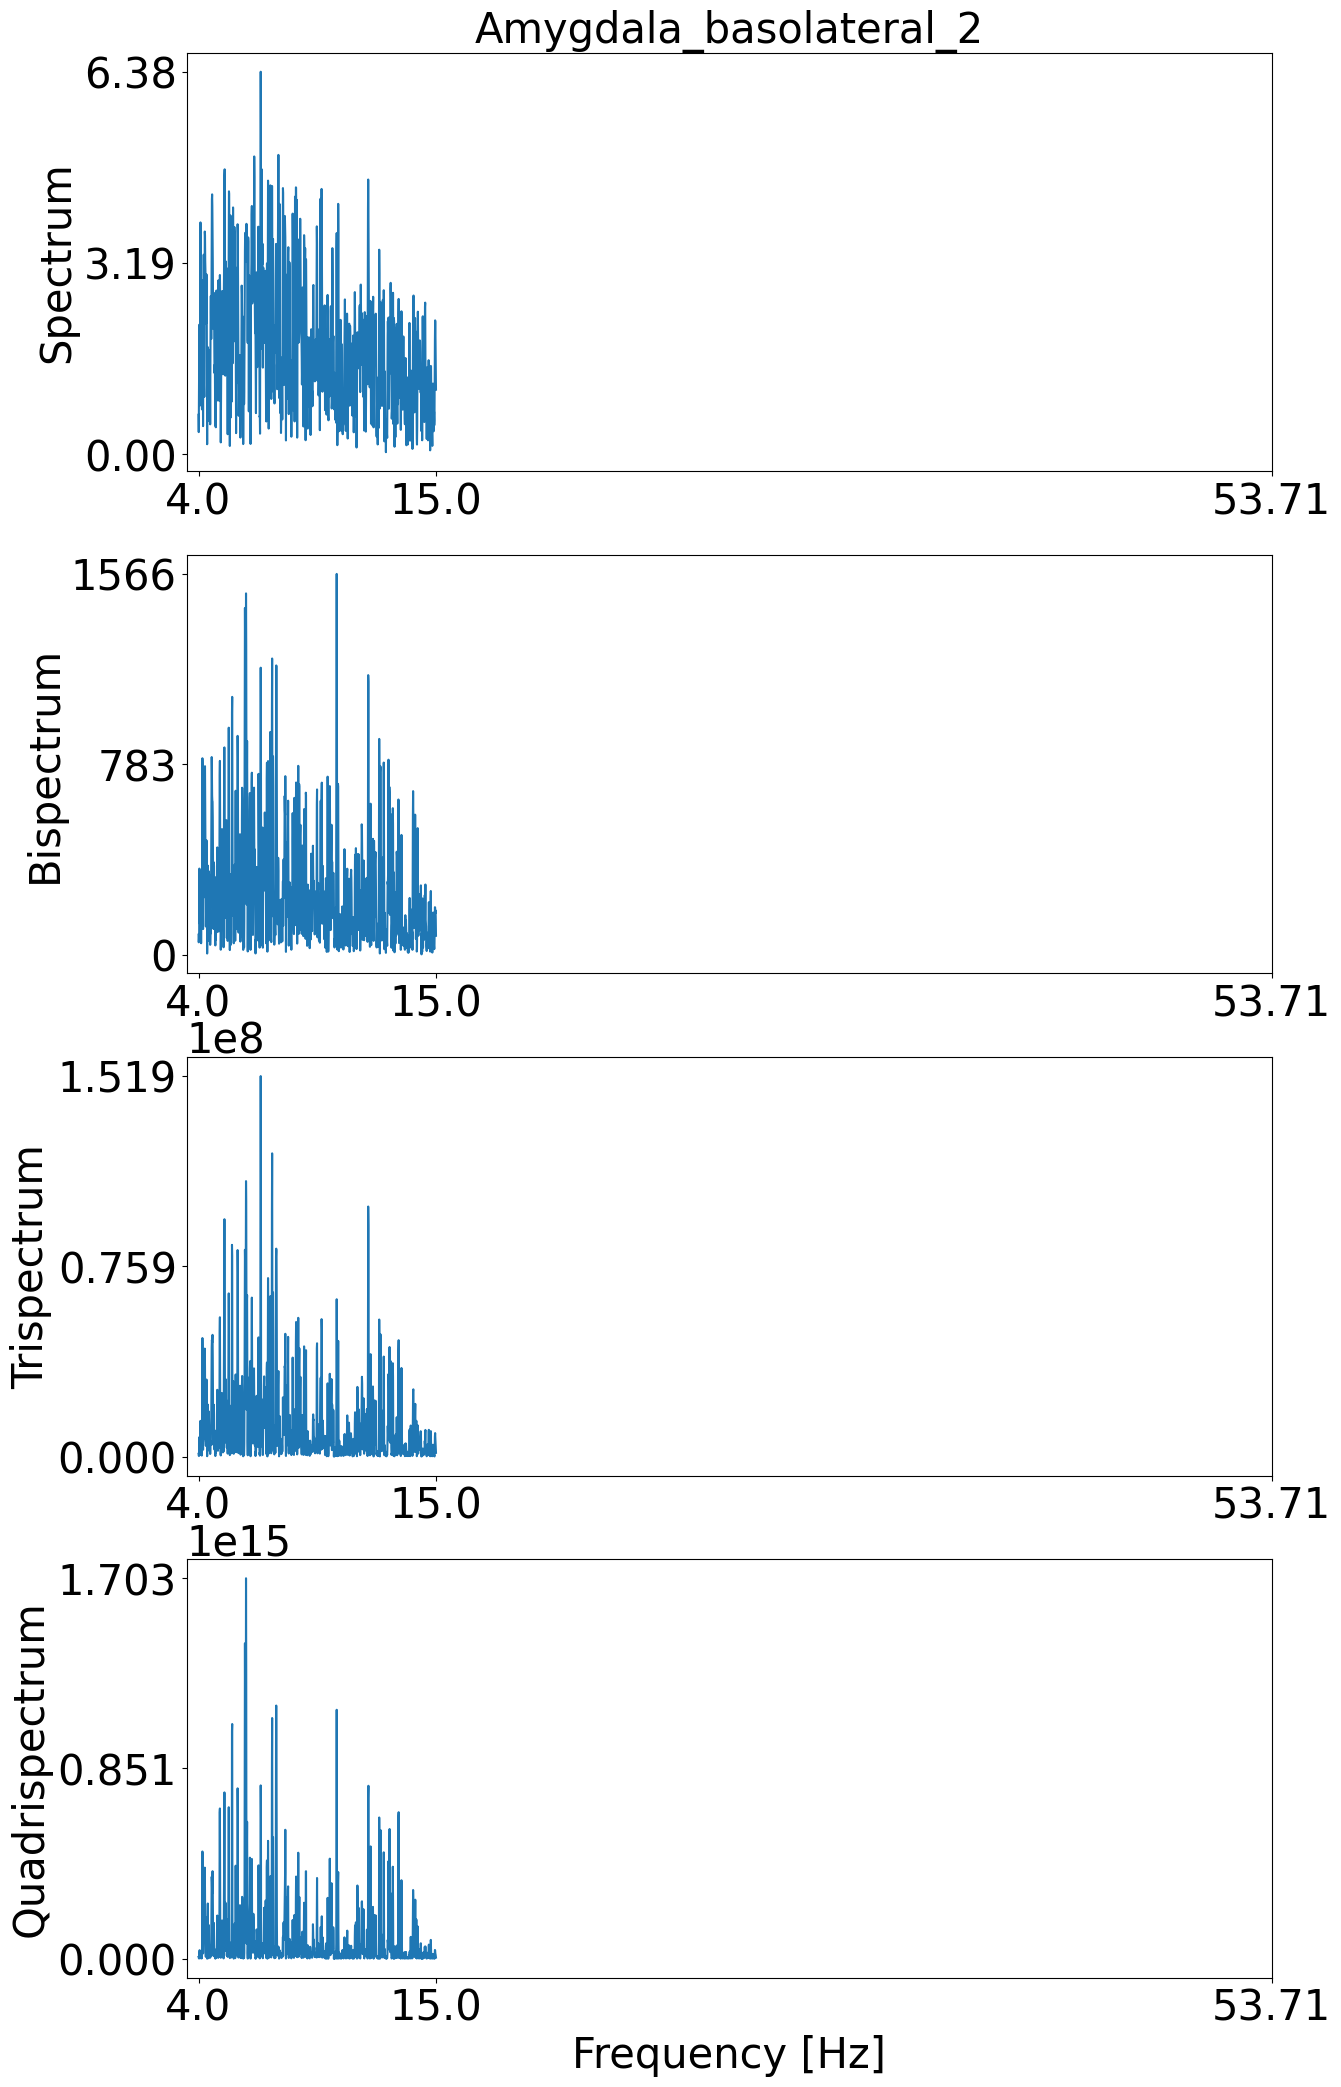

####################################################################################################


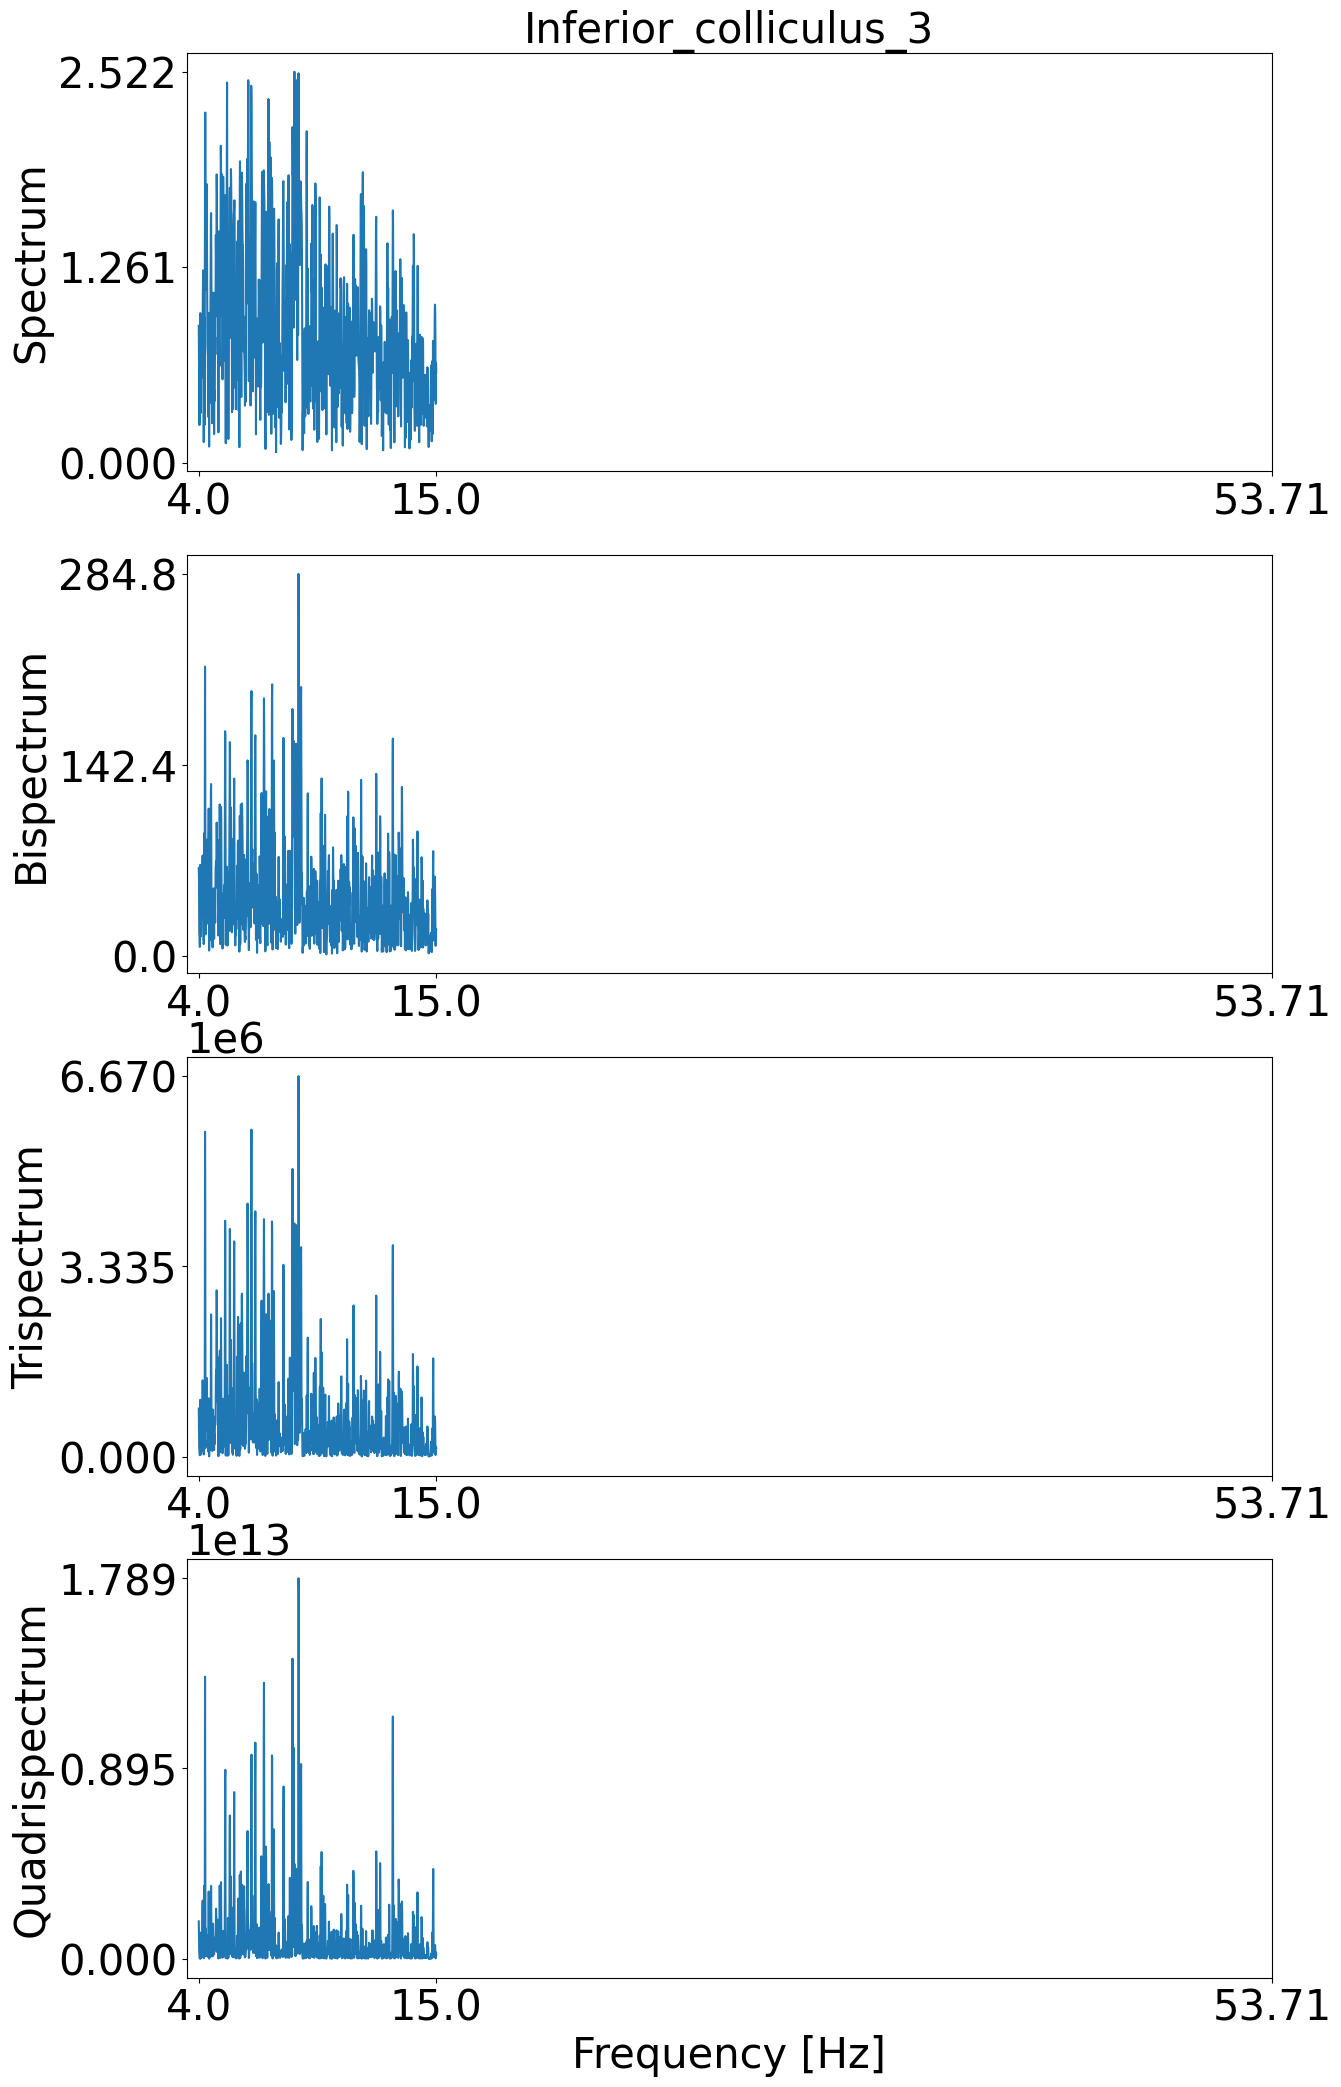

####################################################################################################


In [38]:
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)


freq_array = hosa_df.loc[(hosa_df.frequency>=(lim or [0, 100])[0])&(hosa_df.frequency<=(lim or [0, 100])[1]), "frequency"].to_numpy()

for column in columns[1:]:
    y_spectrum = hosa_df.loc[(hosa_df.frequency>=(lim or [4, 60])[0])&(hosa_df.frequency<=(lim or [4, 60])[1]), f"tds_amp_{column}"].to_numpy()
    y_bispectrum = hosa_df.loc[(hosa_df.frequency>=(lim or [4, 60])[0])&(hosa_df.frequency<=(lim or [4, 60])[1]), f"tdbs_amp_{column}"].to_numpy()
    y_trispectrum = hosa_df.loc[(hosa_df.frequency>=(lim or [4, 60])[0])&(hosa_df.frequency<=(lim or [4, 60])[1]), f"tdts_amp_{column}"].to_numpy()
    y_quadrispectrum = hosa_df.loc[(hosa_df.frequency>=(lim or [4, 60])[0])&(hosa_df.frequency<=(lim or [4, 60])[1]), f"tdqs_amp_{column}"].to_numpy()

    fig = plt.figure(figsize=(14,25))

    plt.subplot(411)
    plt.title(column)
    plt.plot(freq_array, y_spectrum)
    plt.ylabel("Spectrum")
    y_ticks = np.array([0, y_spectrum.max()/2, y_spectrum.max()])
    plt.yticks(y_ticks)
    plt.xticks(ticks=ticks, labels=labels)

    plt.subplot(412)
    plt.plot(freq_array, y_bispectrum)
    plt.ylabel("Bispectrum")
    y_ticks = np.array([0, y_bispectrum.max()/2, y_bispectrum.max()])
    plt.yticks(y_ticks)
    plt.xticks(ticks=ticks, labels=labels)

    plt.subplot(413)
    plt.plot(freq_array, y_trispectrum)
    plt.ylabel("Trispectrum")
    y_ticks = np.array([0, y_trispectrum.max()/2, y_trispectrum.max()])
    plt.yticks(y_ticks)
    plt.xticks(ticks=ticks, labels=labels)

    plt.subplot(414)
    plt.plot(freq_array, y_quadrispectrum)
    plt.ylabel("Quadrispectrum")
    y_ticks = np.array([0, y_quadrispectrum.max()/2, y_quadrispectrum.max()])
    plt.yticks(y_ticks)
    plt.xticks(ticks=ticks, labels=labels)

    plt.xlabel("Frequency [Hz]")
    plt.savefig(
        f"{'with_zoom'*zoom + 'without_zoom'*(not zoom)}/hosa_{id_file}_{id_results}_{column}_{'zoom'*(lim is not None)}.jpg",
        format="jpg",
        bbox_inches='tight', 
        dpi=150
    )

    plt.show()

    print(f"#"*100)

# Selecting Data to model - EVENT 2

In [39]:
event_number = 2
id_results: str = f"event_{event_number}"

event_data = select_event_window(
    df=data_backup, 
    event_name=f"event_{event_number}", 
    samples_before=0, 
    samples_after=0,
    freezing=False
)

In [40]:
frequency_array = np.arange(start=4, stop=60, step=0.01)

TDQS_PARAMETERS = {
    "frequency_array": frequency_array,
    "phase_step": 0.01
}

tdqs_object = TDQS(
    frequency_sampling=FrequencySampling,
    frequency_array=TDQS_PARAMETERS.get("frequency_array"),
    fmin=TDQS_PARAMETERS.get("fmin"),
    fmax=TDQS_PARAMETERS.get("fmax"),
    freq_step=TDQS_PARAMETERS.get("freq_step"),
    phase_step=TDQS_PARAMETERS["phase_step"]
)

In [41]:
path_files = f'{os.getcwd()}/hosa_{id_file}_{id_results}.csv'
load_already_calculated: bool = os.path.isfile(path_files)
if load_already_calculated:
    logger.info("HOSA already calculated. Loading...")
    hosa_df = pd.read_csv(path_files)
    logger.success("HOSA loaded!")

else:
    logger.info("HOSA not calculated yet. Generating hosa...")
    logger.info(f"\nProcessing event {event_number}")

    spectrum_df_amps = pd.DataFrame()
    spectrum_df_phases = pd.DataFrame()

    bispectrum_df_amps = pd.DataFrame()
    bispectrum_df_phases = pd.DataFrame()

    trispectrum_df_amps = pd.DataFrame()
    trispectrum_df_phases = pd.DataFrame()

    quadrispectrum_df_amps = pd.DataFrame()
    quadrispectrum_df_phases = pd.DataFrame()

    hosa_df = pd.DataFrame()

    logger.info("Processing the tdqs... This may take a while...\n")
    start_time = perf_counter()

    # Process the tdbs for each channel, in parallel

    f = lambda x: tdqs_object.run_td4spectrum(x)
    channels_columns = columns[1:]

    with Pool() as pool:

        for result in pool.map(f, [{column: event_data.loc[: , column].to_numpy()} for column in channels_columns]):
            column, result_data = list(result.items())[0]
            (
                frequency_array, 
                spectrum, 
                phase_spectrum, 
                bispectrum, 
                phase_bispectrum, 
                trispectrum, 
                phase_trispectrum, 
                tetraspectrum, 
                phase_tetraspectrum
            ) = result_data

            if (
                "frequency" not in spectrum_df_amps.columns or 
                "frequency" not in bispectrum_df_amps.columns or
                "frequency" not in hosa_df
            ):
                spectrum_df_amps = spectrum_df_amps.assign(frequency=frequency_array)
                bispectrum_df_amps = bispectrum_df_amps.assign(frequency=frequency_array)
                hosa_df =hosa_df.assign(frequency=frequency_array)


            spectrum_df_amps = spectrum_df_amps.assign(**{f"tds_amp_{column}": spectrum})
            spectrum_df_phases = spectrum_df_phases.assign(**{f"tds_phase_{column}": phase_spectrum})

            bispectrum_df_amps = bispectrum_df_amps.assign(**{f"tdbs_amp_{column}": bispectrum})
            bispectrum_df_phases = bispectrum_df_phases.assign(**{f"tdbs_phase_{column}": phase_bispectrum})

            trispectrum_df_amps = bispectrum_df_amps.assign(**{f"tdts_amp_{column}": trispectrum})
            trispectrum_df_phases = bispectrum_df_phases.assign(**{f"tdts_phase_{column}": phase_trispectrum})

            quadrispectrum_df_amps = bispectrum_df_amps.assign(**{f"tdqs_amp_{column}": tetraspectrum})
            quadrispectrum_df_phases = bispectrum_df_phases.assign(**{f"tdqs_phase_{column}": phase_tetraspectrum})

            hosa_df = hosa_df.assign(**{f"tds_amp_{column}": spectrum})
            hosa_df = hosa_df.assign(**{f"tdbs_amp_{column}": bispectrum})
            hosa_df = hosa_df.assign(**{f"tdts_amp_{column}": trispectrum})
            hosa_df = hosa_df.assign(**{f"tdqs_amp_{column}": tetraspectrum})


    spectrum_df = pd.concat([spectrum_df_amps, spectrum_df_phases], axis=1)
    bispectrum_df = pd.concat([bispectrum_df_amps, bispectrum_df_phases], axis=1)
    trispectrum_df = pd.concat([trispectrum_df_amps, trispectrum_df_phases], axis=1)
    quadrispectrum_df = pd.concat([quadrispectrum_df_amps, quadrispectrum_df_phases], axis=1)

    hosa_df.to_csv(f'{os.getcwd()}/hosa_{id_file}_{id_results}.csv', index=False)

    end_time = perf_counter()

    logger.success(f"Done. Elapsed time: {seconds_to_formatted_time(end_time - start_time)}")

2023-09-07 15:43:08.667 | INFO     | __main__:<module>:4 - HOSA already calculated. Loading...
2023-09-07 15:43:08.689 | SUCCESS  | __main__:<module>:6 - HOSA loaded!


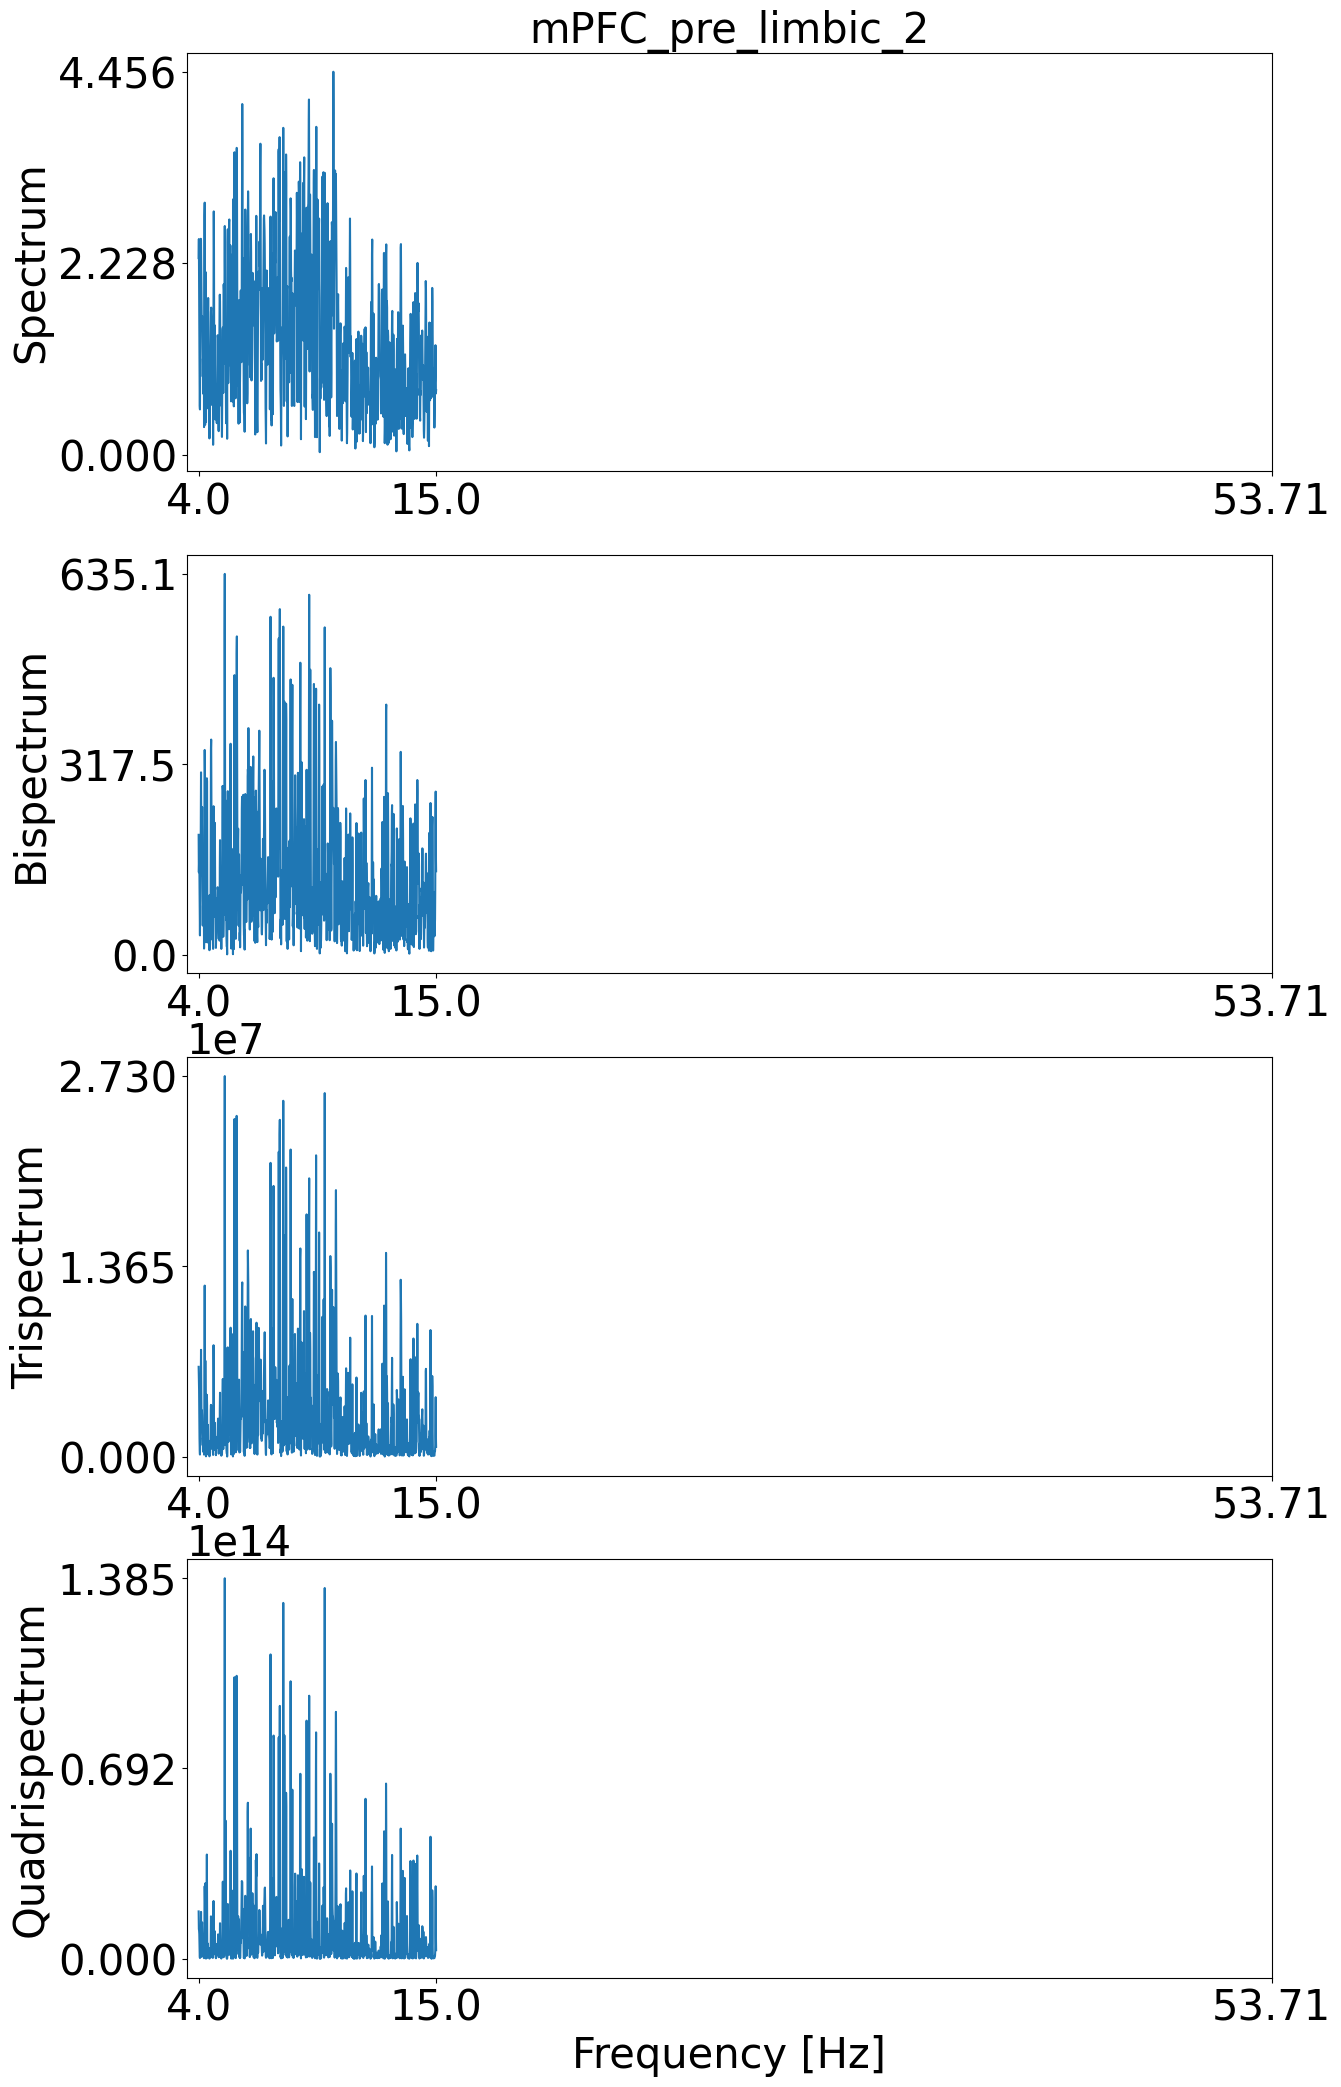

####################################################################################################


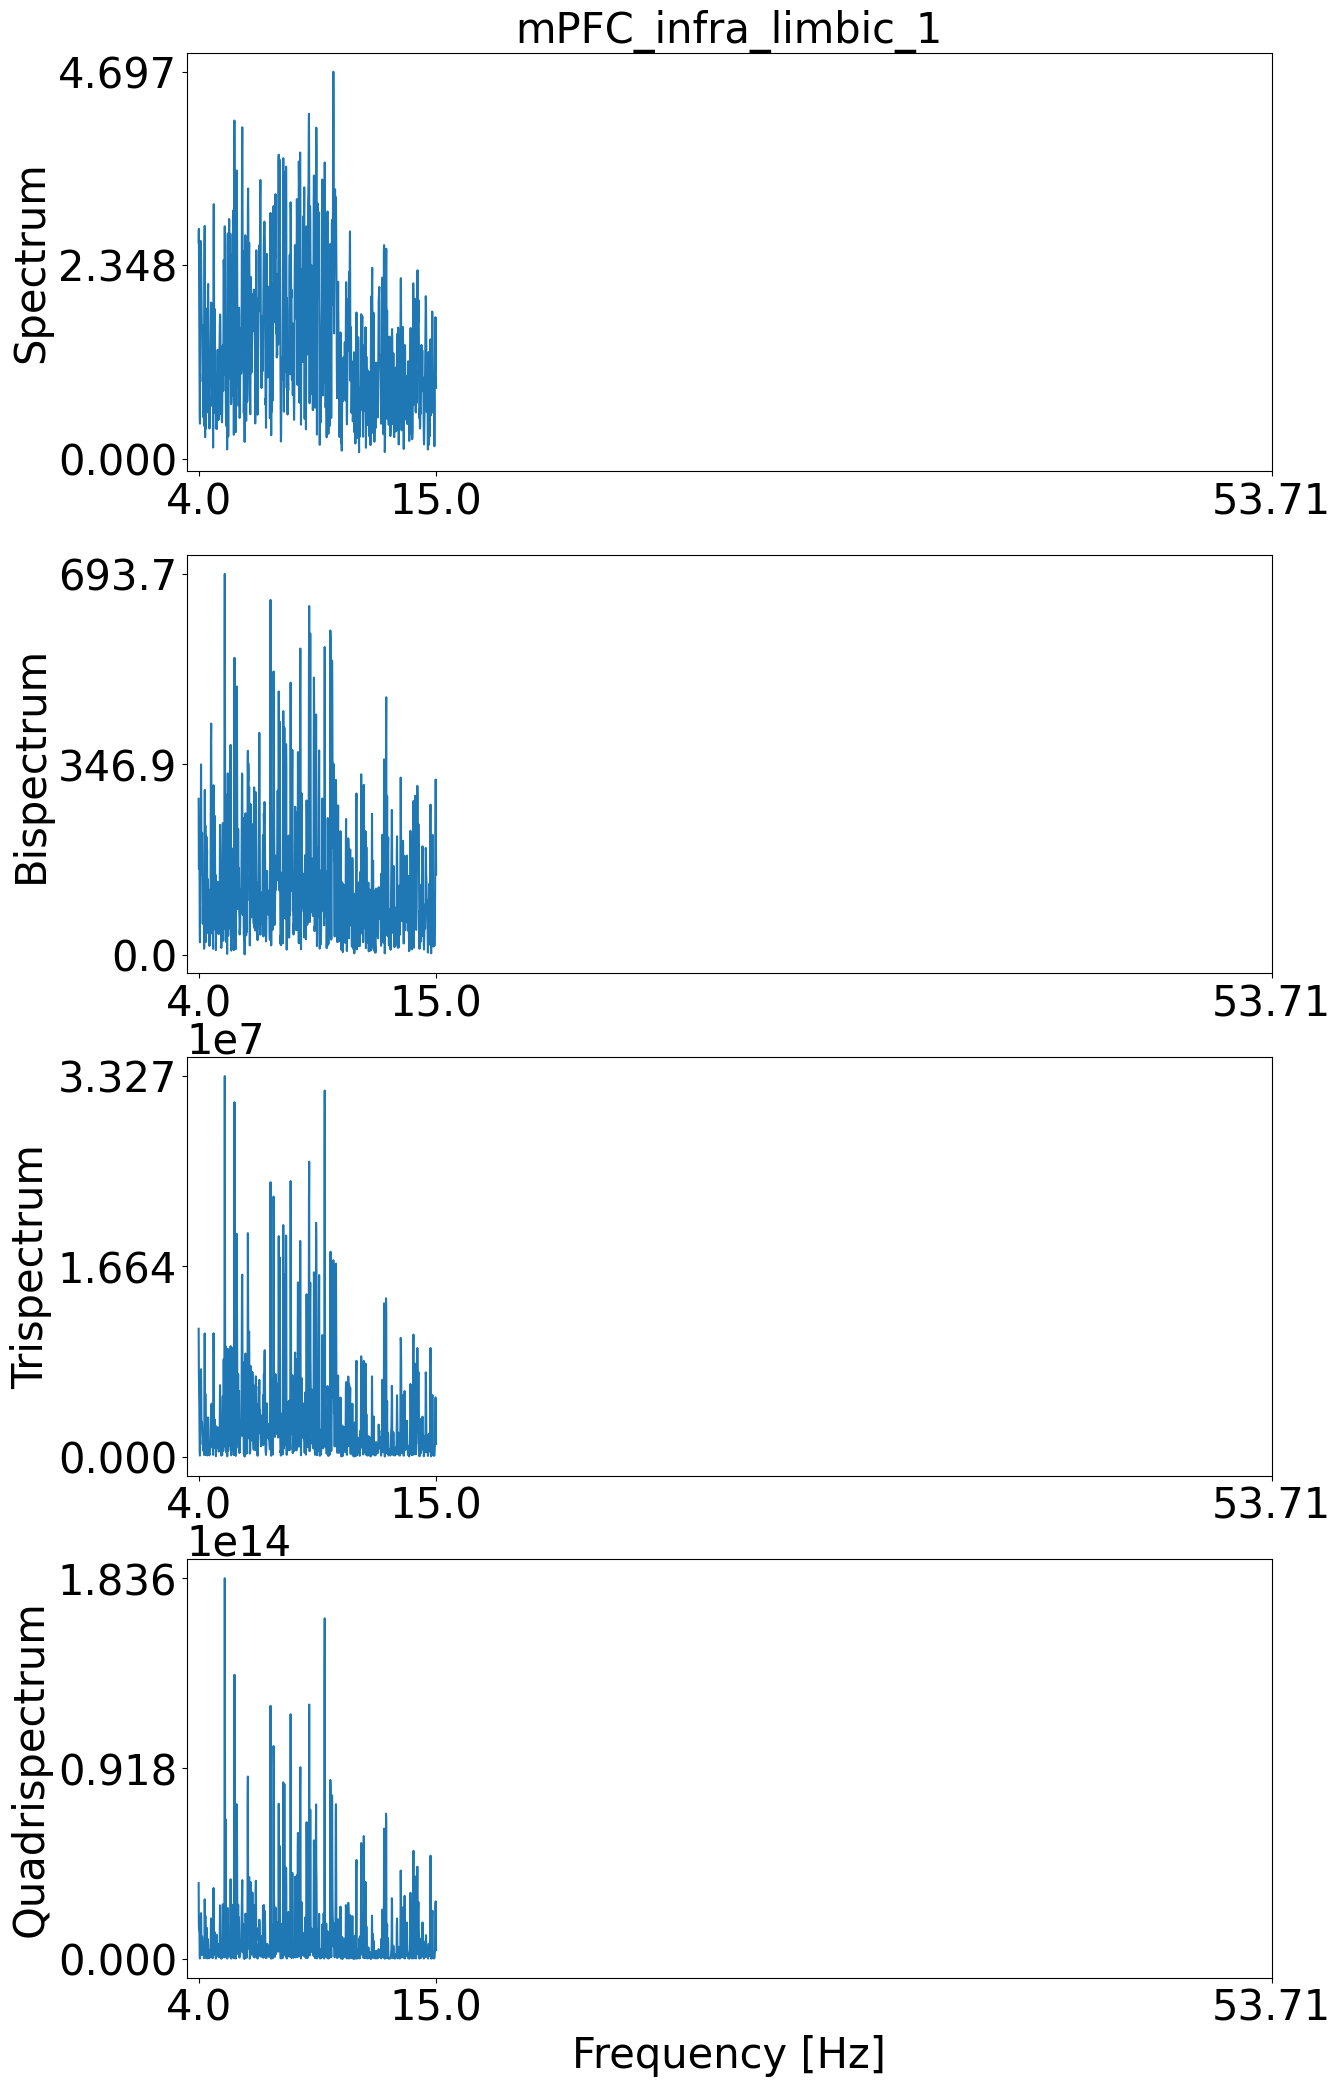

####################################################################################################


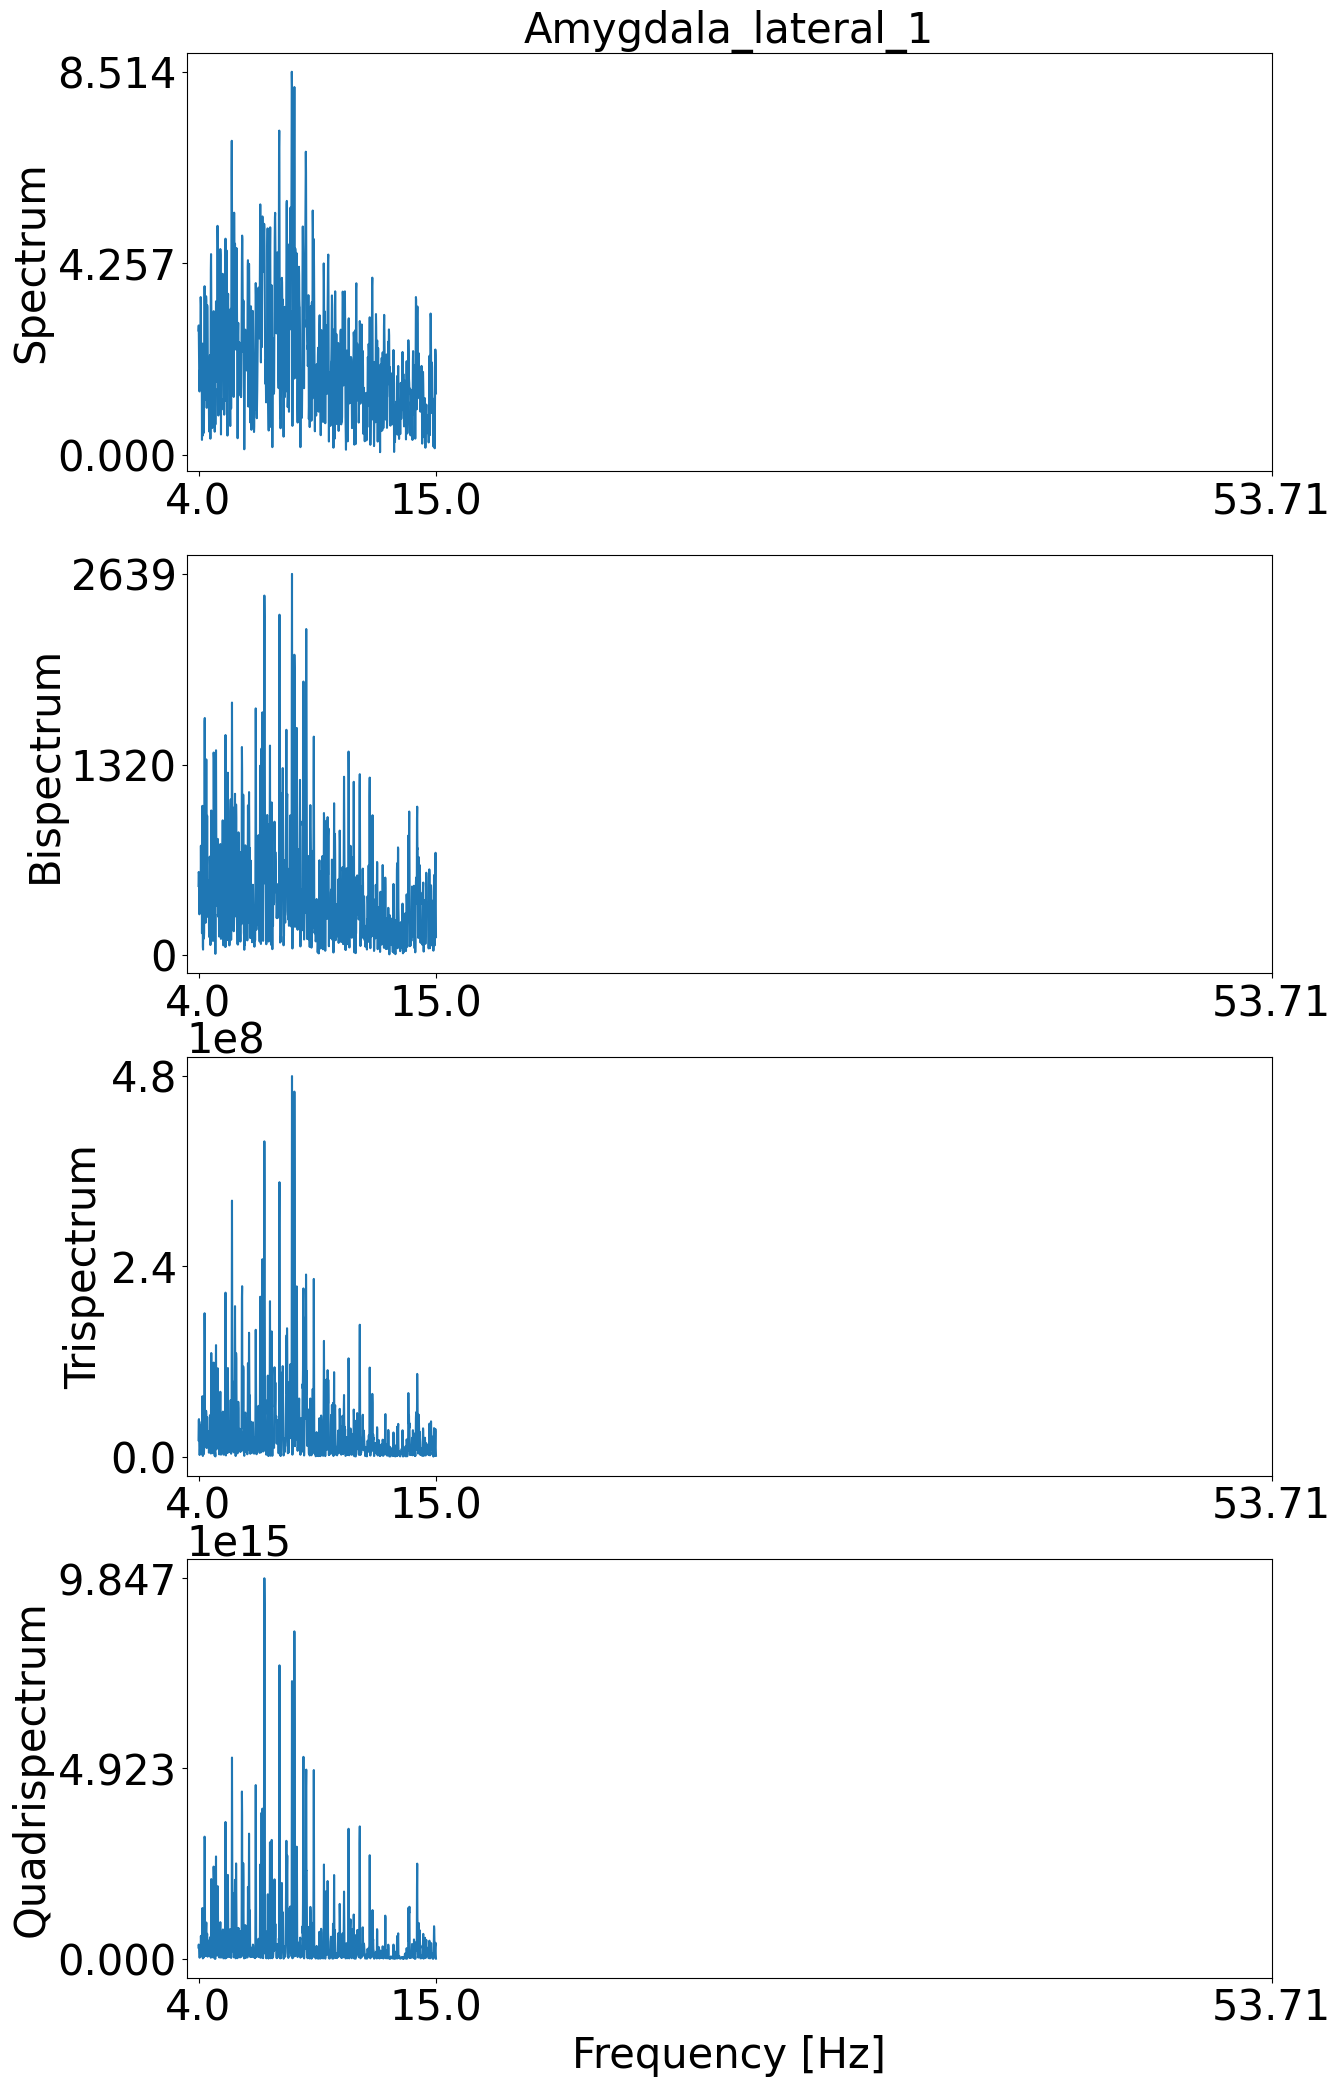

####################################################################################################


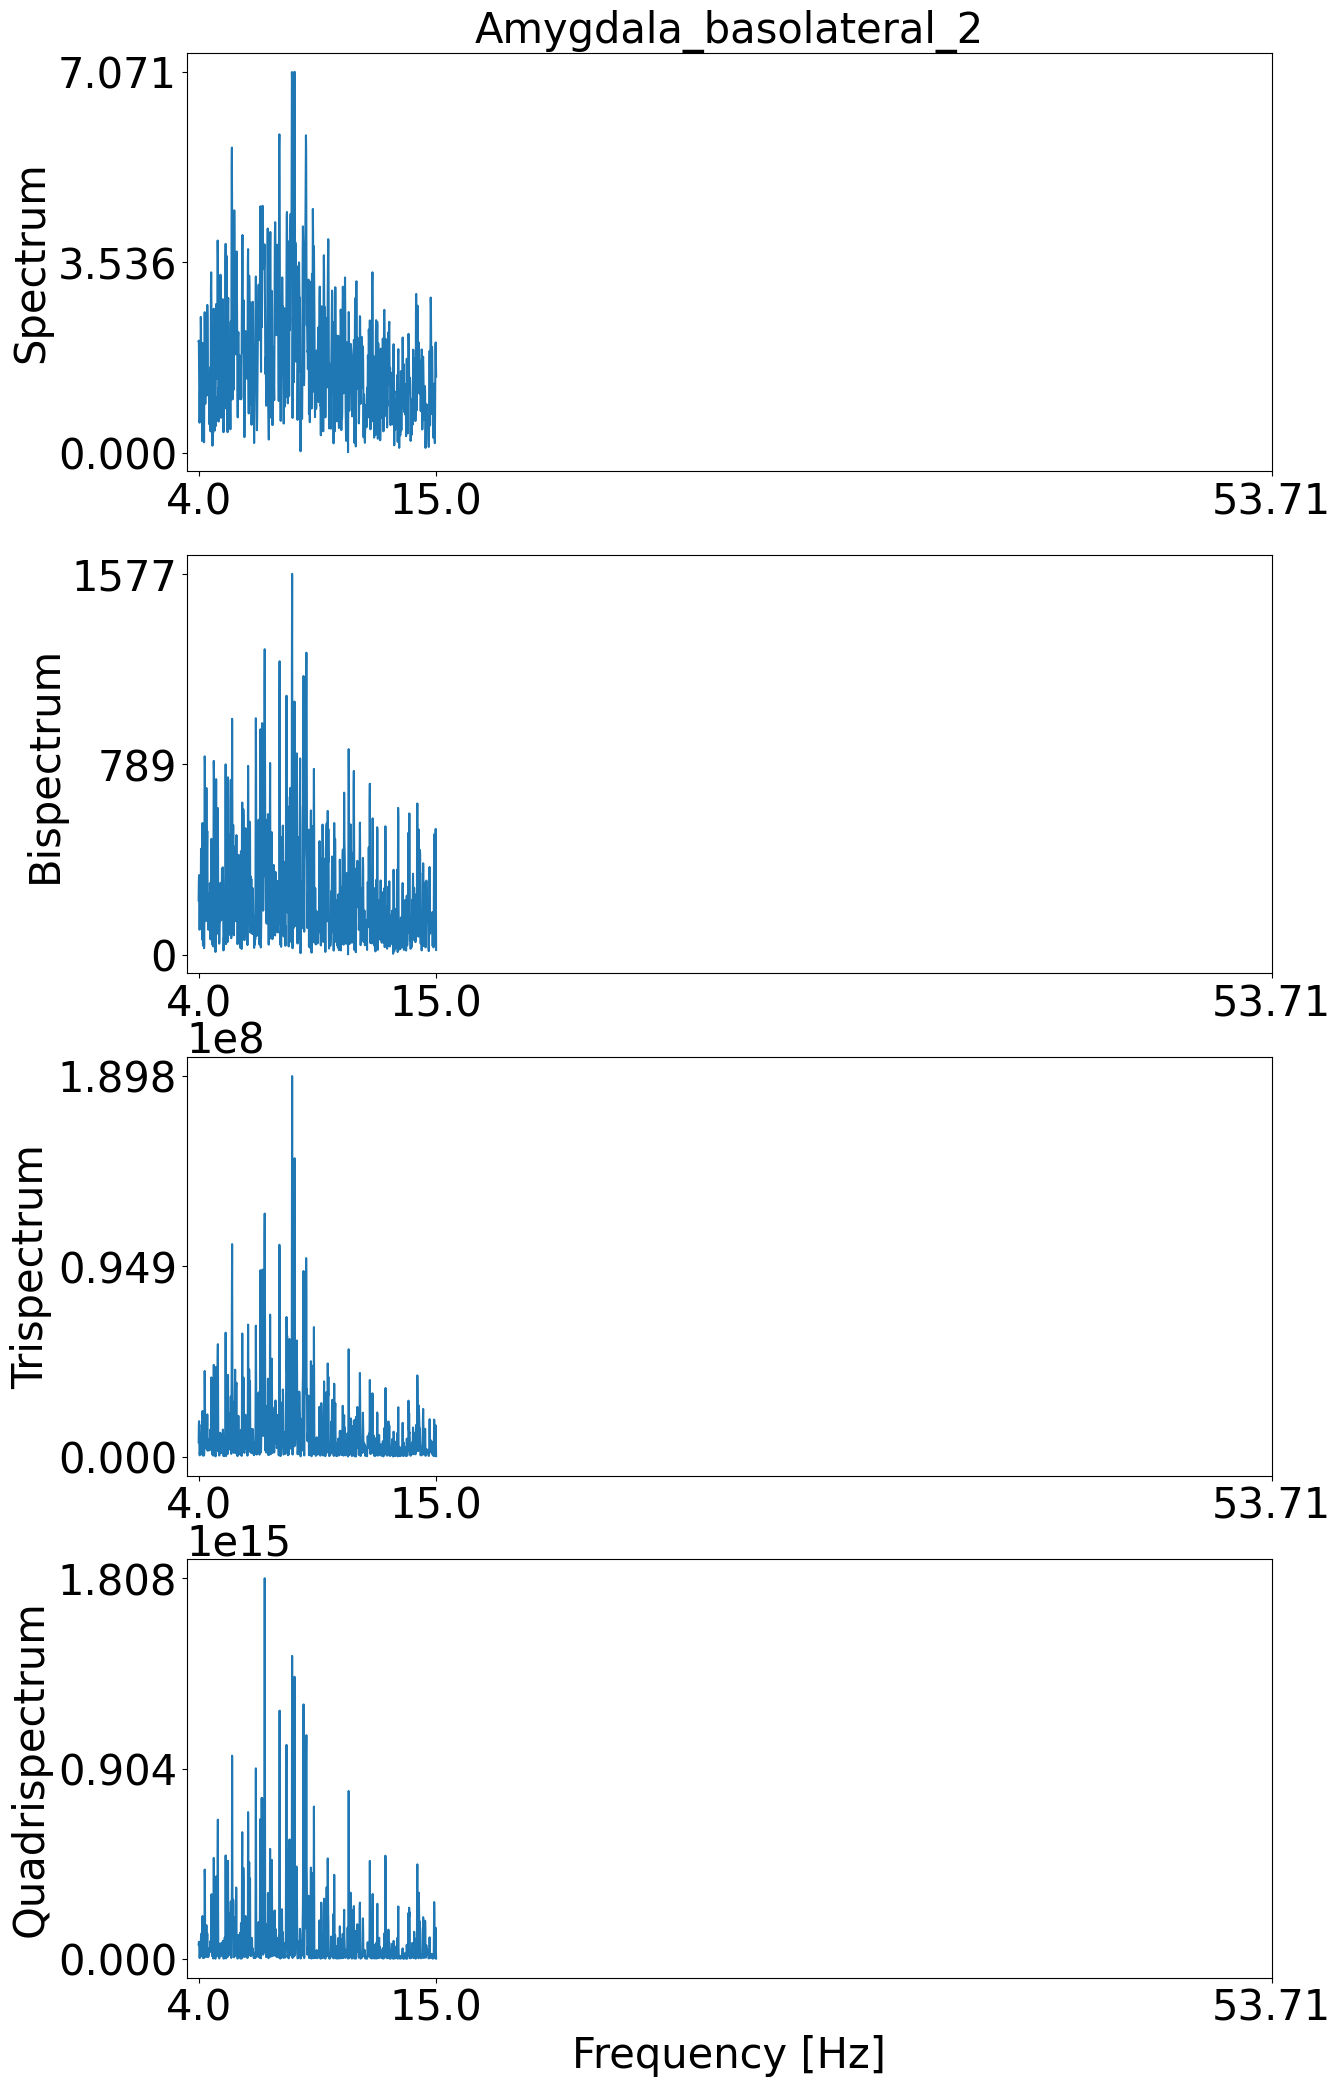

####################################################################################################


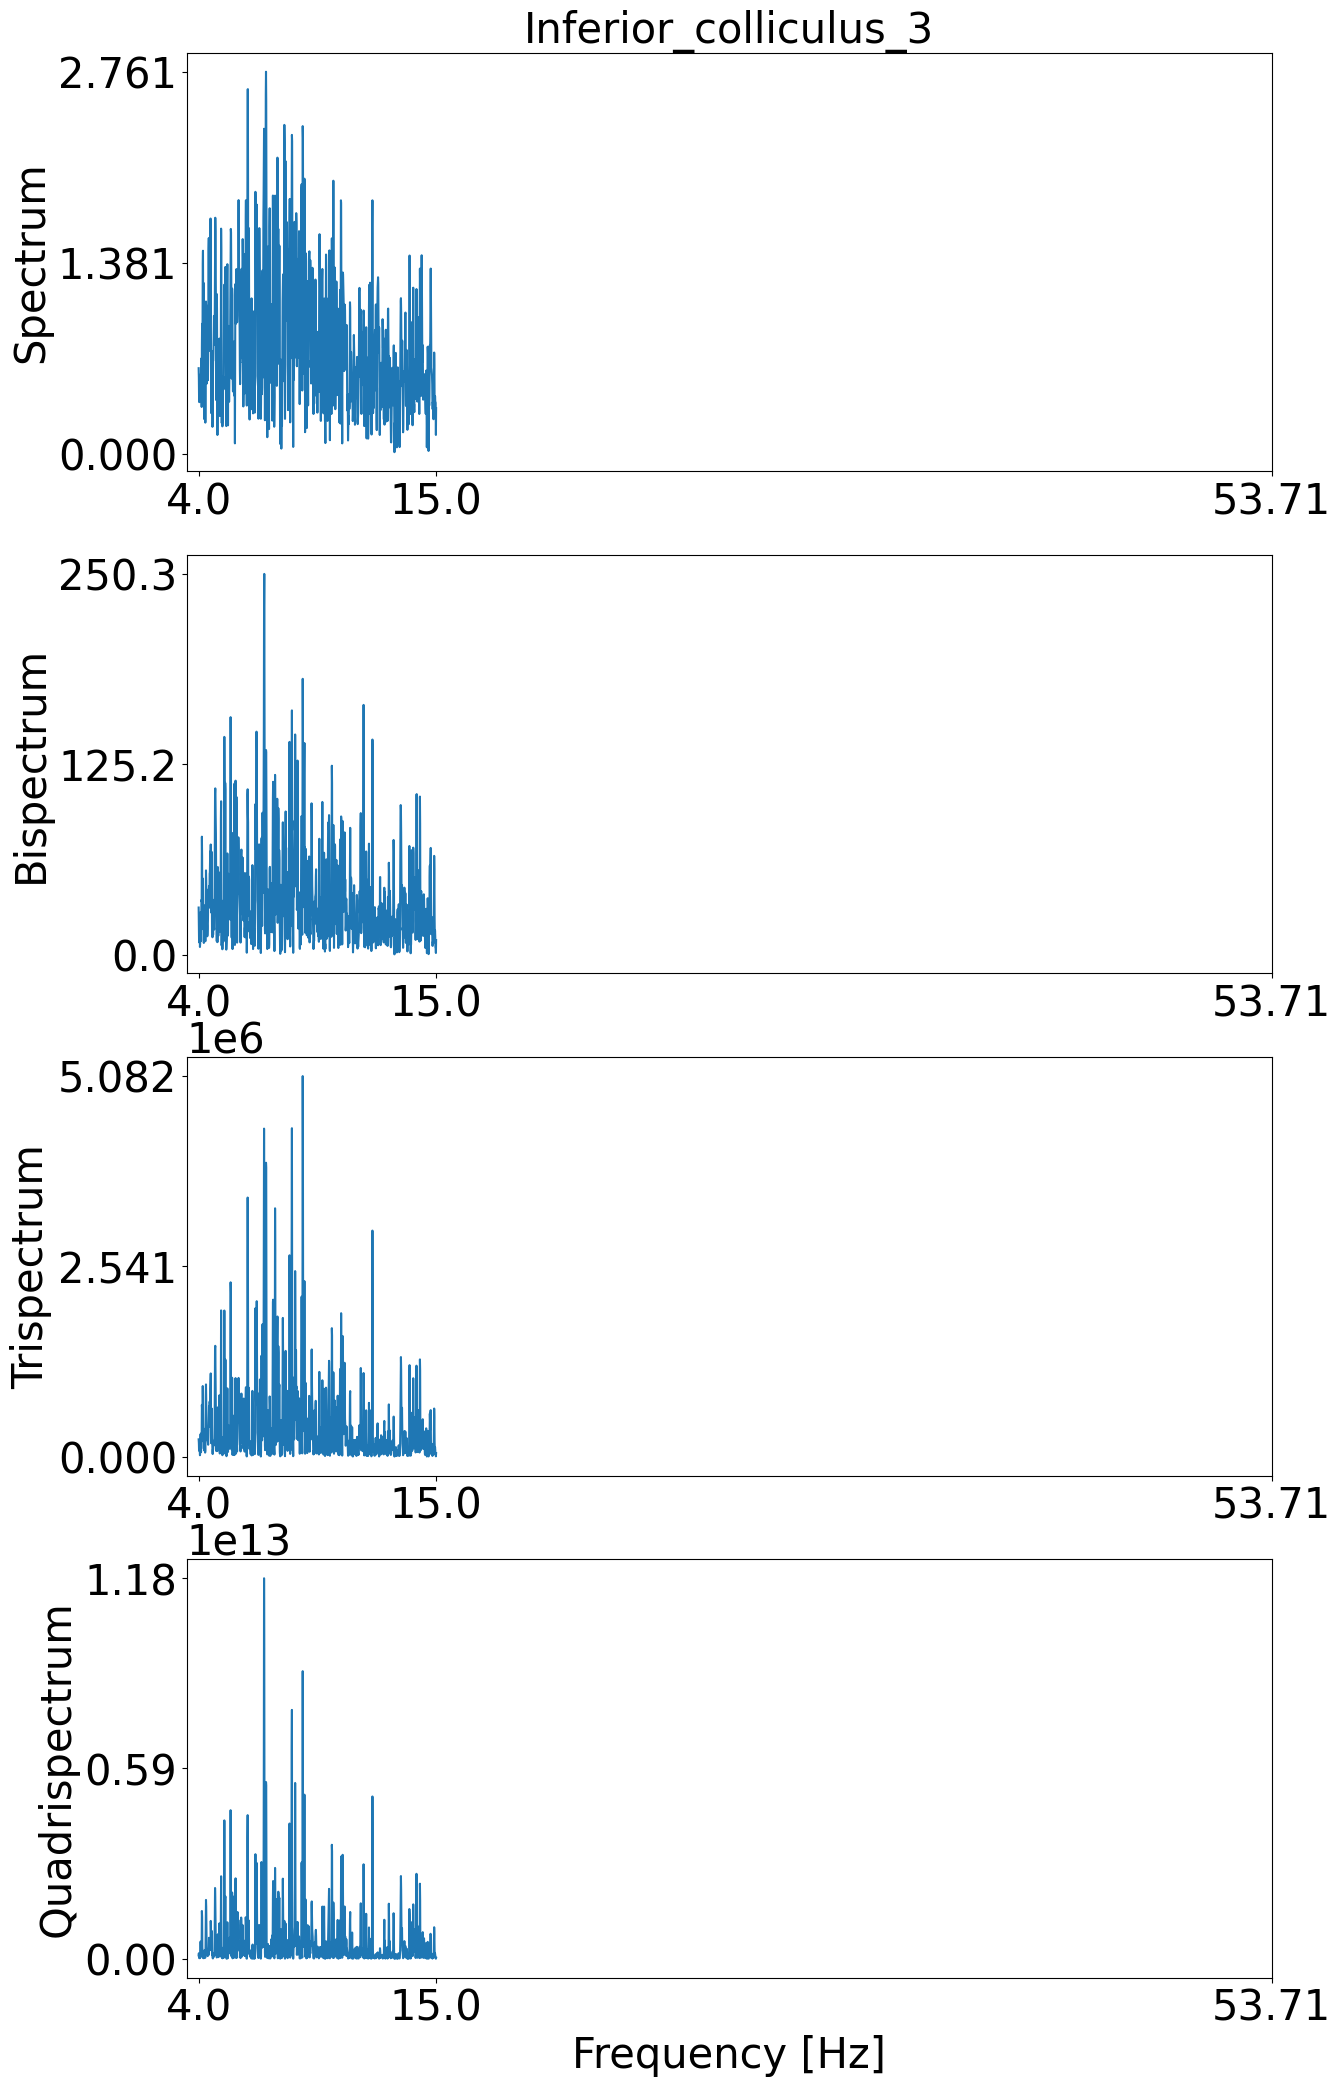

####################################################################################################


In [42]:
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)


freq_array = hosa_df.loc[(hosa_df.frequency>=(lim or [0, 100])[0])&(hosa_df.frequency<=(lim or [0, 100])[1]), "frequency"].to_numpy()

for column in columns[1:]:
    y_spectrum = hosa_df.loc[(hosa_df.frequency>=(lim or [4, 60])[0])&(hosa_df.frequency<=(lim or [4, 60])[1]), f"tds_amp_{column}"].to_numpy()
    y_bispectrum = hosa_df.loc[(hosa_df.frequency>=(lim or [4, 60])[0])&(hosa_df.frequency<=(lim or [4, 60])[1]), f"tdbs_amp_{column}"].to_numpy()
    y_trispectrum = hosa_df.loc[(hosa_df.frequency>=(lim or [4, 60])[0])&(hosa_df.frequency<=(lim or [4, 60])[1]), f"tdts_amp_{column}"].to_numpy()
    y_quadrispectrum = hosa_df.loc[(hosa_df.frequency>=(lim or [4, 60])[0])&(hosa_df.frequency<=(lim or [4, 60])[1]), f"tdqs_amp_{column}"].to_numpy()

    fig = plt.figure(figsize=(14,25))

    plt.subplot(411)
    plt.title(column)
    plt.plot(freq_array, y_spectrum)
    plt.ylabel("Spectrum")
    y_ticks = np.array([0, y_spectrum.max()/2, y_spectrum.max()])
    plt.yticks(y_ticks)
    plt.xticks(ticks=ticks, labels=labels)

    plt.subplot(412)
    plt.plot(freq_array, y_bispectrum)
    plt.ylabel("Bispectrum")
    y_ticks = np.array([0, y_bispectrum.max()/2, y_bispectrum.max()])
    plt.yticks(y_ticks)
    plt.xticks(ticks=ticks, labels=labels)

    plt.subplot(413)
    plt.plot(freq_array, y_trispectrum)
    plt.ylabel("Trispectrum")
    y_ticks = np.array([0, y_trispectrum.max()/2, y_trispectrum.max()])
    plt.yticks(y_ticks)
    plt.xticks(ticks=ticks, labels=labels)

    plt.subplot(414)
    plt.plot(freq_array, y_quadrispectrum)
    plt.ylabel("Quadrispectrum")
    y_ticks = np.array([0, y_quadrispectrum.max()/2, y_quadrispectrum.max()])
    plt.yticks(y_ticks)
    plt.xticks(ticks=ticks, labels=labels)

    plt.xlabel("Frequency [Hz]")
    plt.savefig(
        f"{'with_zoom'*zoom + 'without_zoom'*(not zoom)}/hosa_{id_file}_{id_results}_{column}_{'zoom'*(lim is not None)}.jpg",
        format="jpg",
        bbox_inches='tight', 
        dpi=150
    )

    plt.show()

    print(f"#"*100)

# Selecting Data to model - EVENT 3

In [43]:
event_number = 3
id_results: str = f"event_{event_number}"

event_data = select_event_window(
    df=data_backup, 
    event_name=f"event_{event_number}", 
    samples_before=0, 
    samples_after=0,
    freezing=False
)

In [44]:
frequency_array = np.arange(start=4, stop=60, step=0.01)

TDQS_PARAMETERS = {
    "frequency_array": frequency_array,
    "phase_step": 0.01
}

tdqs_object = TDQS(
    frequency_sampling=FrequencySampling,
    frequency_array=TDQS_PARAMETERS.get("frequency_array"),
    fmin=TDQS_PARAMETERS.get("fmin"),
    fmax=TDQS_PARAMETERS.get("fmax"),
    freq_step=TDQS_PARAMETERS.get("freq_step"),
    phase_step=TDQS_PARAMETERS["phase_step"]
)

In [45]:
path_files = f'{os.getcwd()}/hosa_{id_file}_{id_results}.csv'
load_already_calculated: bool = os.path.isfile(path_files)
if load_already_calculated:
    logger.info("HOSA already calculated. Loading...")
    hosa_df = pd.read_csv(path_files)
    logger.success("HOSA loaded!")

else:
    logger.info("HOSA not calculated yet. Generating hosa...")
    logger.info(f"\nProcessing event {event_number}")

    spectrum_df_amps = pd.DataFrame()
    spectrum_df_phases = pd.DataFrame()

    bispectrum_df_amps = pd.DataFrame()
    bispectrum_df_phases = pd.DataFrame()

    trispectrum_df_amps = pd.DataFrame()
    trispectrum_df_phases = pd.DataFrame()

    quadrispectrum_df_amps = pd.DataFrame()
    quadrispectrum_df_phases = pd.DataFrame()

    hosa_df = pd.DataFrame()

    logger.info("Processing the tdqs... This may take a while...\n")
    start_time = perf_counter()

    # Process the tdbs for each channel, in parallel

    f = lambda x: tdqs_object.run_td4spectrum(x)
    channels_columns = columns[1:]

    with Pool() as pool:

        for result in pool.map(f, [{column: event_data.loc[: , column].to_numpy()} for column in channels_columns]):
            column, result_data = list(result.items())[0]
            (
                frequency_array, 
                spectrum, 
                phase_spectrum, 
                bispectrum, 
                phase_bispectrum, 
                trispectrum, 
                phase_trispectrum, 
                tetraspectrum, 
                phase_tetraspectrum
            ) = result_data

            if (
                "frequency" not in spectrum_df_amps.columns or 
                "frequency" not in bispectrum_df_amps.columns or
                "frequency" not in hosa_df
            ):
                spectrum_df_amps = spectrum_df_amps.assign(frequency=frequency_array)
                bispectrum_df_amps = bispectrum_df_amps.assign(frequency=frequency_array)
                hosa_df =hosa_df.assign(frequency=frequency_array)


            spectrum_df_amps = spectrum_df_amps.assign(**{f"tds_amp_{column}": spectrum})
            spectrum_df_phases = spectrum_df_phases.assign(**{f"tds_phase_{column}": phase_spectrum})

            bispectrum_df_amps = bispectrum_df_amps.assign(**{f"tdbs_amp_{column}": bispectrum})
            bispectrum_df_phases = bispectrum_df_phases.assign(**{f"tdbs_phase_{column}": phase_bispectrum})

            trispectrum_df_amps = bispectrum_df_amps.assign(**{f"tdts_amp_{column}": trispectrum})
            trispectrum_df_phases = bispectrum_df_phases.assign(**{f"tdts_phase_{column}": phase_trispectrum})

            quadrispectrum_df_amps = bispectrum_df_amps.assign(**{f"tdqs_amp_{column}": tetraspectrum})
            quadrispectrum_df_phases = bispectrum_df_phases.assign(**{f"tdqs_phase_{column}": phase_tetraspectrum})

            hosa_df = hosa_df.assign(**{f"tds_amp_{column}": spectrum})
            hosa_df = hosa_df.assign(**{f"tdbs_amp_{column}": bispectrum})
            hosa_df = hosa_df.assign(**{f"tdts_amp_{column}": trispectrum})
            hosa_df = hosa_df.assign(**{f"tdqs_amp_{column}": tetraspectrum})


    spectrum_df = pd.concat([spectrum_df_amps, spectrum_df_phases], axis=1)
    bispectrum_df = pd.concat([bispectrum_df_amps, bispectrum_df_phases], axis=1)
    trispectrum_df = pd.concat([trispectrum_df_amps, trispectrum_df_phases], axis=1)
    quadrispectrum_df = pd.concat([quadrispectrum_df_amps, quadrispectrum_df_phases], axis=1)

    hosa_df.to_csv(f'{os.getcwd()}/hosa_{id_file}_{id_results}.csv', index=False)

    end_time = perf_counter()

    logger.success(f"Done. Elapsed time: {seconds_to_formatted_time(end_time - start_time)}")

2023-09-07 15:43:11.389 | INFO     | __main__:<module>:4 - HOSA already calculated. Loading...
2023-09-07 15:43:11.408 | SUCCESS  | __main__:<module>:6 - HOSA loaded!


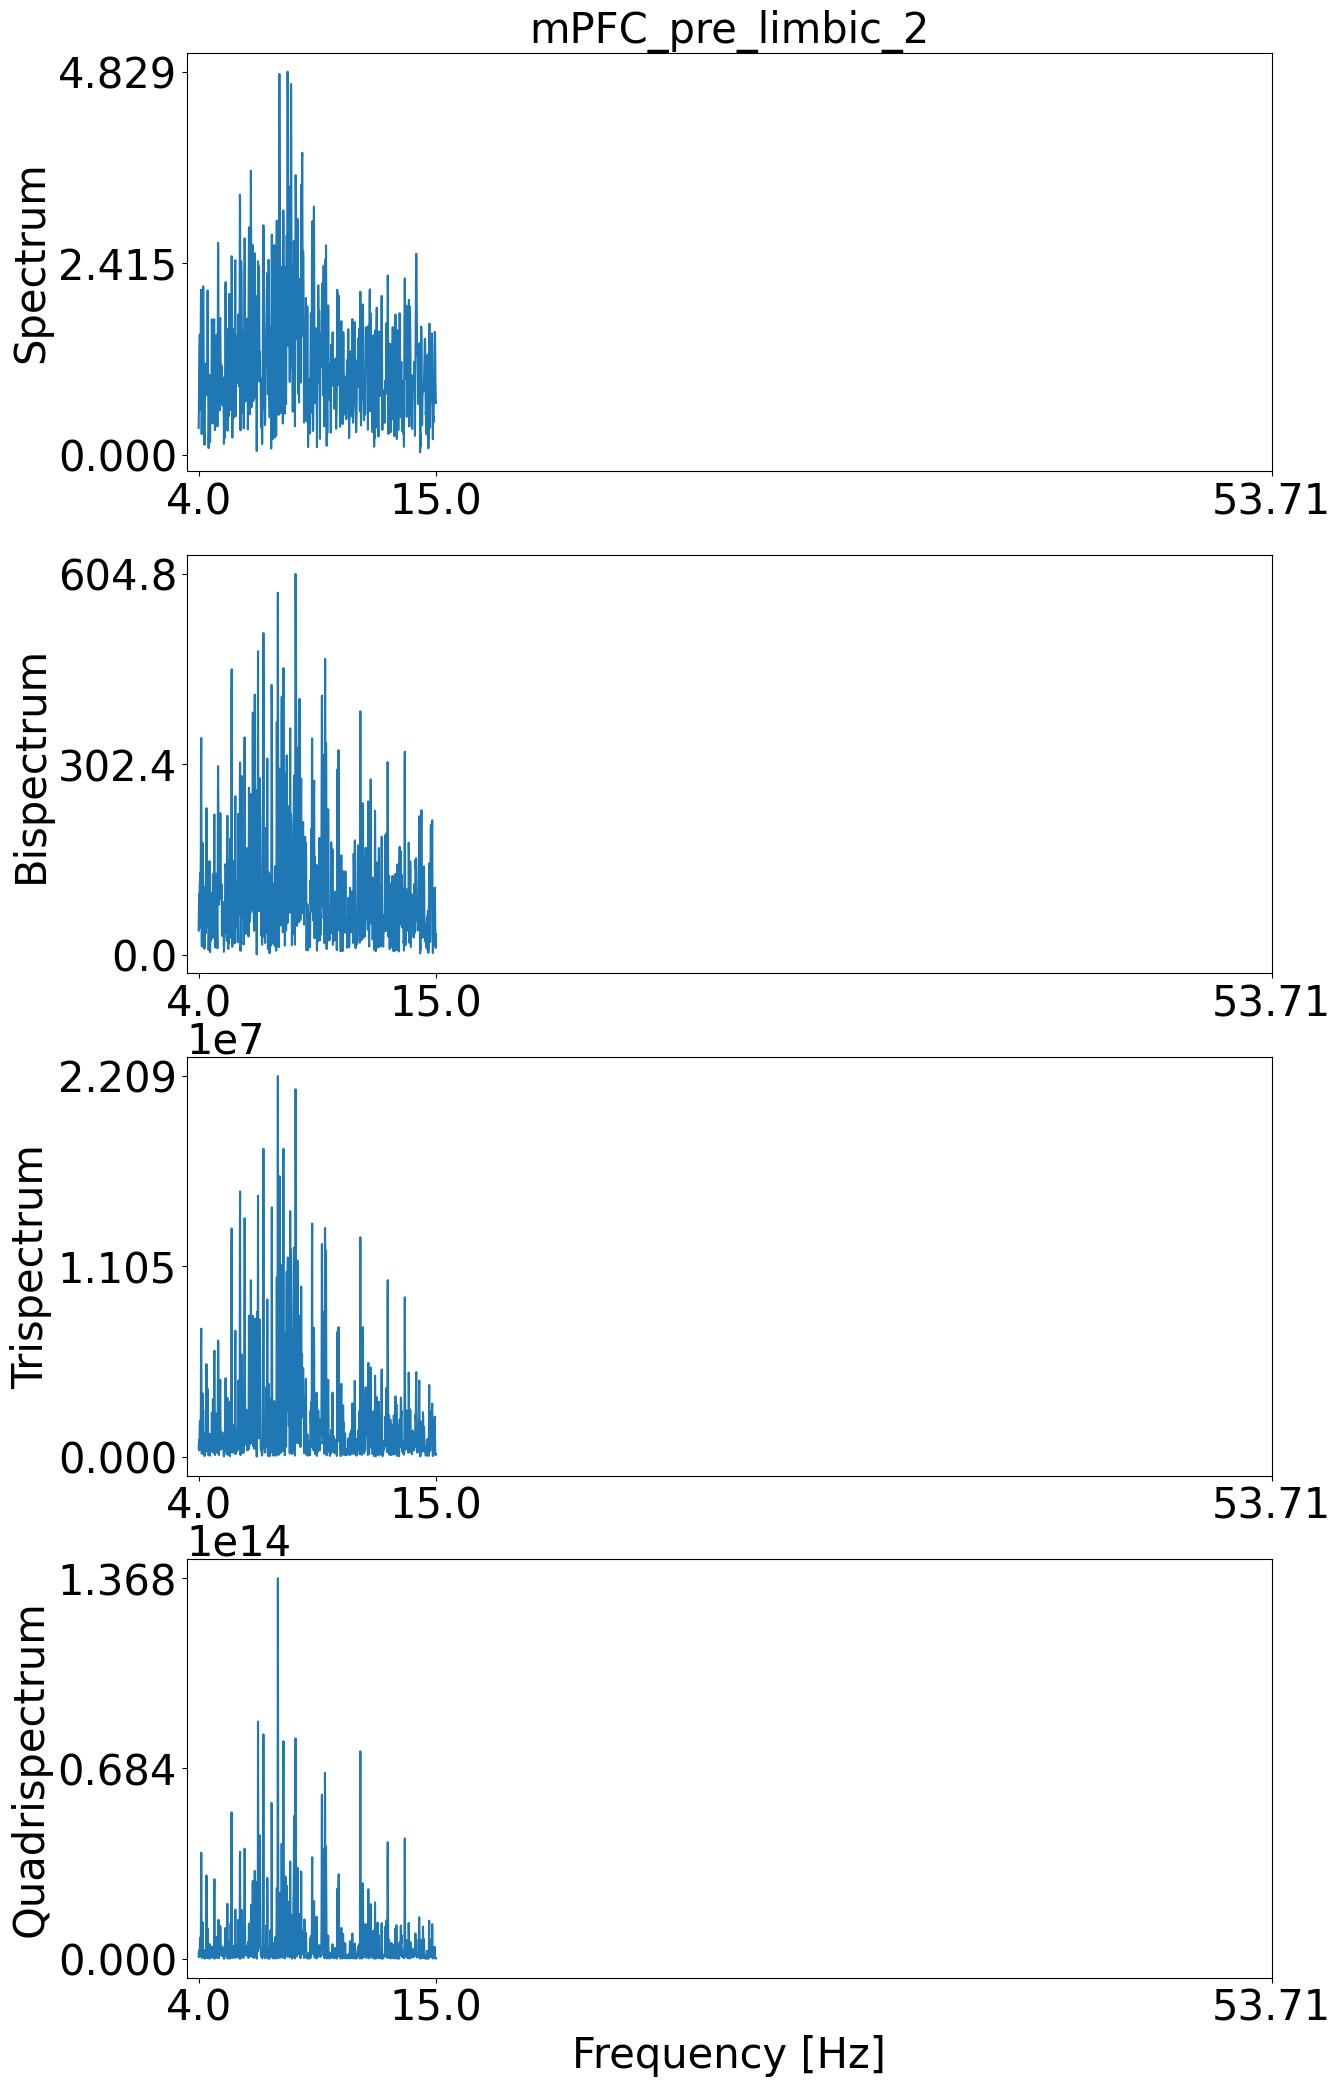

####################################################################################################


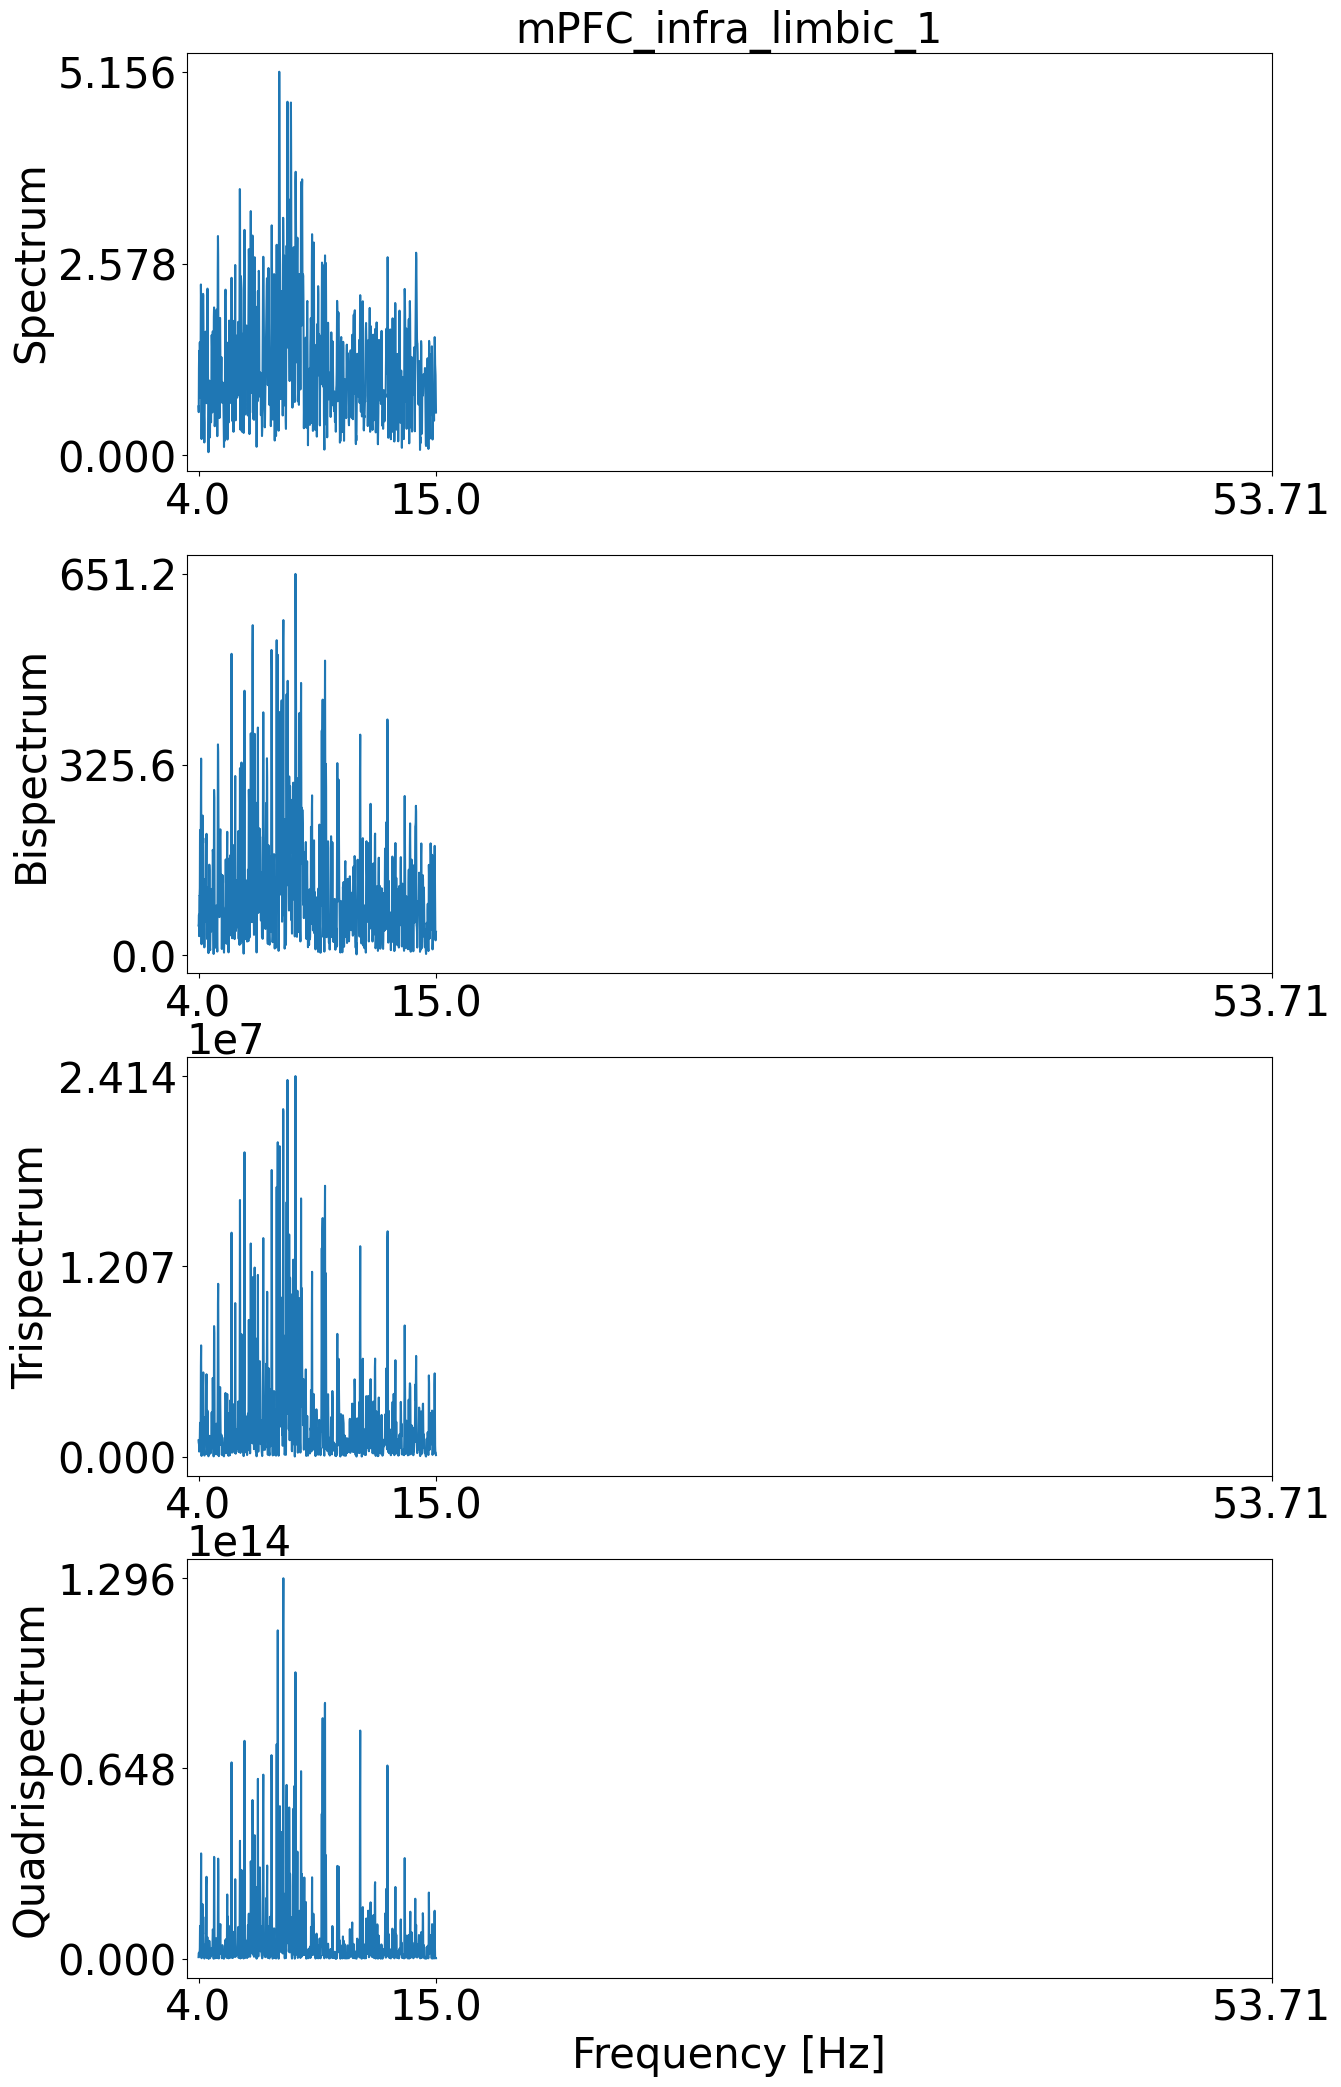

####################################################################################################


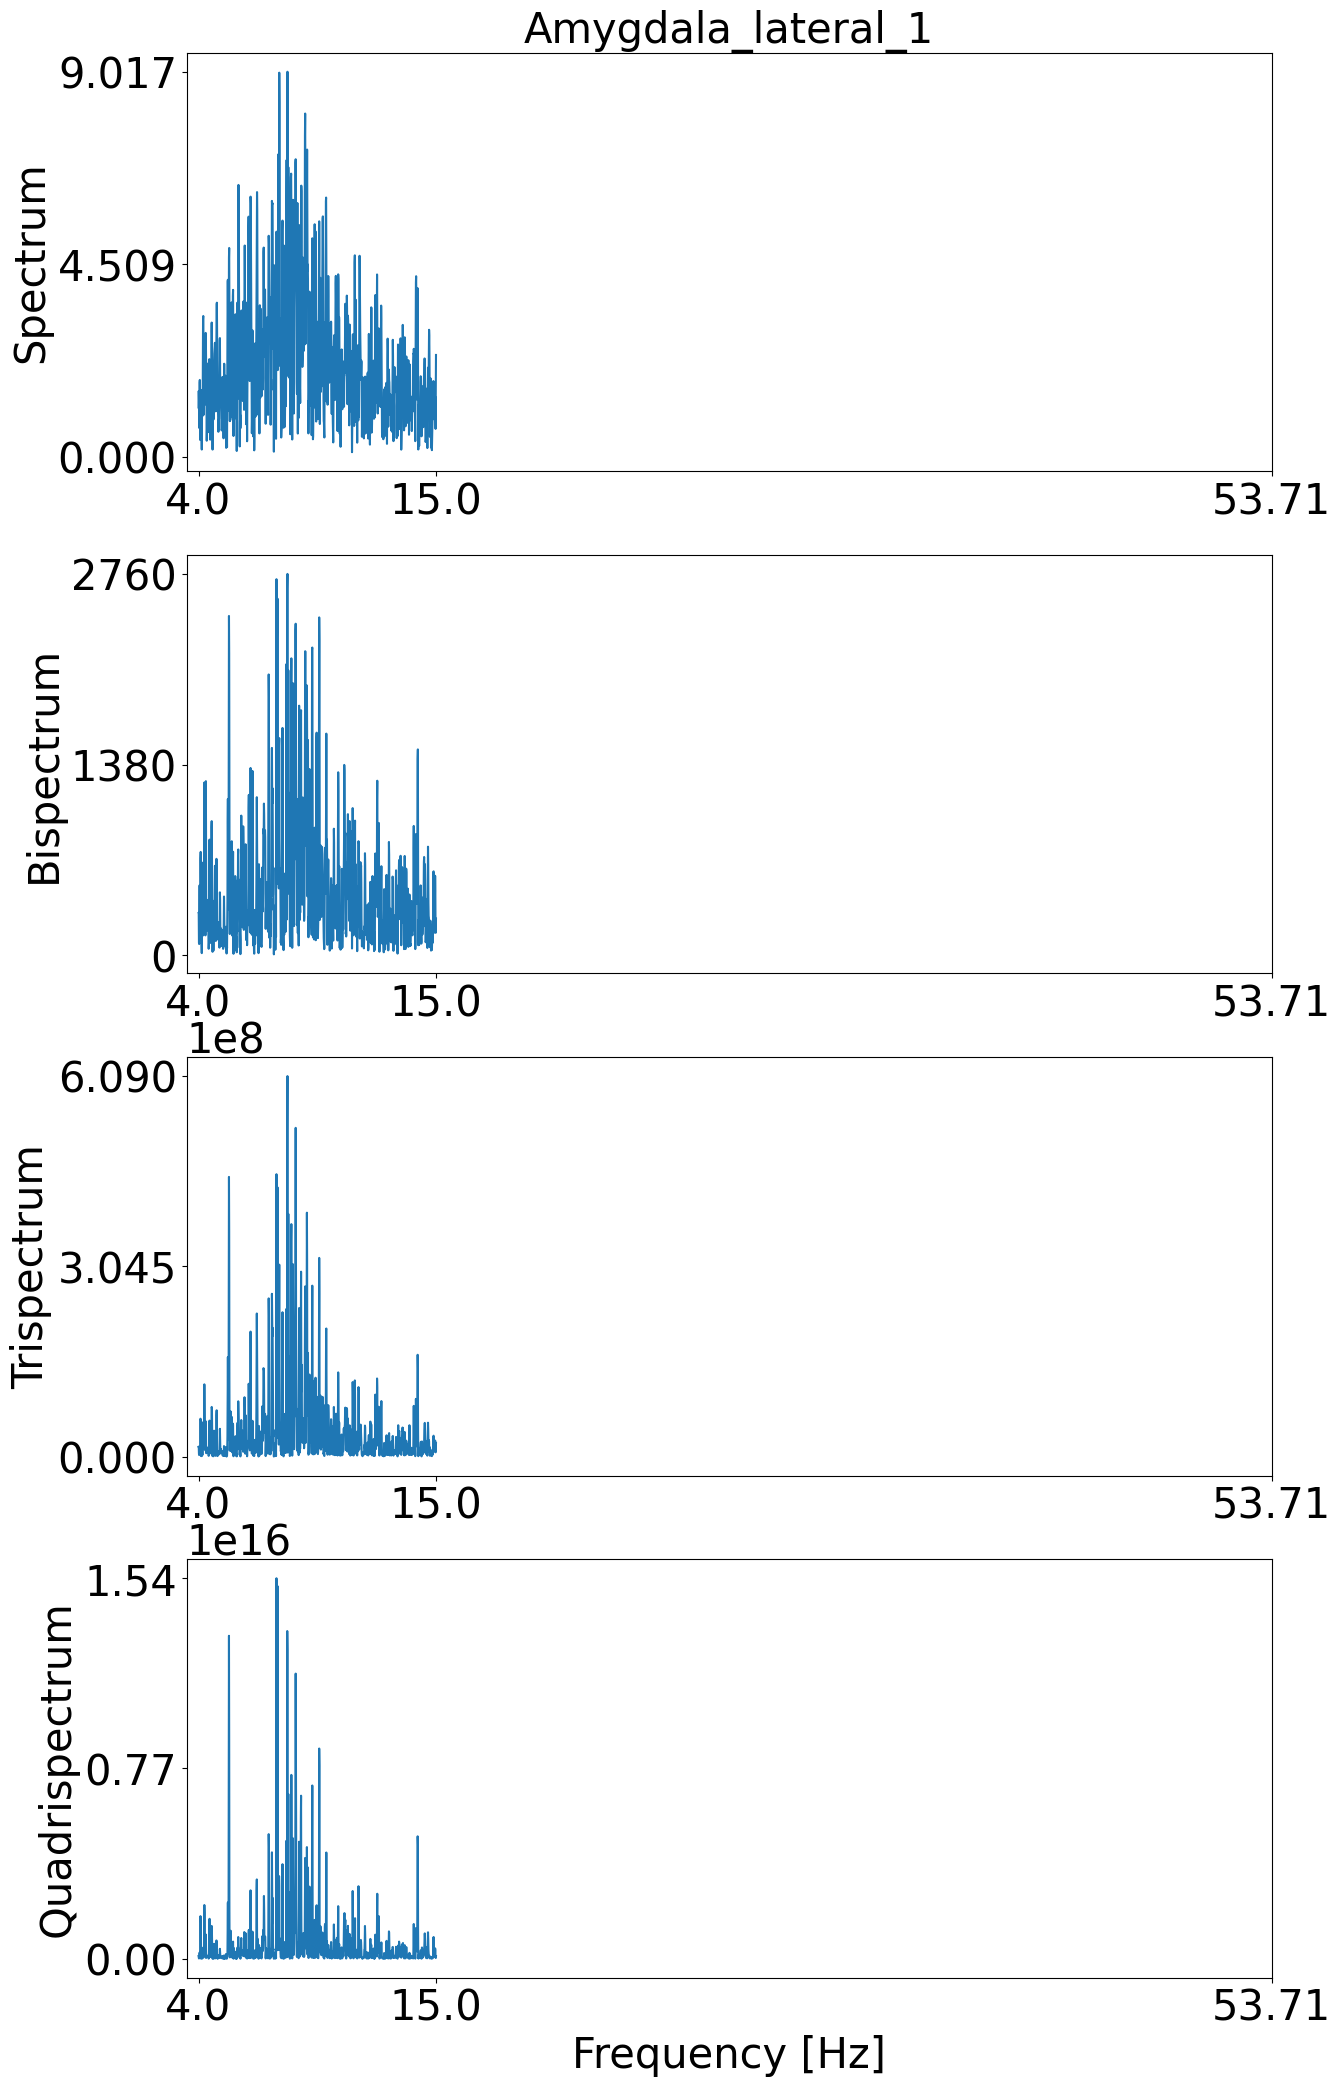

####################################################################################################


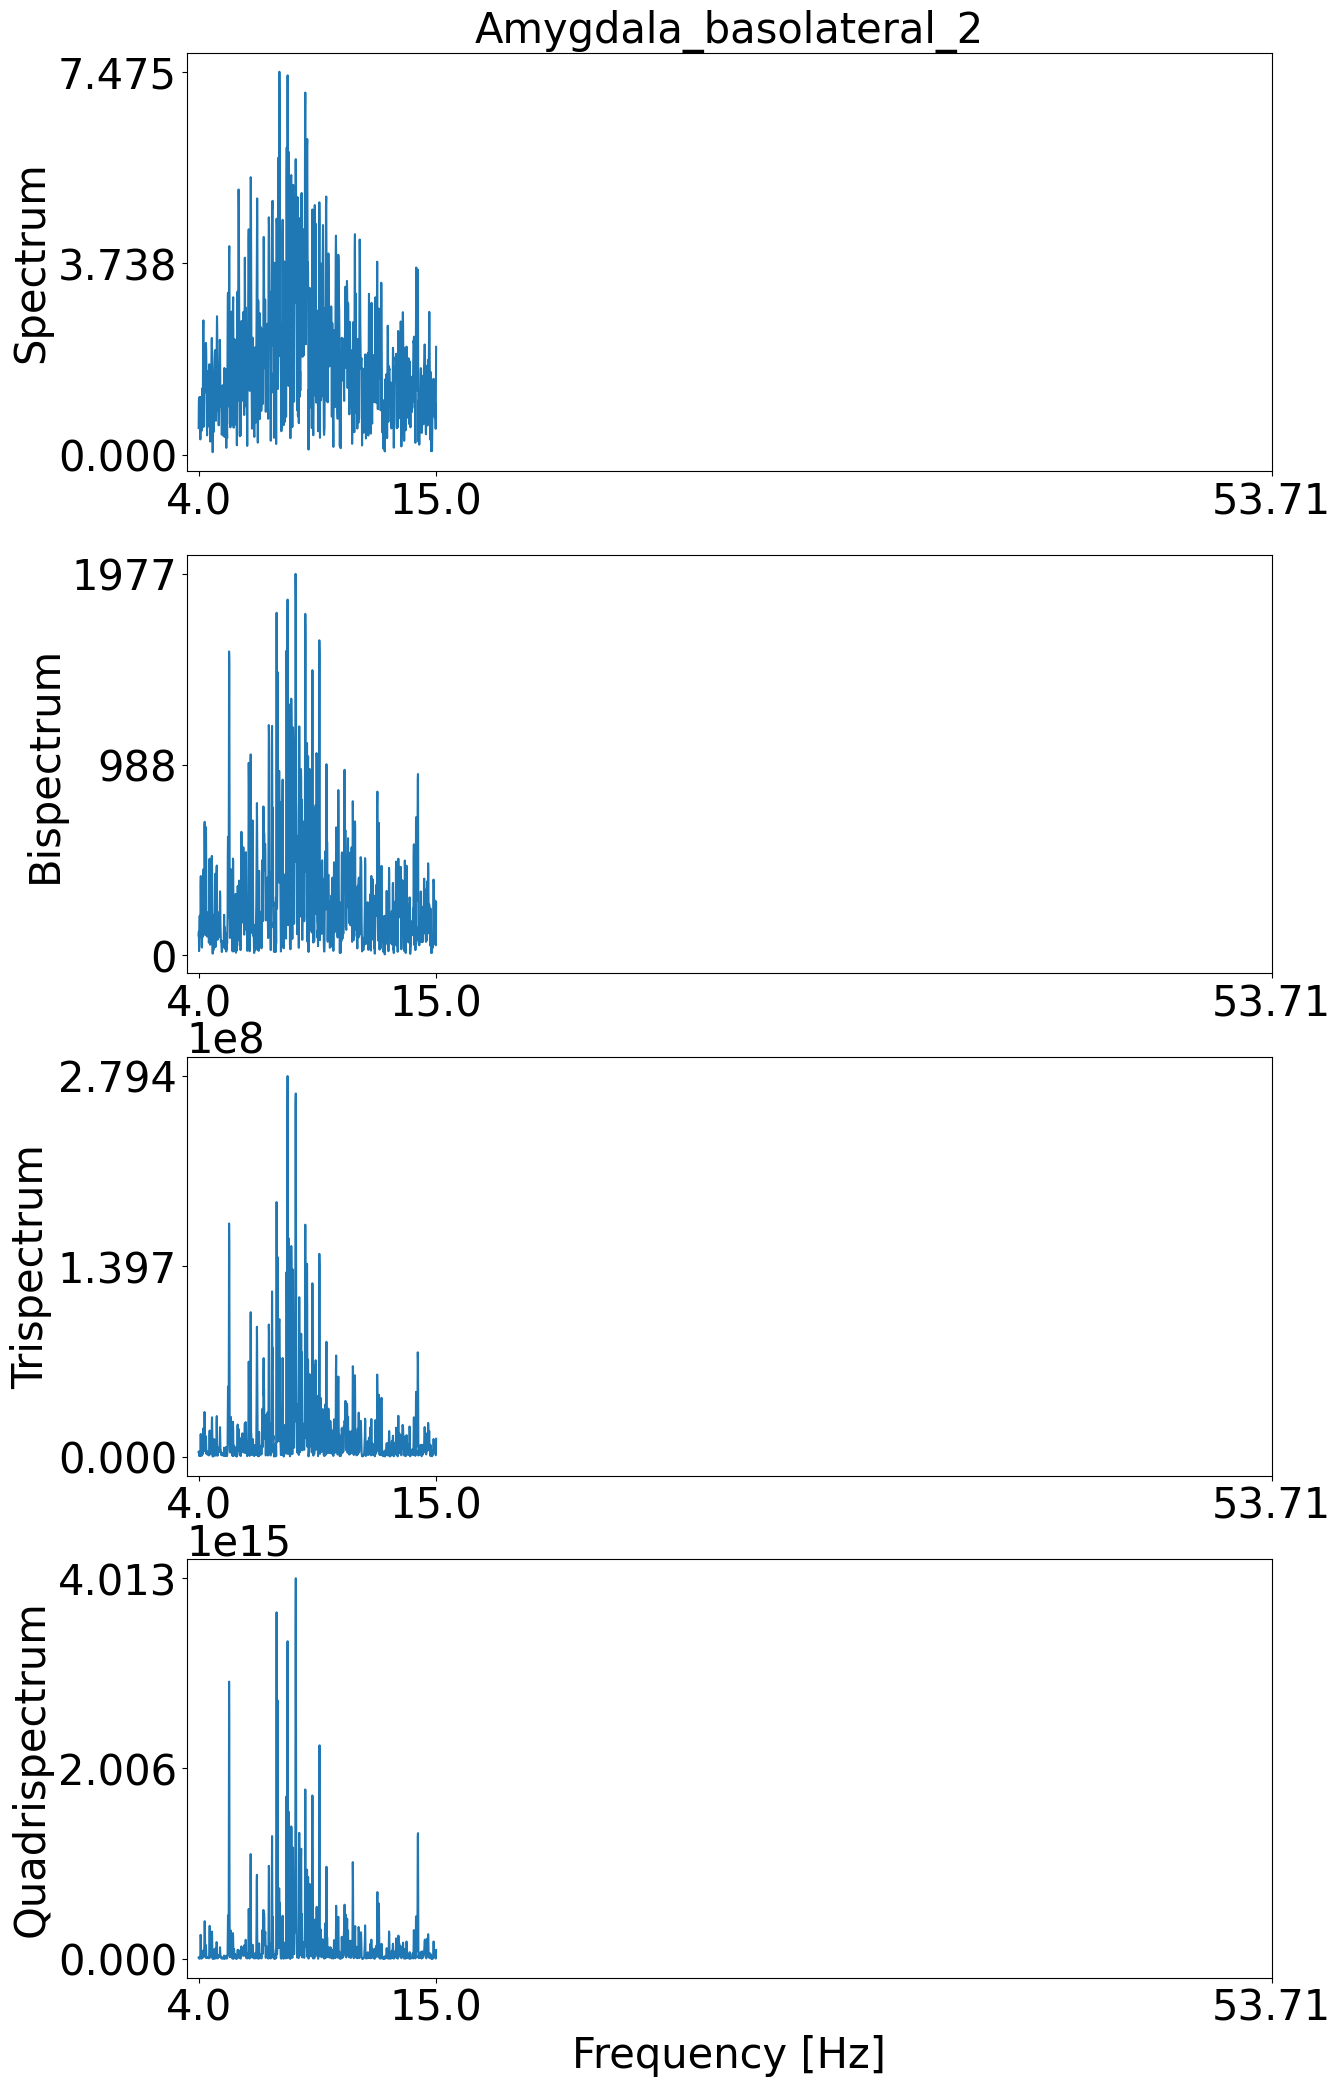

####################################################################################################


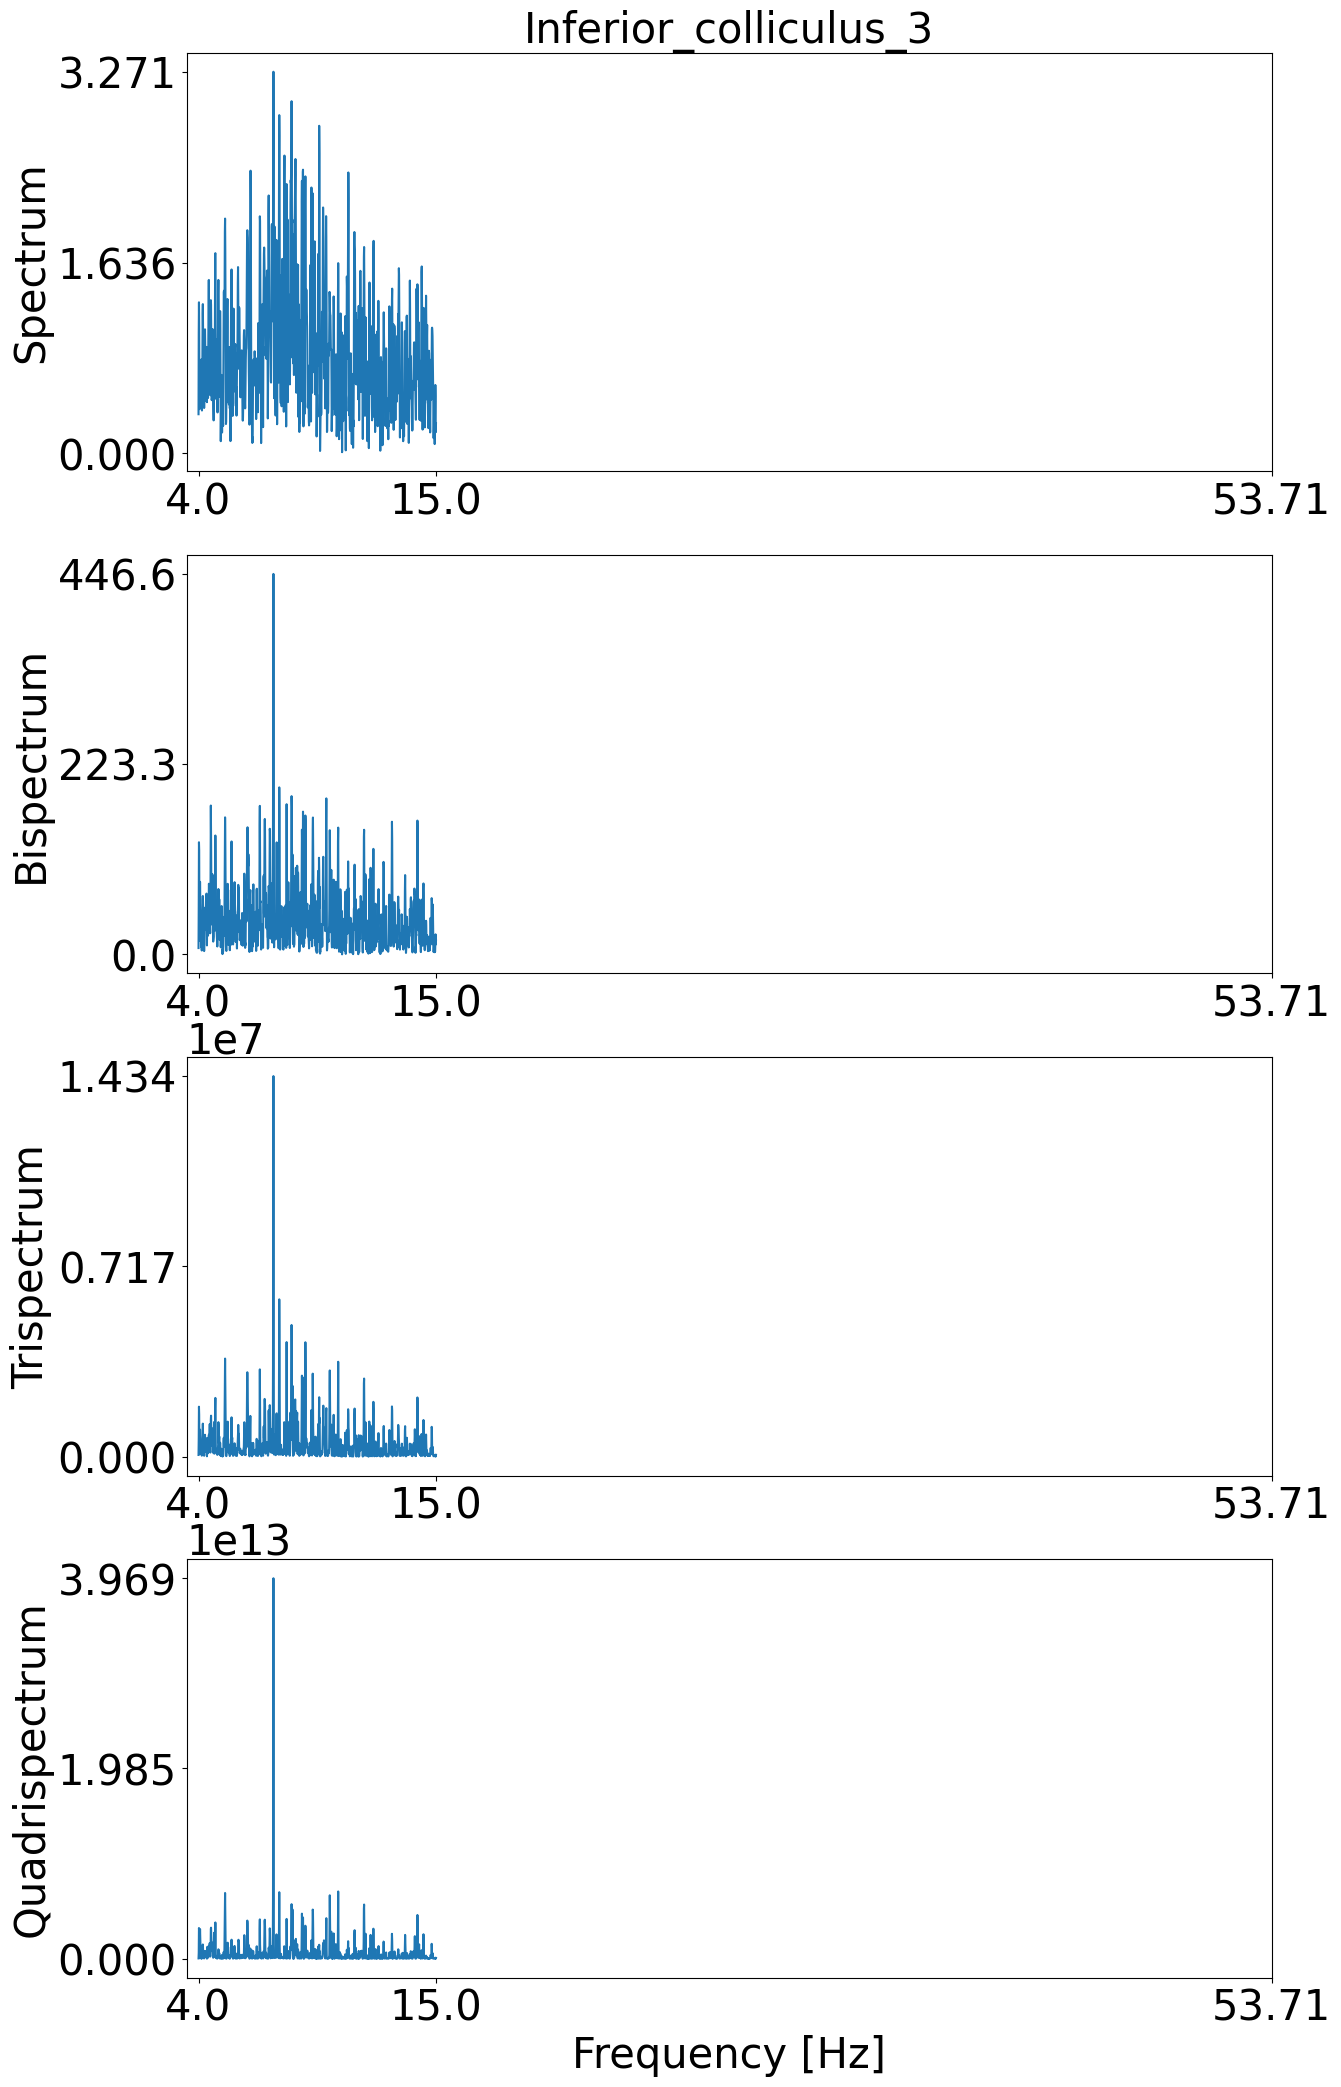

####################################################################################################


In [46]:
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)


freq_array = hosa_df.loc[(hosa_df.frequency>=(lim or [0, 100])[0])&(hosa_df.frequency<=(lim or [0, 100])[1]), "frequency"].to_numpy()

for column in columns[1:]:
    y_spectrum = hosa_df.loc[(hosa_df.frequency>=(lim or [4, 60])[0])&(hosa_df.frequency<=(lim or [4, 60])[1]), f"tds_amp_{column}"].to_numpy()
    y_bispectrum = hosa_df.loc[(hosa_df.frequency>=(lim or [4, 60])[0])&(hosa_df.frequency<=(lim or [4, 60])[1]), f"tdbs_amp_{column}"].to_numpy()
    y_trispectrum = hosa_df.loc[(hosa_df.frequency>=(lim or [4, 60])[0])&(hosa_df.frequency<=(lim or [4, 60])[1]), f"tdts_amp_{column}"].to_numpy()
    y_quadrispectrum = hosa_df.loc[(hosa_df.frequency>=(lim or [4, 60])[0])&(hosa_df.frequency<=(lim or [4, 60])[1]), f"tdqs_amp_{column}"].to_numpy()

    fig = plt.figure(figsize=(14,25))

    plt.subplot(411)
    plt.title(column)
    plt.plot(freq_array, y_spectrum)
    plt.ylabel("Spectrum")
    y_ticks = np.array([0, y_spectrum.max()/2, y_spectrum.max()])
    plt.yticks(y_ticks)
    plt.xticks(ticks=ticks, labels=labels)

    plt.subplot(412)
    plt.plot(freq_array, y_bispectrum)
    plt.ylabel("Bispectrum")
    y_ticks = np.array([0, y_bispectrum.max()/2, y_bispectrum.max()])
    plt.yticks(y_ticks)
    plt.xticks(ticks=ticks, labels=labels)

    plt.subplot(413)
    plt.plot(freq_array, y_trispectrum)
    plt.ylabel("Trispectrum")
    y_ticks = np.array([0, y_trispectrum.max()/2, y_trispectrum.max()])
    plt.yticks(y_ticks)
    plt.xticks(ticks=ticks, labels=labels)

    plt.subplot(414)
    plt.plot(freq_array, y_quadrispectrum)
    plt.ylabel("Quadrispectrum")
    y_ticks = np.array([0, y_quadrispectrum.max()/2, y_quadrispectrum.max()])
    plt.yticks(y_ticks)
    plt.xticks(ticks=ticks, labels=labels)

    plt.xlabel("Frequency [Hz]")
    plt.savefig(
        f"{'with_zoom'*zoom + 'without_zoom'*(not zoom)}/hosa_{id_file}_{id_results}_{column}_{'zoom'*(lim is not None)}.jpg",
        format="jpg",
        bbox_inches='tight', 
        dpi=150
    )

    plt.show()

    print(f"#"*100)

# Selecting Data to model - EVENT 4

In [47]:
event_number = 4
id_results: str = f"event_{event_number}"

event_data = select_event_window(
    df=data_backup, 
    event_name=f"event_{event_number}", 
    samples_before=0, 
    samples_after=0,
    freezing=False
)

In [48]:
frequency_array = np.arange(start=4, stop=60, step=0.01)

TDQS_PARAMETERS = {
    "frequency_array": frequency_array,
    "phase_step": 0.01
}

tdqs_object = TDQS(
    frequency_sampling=FrequencySampling,
    frequency_array=TDQS_PARAMETERS.get("frequency_array"),
    fmin=TDQS_PARAMETERS.get("fmin"),
    fmax=TDQS_PARAMETERS.get("fmax"),
    freq_step=TDQS_PARAMETERS.get("freq_step"),
    phase_step=TDQS_PARAMETERS["phase_step"]
)

In [49]:
path_files = f'{os.getcwd()}/hosa_{id_file}_{id_results}.csv'
load_already_calculated: bool = os.path.isfile(path_files)
if load_already_calculated:
    logger.info("HOSA already calculated. Loading...")
    hosa_df = pd.read_csv(path_files)
    logger.success("HOSA loaded!")

else:
    logger.info("HOSA not calculated yet. Generating hosa...")
    logger.info(f"\nProcessing event {event_number}")

    spectrum_df_amps = pd.DataFrame()
    spectrum_df_phases = pd.DataFrame()

    bispectrum_df_amps = pd.DataFrame()
    bispectrum_df_phases = pd.DataFrame()

    trispectrum_df_amps = pd.DataFrame()
    trispectrum_df_phases = pd.DataFrame()

    quadrispectrum_df_amps = pd.DataFrame()
    quadrispectrum_df_phases = pd.DataFrame()

    hosa_df = pd.DataFrame()

    logger.info("Processing the tdqs... This may take a while...\n")
    start_time = perf_counter()

    # Process the tdbs for each channel, in parallel

    f = lambda x: tdqs_object.run_td4spectrum(x)
    channels_columns = columns[1:]

    with Pool() as pool:

        for result in pool.map(f, [{column: event_data.loc[: , column].to_numpy()} for column in channels_columns]):
            column, result_data = list(result.items())[0]
            (
                frequency_array, 
                spectrum, 
                phase_spectrum, 
                bispectrum, 
                phase_bispectrum, 
                trispectrum, 
                phase_trispectrum, 
                tetraspectrum, 
                phase_tetraspectrum
            ) = result_data

            if (
                "frequency" not in spectrum_df_amps.columns or 
                "frequency" not in bispectrum_df_amps.columns or
                "frequency" not in hosa_df
            ):
                spectrum_df_amps = spectrum_df_amps.assign(frequency=frequency_array)
                bispectrum_df_amps = bispectrum_df_amps.assign(frequency=frequency_array)
                hosa_df =hosa_df.assign(frequency=frequency_array)


            spectrum_df_amps = spectrum_df_amps.assign(**{f"tds_amp_{column}": spectrum})
            spectrum_df_phases = spectrum_df_phases.assign(**{f"tds_phase_{column}": phase_spectrum})

            bispectrum_df_amps = bispectrum_df_amps.assign(**{f"tdbs_amp_{column}": bispectrum})
            bispectrum_df_phases = bispectrum_df_phases.assign(**{f"tdbs_phase_{column}": phase_bispectrum})

            trispectrum_df_amps = bispectrum_df_amps.assign(**{f"tdts_amp_{column}": trispectrum})
            trispectrum_df_phases = bispectrum_df_phases.assign(**{f"tdts_phase_{column}": phase_trispectrum})

            quadrispectrum_df_amps = bispectrum_df_amps.assign(**{f"tdqs_amp_{column}": tetraspectrum})
            quadrispectrum_df_phases = bispectrum_df_phases.assign(**{f"tdqs_phase_{column}": phase_tetraspectrum})

            hosa_df = hosa_df.assign(**{f"tds_amp_{column}": spectrum})
            hosa_df = hosa_df.assign(**{f"tdbs_amp_{column}": bispectrum})
            hosa_df = hosa_df.assign(**{f"tdts_amp_{column}": trispectrum})
            hosa_df = hosa_df.assign(**{f"tdqs_amp_{column}": tetraspectrum})


    spectrum_df = pd.concat([spectrum_df_amps, spectrum_df_phases], axis=1)
    bispectrum_df = pd.concat([bispectrum_df_amps, bispectrum_df_phases], axis=1)
    trispectrum_df = pd.concat([trispectrum_df_amps, trispectrum_df_phases], axis=1)
    quadrispectrum_df = pd.concat([quadrispectrum_df_amps, quadrispectrum_df_phases], axis=1)

    hosa_df.to_csv(f'{os.getcwd()}/hosa_{id_file}_{id_results}.csv', index=False)

    end_time = perf_counter()

    logger.success(f"Done. Elapsed time: {seconds_to_formatted_time(end_time - start_time)}")

2023-09-07 15:43:14.176 | INFO     | __main__:<module>:4 - HOSA already calculated. Loading...
2023-09-07 15:43:14.194 | SUCCESS  | __main__:<module>:6 - HOSA loaded!


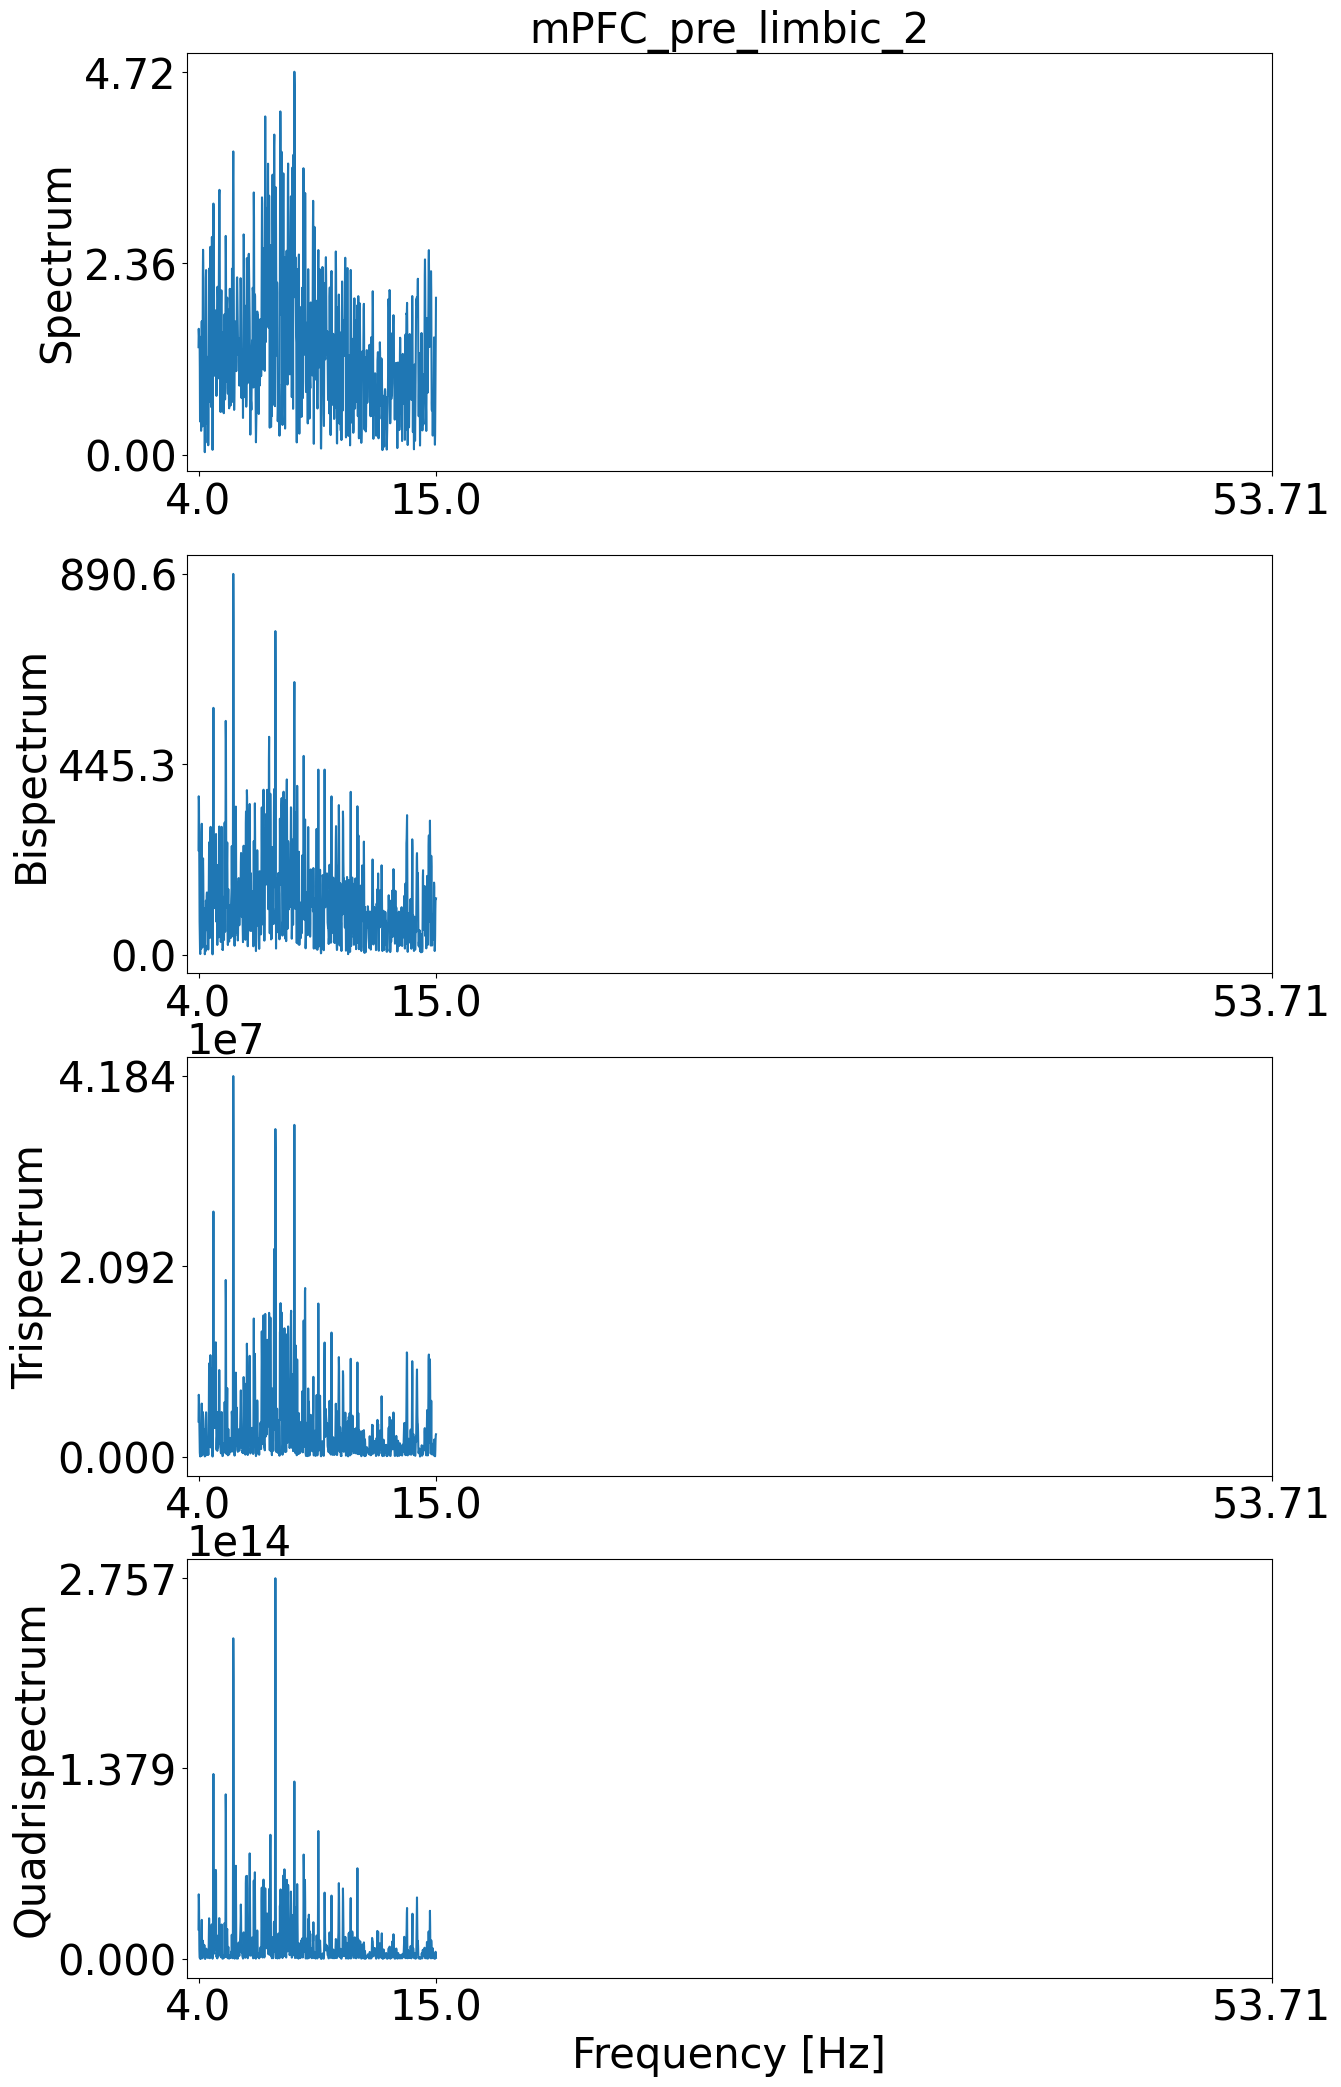

####################################################################################################


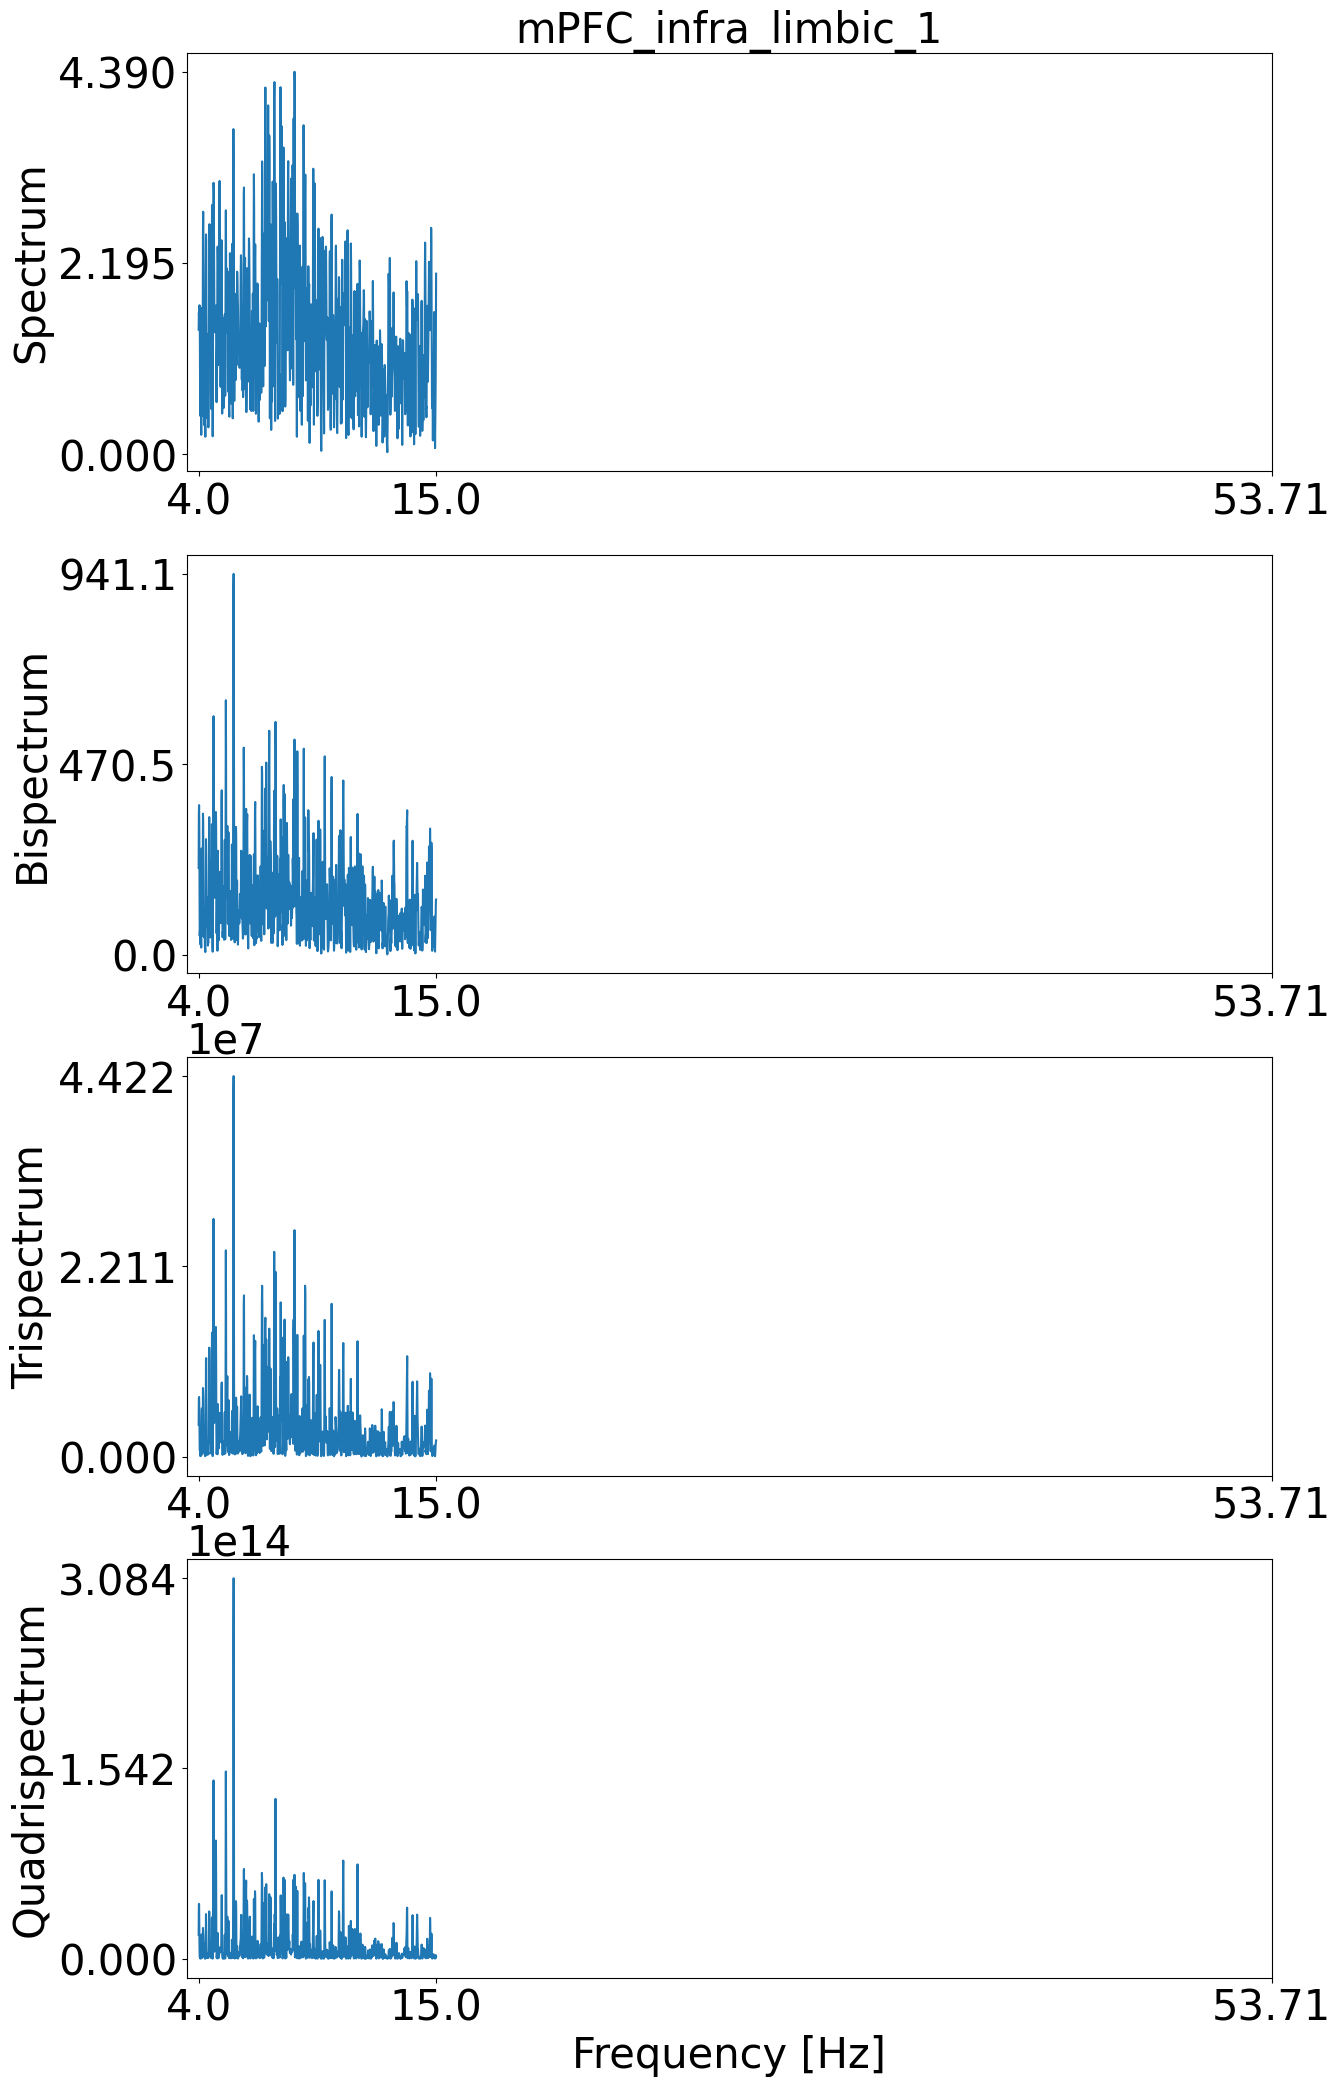

####################################################################################################


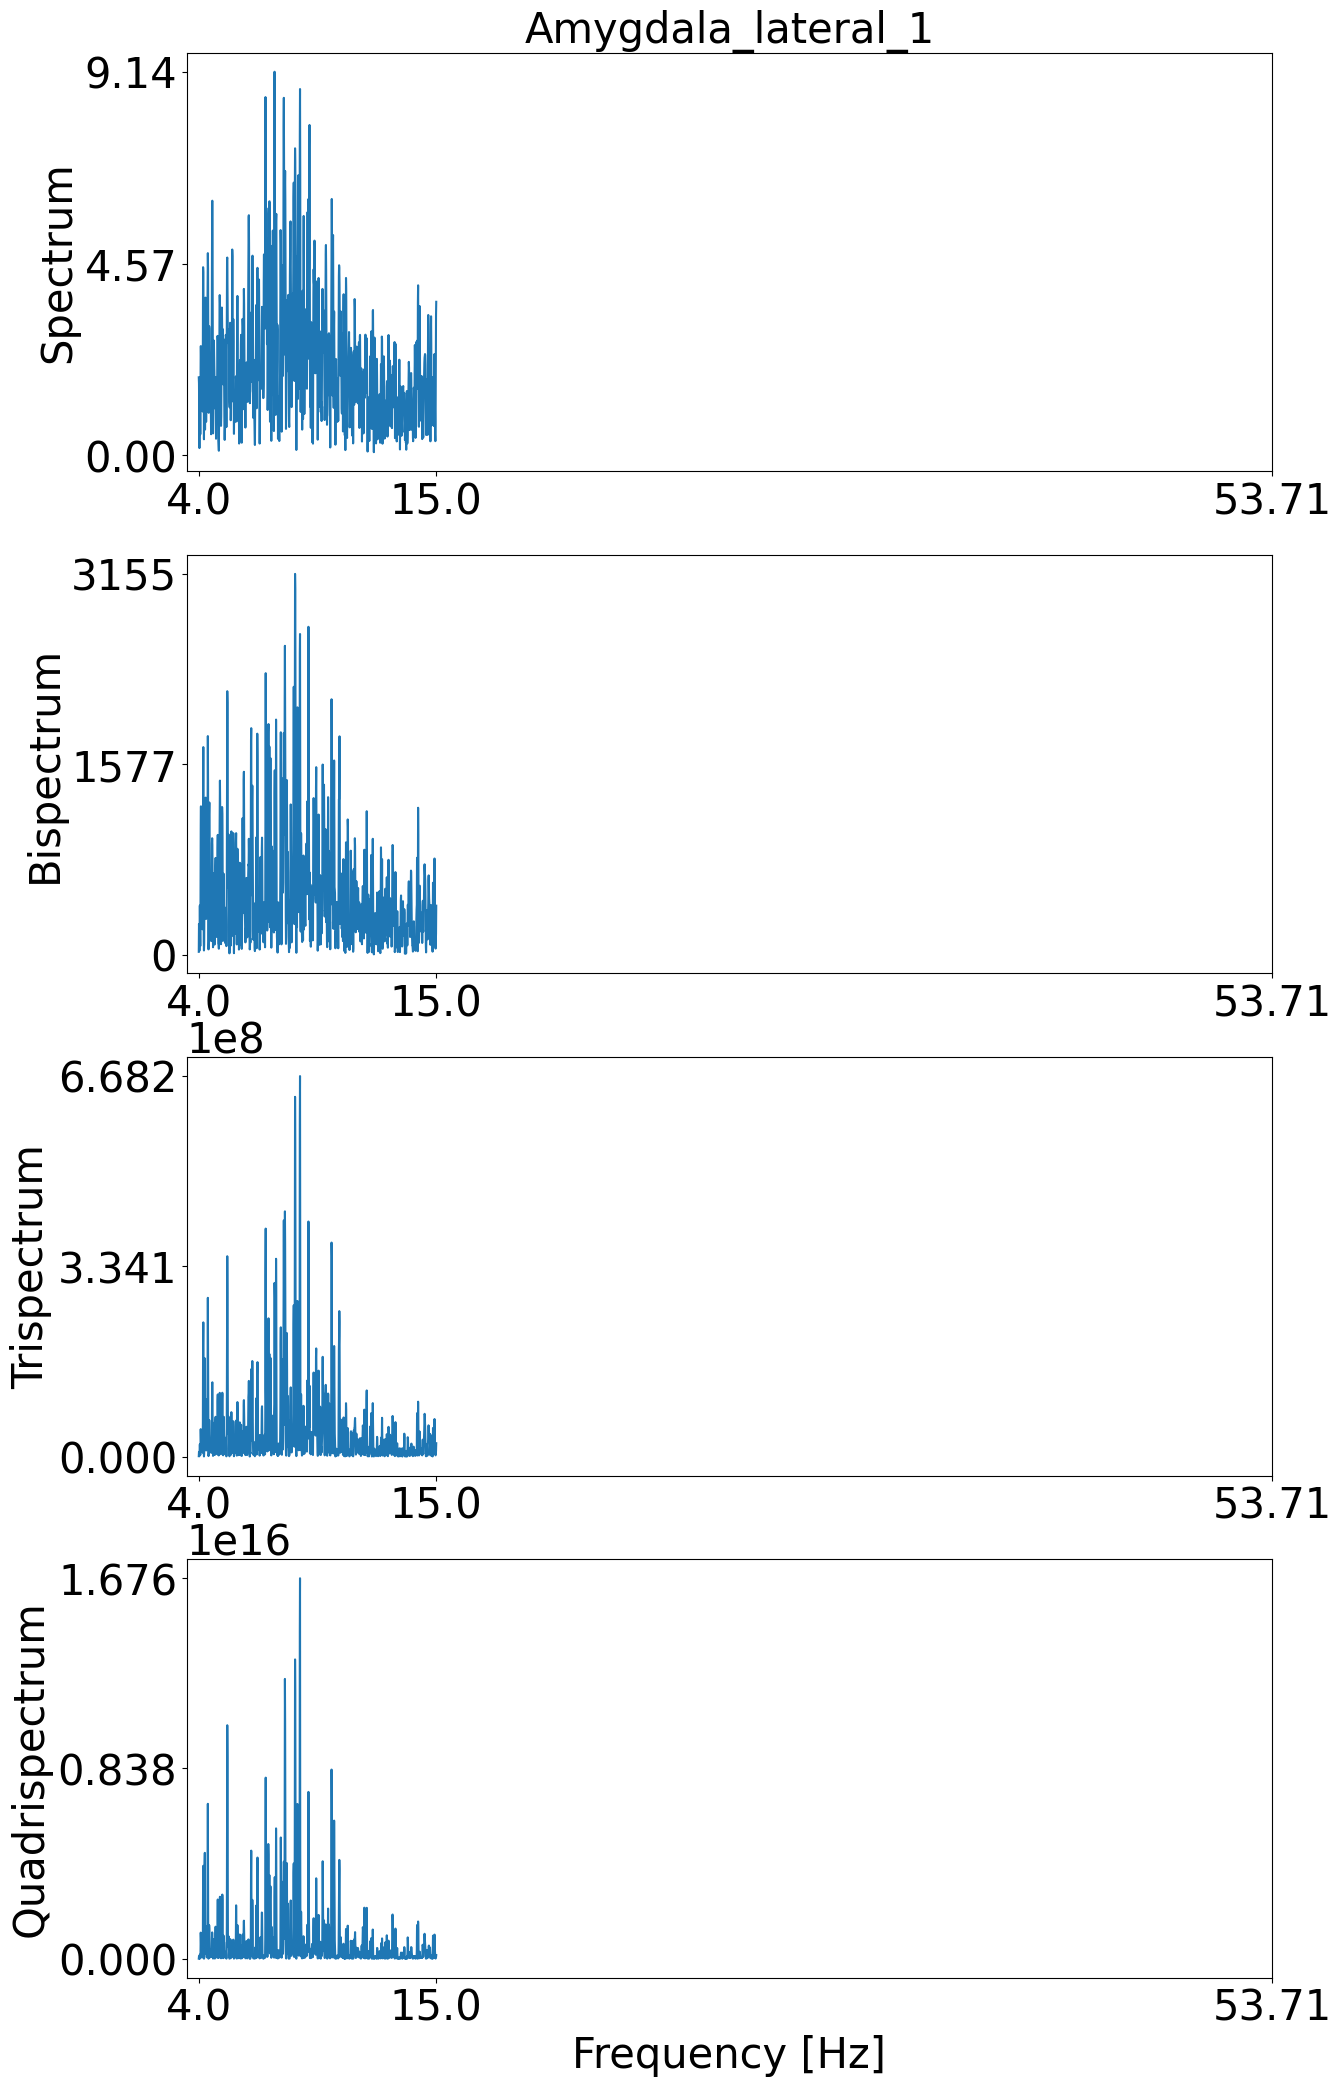

####################################################################################################


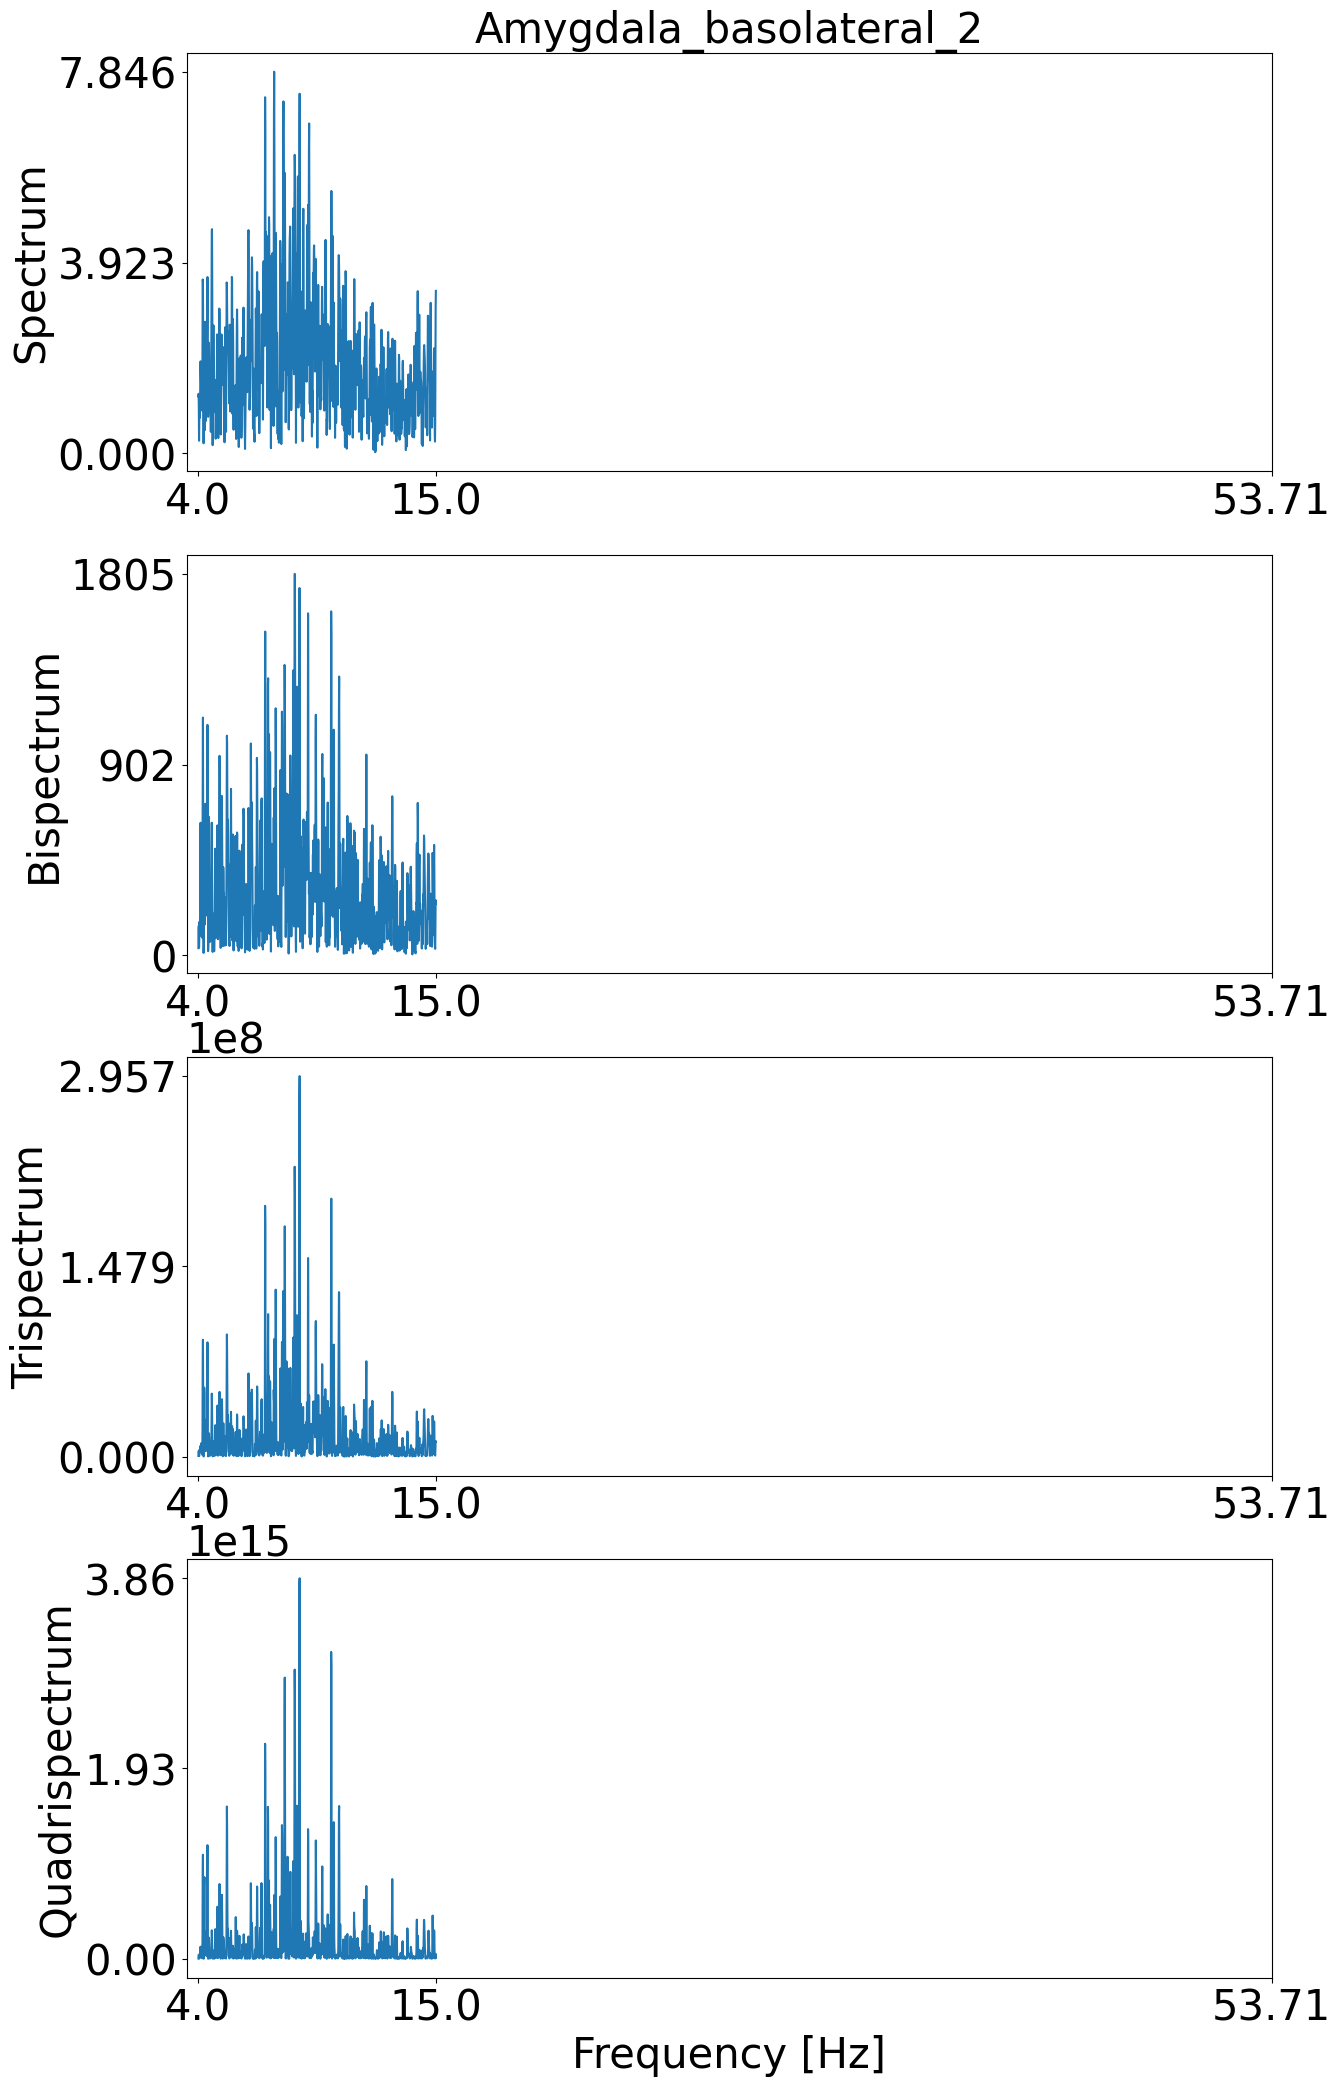

####################################################################################################


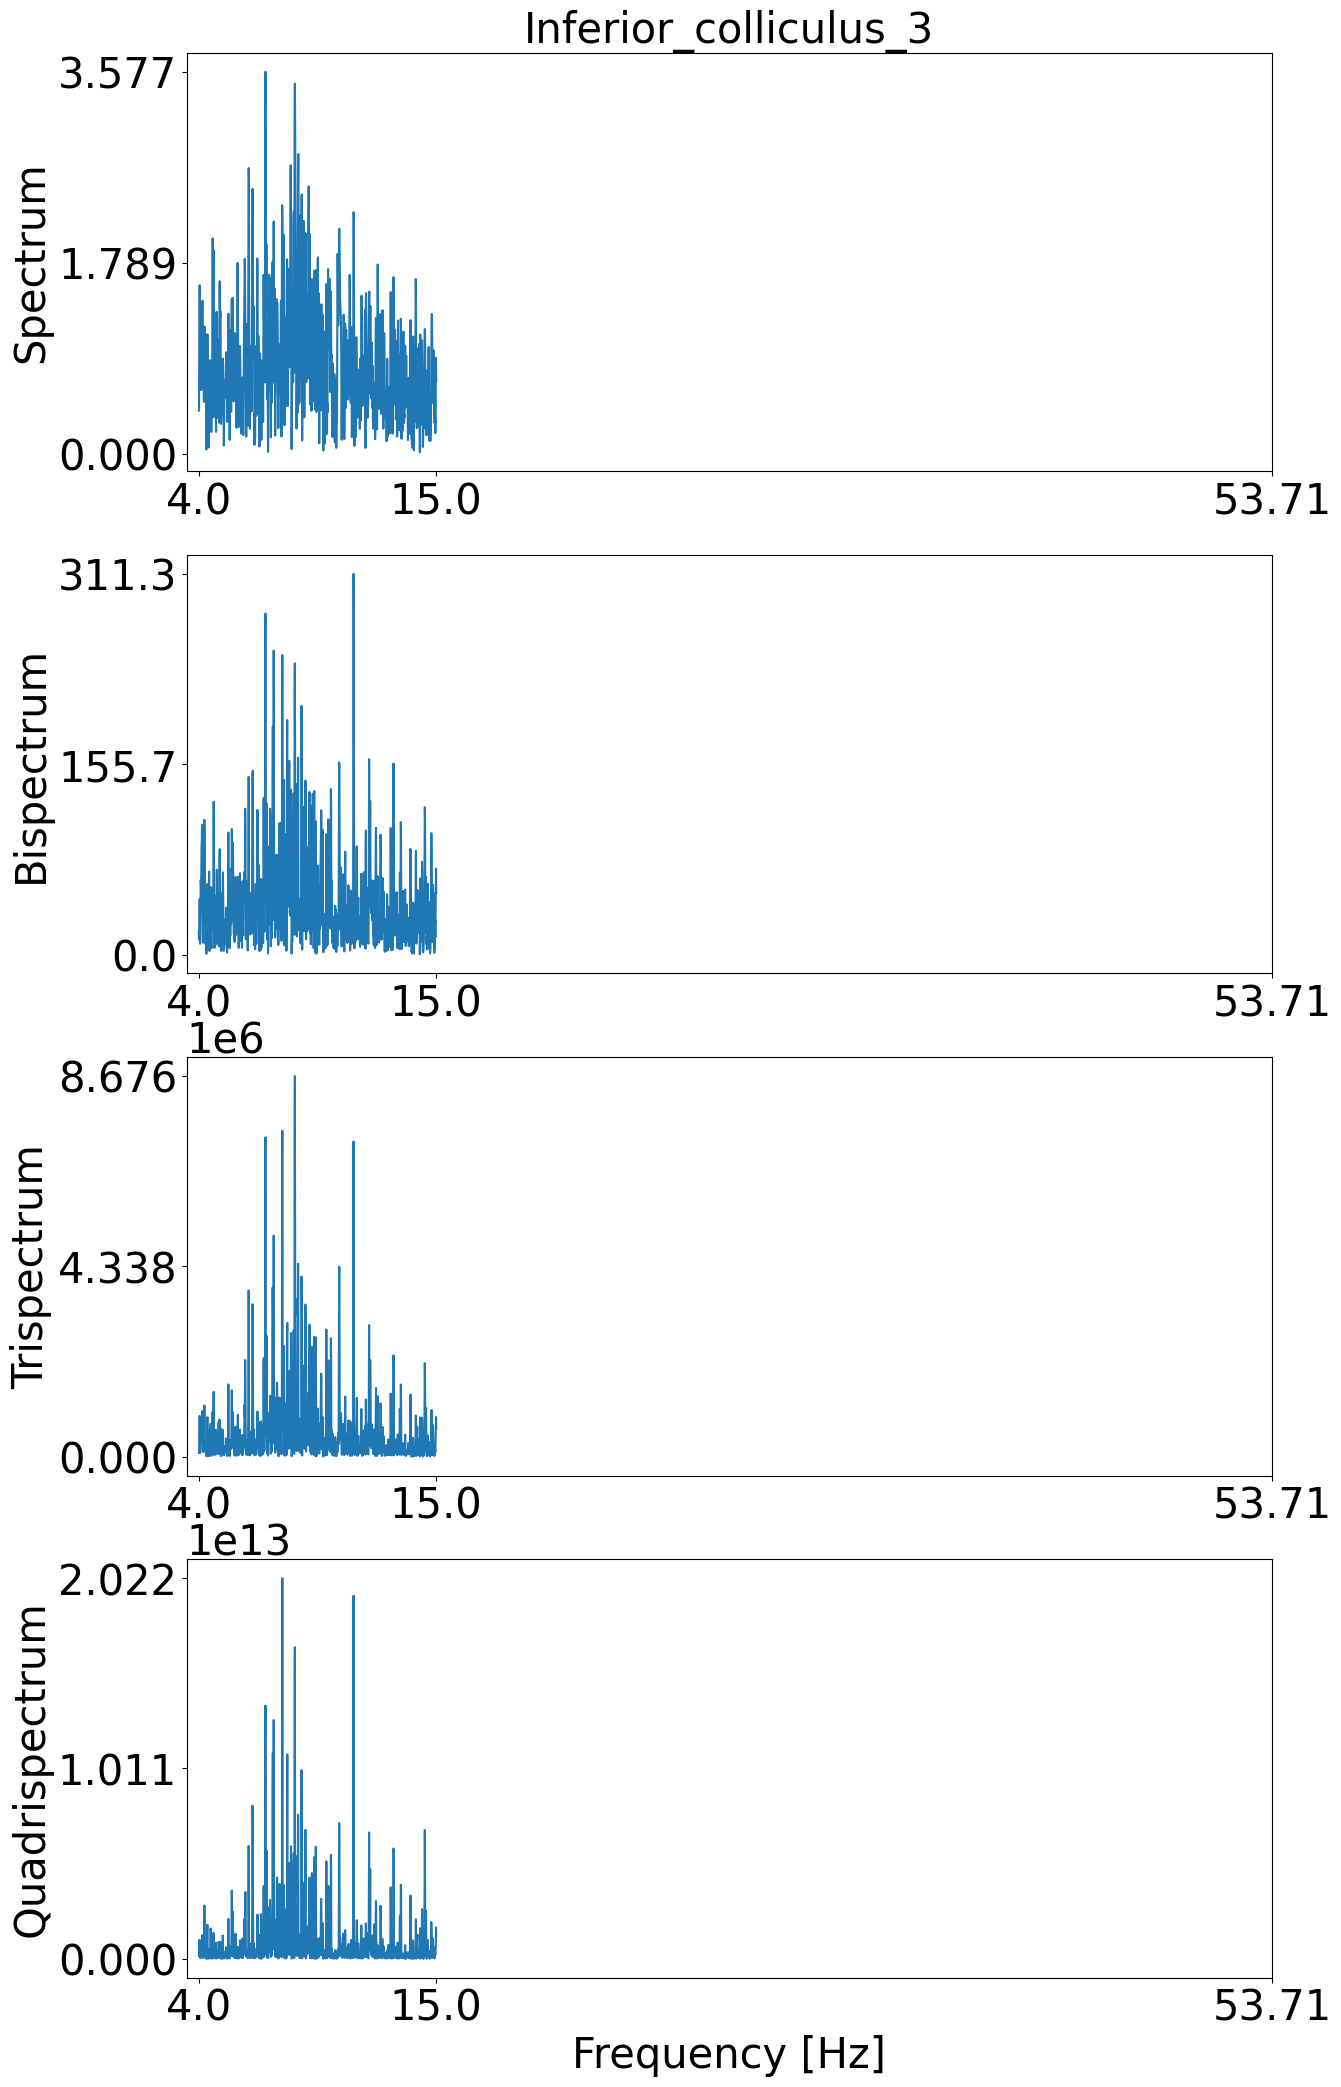

####################################################################################################


In [50]:
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)


freq_array = hosa_df.loc[(hosa_df.frequency>=(lim or [0, 100])[0])&(hosa_df.frequency<=(lim or [0, 100])[1]), "frequency"].to_numpy()

for column in columns[1:]:
    y_spectrum = hosa_df.loc[(hosa_df.frequency>=(lim or [4, 60])[0])&(hosa_df.frequency<=(lim or [4, 60])[1]), f"tds_amp_{column}"].to_numpy()
    y_bispectrum = hosa_df.loc[(hosa_df.frequency>=(lim or [4, 60])[0])&(hosa_df.frequency<=(lim or [4, 60])[1]), f"tdbs_amp_{column}"].to_numpy()
    y_trispectrum = hosa_df.loc[(hosa_df.frequency>=(lim or [4, 60])[0])&(hosa_df.frequency<=(lim or [4, 60])[1]), f"tdts_amp_{column}"].to_numpy()
    y_quadrispectrum = hosa_df.loc[(hosa_df.frequency>=(lim or [4, 60])[0])&(hosa_df.frequency<=(lim or [4, 60])[1]), f"tdqs_amp_{column}"].to_numpy()

    fig = plt.figure(figsize=(14,25))

    plt.subplot(411)
    plt.title(column)
    plt.plot(freq_array, y_spectrum)
    plt.ylabel("Spectrum")
    y_ticks = np.array([0, y_spectrum.max()/2, y_spectrum.max()])
    plt.yticks(y_ticks)
    plt.xticks(ticks=ticks, labels=labels)

    plt.subplot(412)
    plt.plot(freq_array, y_bispectrum)
    plt.ylabel("Bispectrum")
    y_ticks = np.array([0, y_bispectrum.max()/2, y_bispectrum.max()])
    plt.yticks(y_ticks)
    plt.xticks(ticks=ticks, labels=labels)

    plt.subplot(413)
    plt.plot(freq_array, y_trispectrum)
    plt.ylabel("Trispectrum")
    y_ticks = np.array([0, y_trispectrum.max()/2, y_trispectrum.max()])
    plt.yticks(y_ticks)
    plt.xticks(ticks=ticks, labels=labels)

    plt.subplot(414)
    plt.plot(freq_array, y_quadrispectrum)
    plt.ylabel("Quadrispectrum")
    y_ticks = np.array([0, y_quadrispectrum.max()/2, y_quadrispectrum.max()])
    plt.yticks(y_ticks)
    plt.xticks(ticks=ticks, labels=labels)

    plt.xlabel("Frequency [Hz]")
    plt.savefig(
        f"{'with_zoom'*zoom + 'without_zoom'*(not zoom)}/hosa_{id_file}_{id_results}_{column}_{'zoom'*(lim is not None)}.jpg",
        format="jpg",
        bbox_inches='tight', 
        dpi=150
    )

    plt.show()

    print(f"#"*100)

# Selecting Data to model - EVENT 5

In [51]:
event_number = 5
id_results: str = f"event_{event_number}"

event_data = select_event_window(
    df=data_backup, 
    event_name=f"event_{event_number}", 
    samples_before=0, 
    samples_after=0,
    freezing=False
)

In [52]:
frequency_array = np.arange(start=4, stop=60, step=0.01)

TDQS_PARAMETERS = {
    "frequency_array": frequency_array,
    "phase_step": 0.01
}

tdqs_object = TDQS(
    frequency_sampling=FrequencySampling,
    frequency_array=TDQS_PARAMETERS.get("frequency_array"),
    fmin=TDQS_PARAMETERS.get("fmin"),
    fmax=TDQS_PARAMETERS.get("fmax"),
    freq_step=TDQS_PARAMETERS.get("freq_step"),
    phase_step=TDQS_PARAMETERS["phase_step"]
)

In [53]:
path_files = f'{os.getcwd()}/hosa_{id_file}_{id_results}.csv'
load_already_calculated: bool = os.path.isfile(path_files)
if load_already_calculated:
    logger.info("HOSA already calculated. Loading...")
    hosa_df = pd.read_csv(path_files)
    logger.success("HOSA loaded!")

else:
    logger.info("HOSA not calculated yet. Generating hosa...")
    logger.info(f"\nProcessing event {event_number}")

    spectrum_df_amps = pd.DataFrame()
    spectrum_df_phases = pd.DataFrame()

    bispectrum_df_amps = pd.DataFrame()
    bispectrum_df_phases = pd.DataFrame()

    trispectrum_df_amps = pd.DataFrame()
    trispectrum_df_phases = pd.DataFrame()

    quadrispectrum_df_amps = pd.DataFrame()
    quadrispectrum_df_phases = pd.DataFrame()

    hosa_df = pd.DataFrame()

    logger.info("Processing the tdqs... This may take a while...\n")
    start_time = perf_counter()

    # Process the tdbs for each channel, in parallel

    f = lambda x: tdqs_object.run_td4spectrum(x)
    channels_columns = columns[1:]

    with Pool() as pool:

        for result in pool.map(f, [{column: event_data.loc[: , column].to_numpy()} for column in channels_columns]):
            column, result_data = list(result.items())[0]
            (
                frequency_array, 
                spectrum, 
                phase_spectrum, 
                bispectrum, 
                phase_bispectrum, 
                trispectrum, 
                phase_trispectrum, 
                tetraspectrum, 
                phase_tetraspectrum
            ) = result_data

            if (
                "frequency" not in spectrum_df_amps.columns or 
                "frequency" not in bispectrum_df_amps.columns or
                "frequency" not in hosa_df
            ):
                spectrum_df_amps = spectrum_df_amps.assign(frequency=frequency_array)
                bispectrum_df_amps = bispectrum_df_amps.assign(frequency=frequency_array)
                hosa_df =hosa_df.assign(frequency=frequency_array)


            spectrum_df_amps = spectrum_df_amps.assign(**{f"tds_amp_{column}": spectrum})
            spectrum_df_phases = spectrum_df_phases.assign(**{f"tds_phase_{column}": phase_spectrum})

            bispectrum_df_amps = bispectrum_df_amps.assign(**{f"tdbs_amp_{column}": bispectrum})
            bispectrum_df_phases = bispectrum_df_phases.assign(**{f"tdbs_phase_{column}": phase_bispectrum})

            trispectrum_df_amps = bispectrum_df_amps.assign(**{f"tdts_amp_{column}": trispectrum})
            trispectrum_df_phases = bispectrum_df_phases.assign(**{f"tdts_phase_{column}": phase_trispectrum})

            quadrispectrum_df_amps = bispectrum_df_amps.assign(**{f"tdqs_amp_{column}": tetraspectrum})
            quadrispectrum_df_phases = bispectrum_df_phases.assign(**{f"tdqs_phase_{column}": phase_tetraspectrum})

            hosa_df = hosa_df.assign(**{f"tds_amp_{column}": spectrum})
            hosa_df = hosa_df.assign(**{f"tdbs_amp_{column}": bispectrum})
            hosa_df = hosa_df.assign(**{f"tdts_amp_{column}": trispectrum})
            hosa_df = hosa_df.assign(**{f"tdqs_amp_{column}": tetraspectrum})


    spectrum_df = pd.concat([spectrum_df_amps, spectrum_df_phases], axis=1)
    bispectrum_df = pd.concat([bispectrum_df_amps, bispectrum_df_phases], axis=1)
    trispectrum_df = pd.concat([trispectrum_df_amps, trispectrum_df_phases], axis=1)
    quadrispectrum_df = pd.concat([quadrispectrum_df_amps, quadrispectrum_df_phases], axis=1)

    hosa_df.to_csv(f'{os.getcwd()}/hosa_{id_file}_{id_results}.csv', index=False)

    end_time = perf_counter()

    logger.success(f"Done. Elapsed time: {seconds_to_formatted_time(end_time - start_time)}")

2023-09-07 15:43:16.918 | INFO     | __main__:<module>:4 - HOSA already calculated. Loading...
2023-09-07 15:43:16.942 | SUCCESS  | __main__:<module>:6 - HOSA loaded!


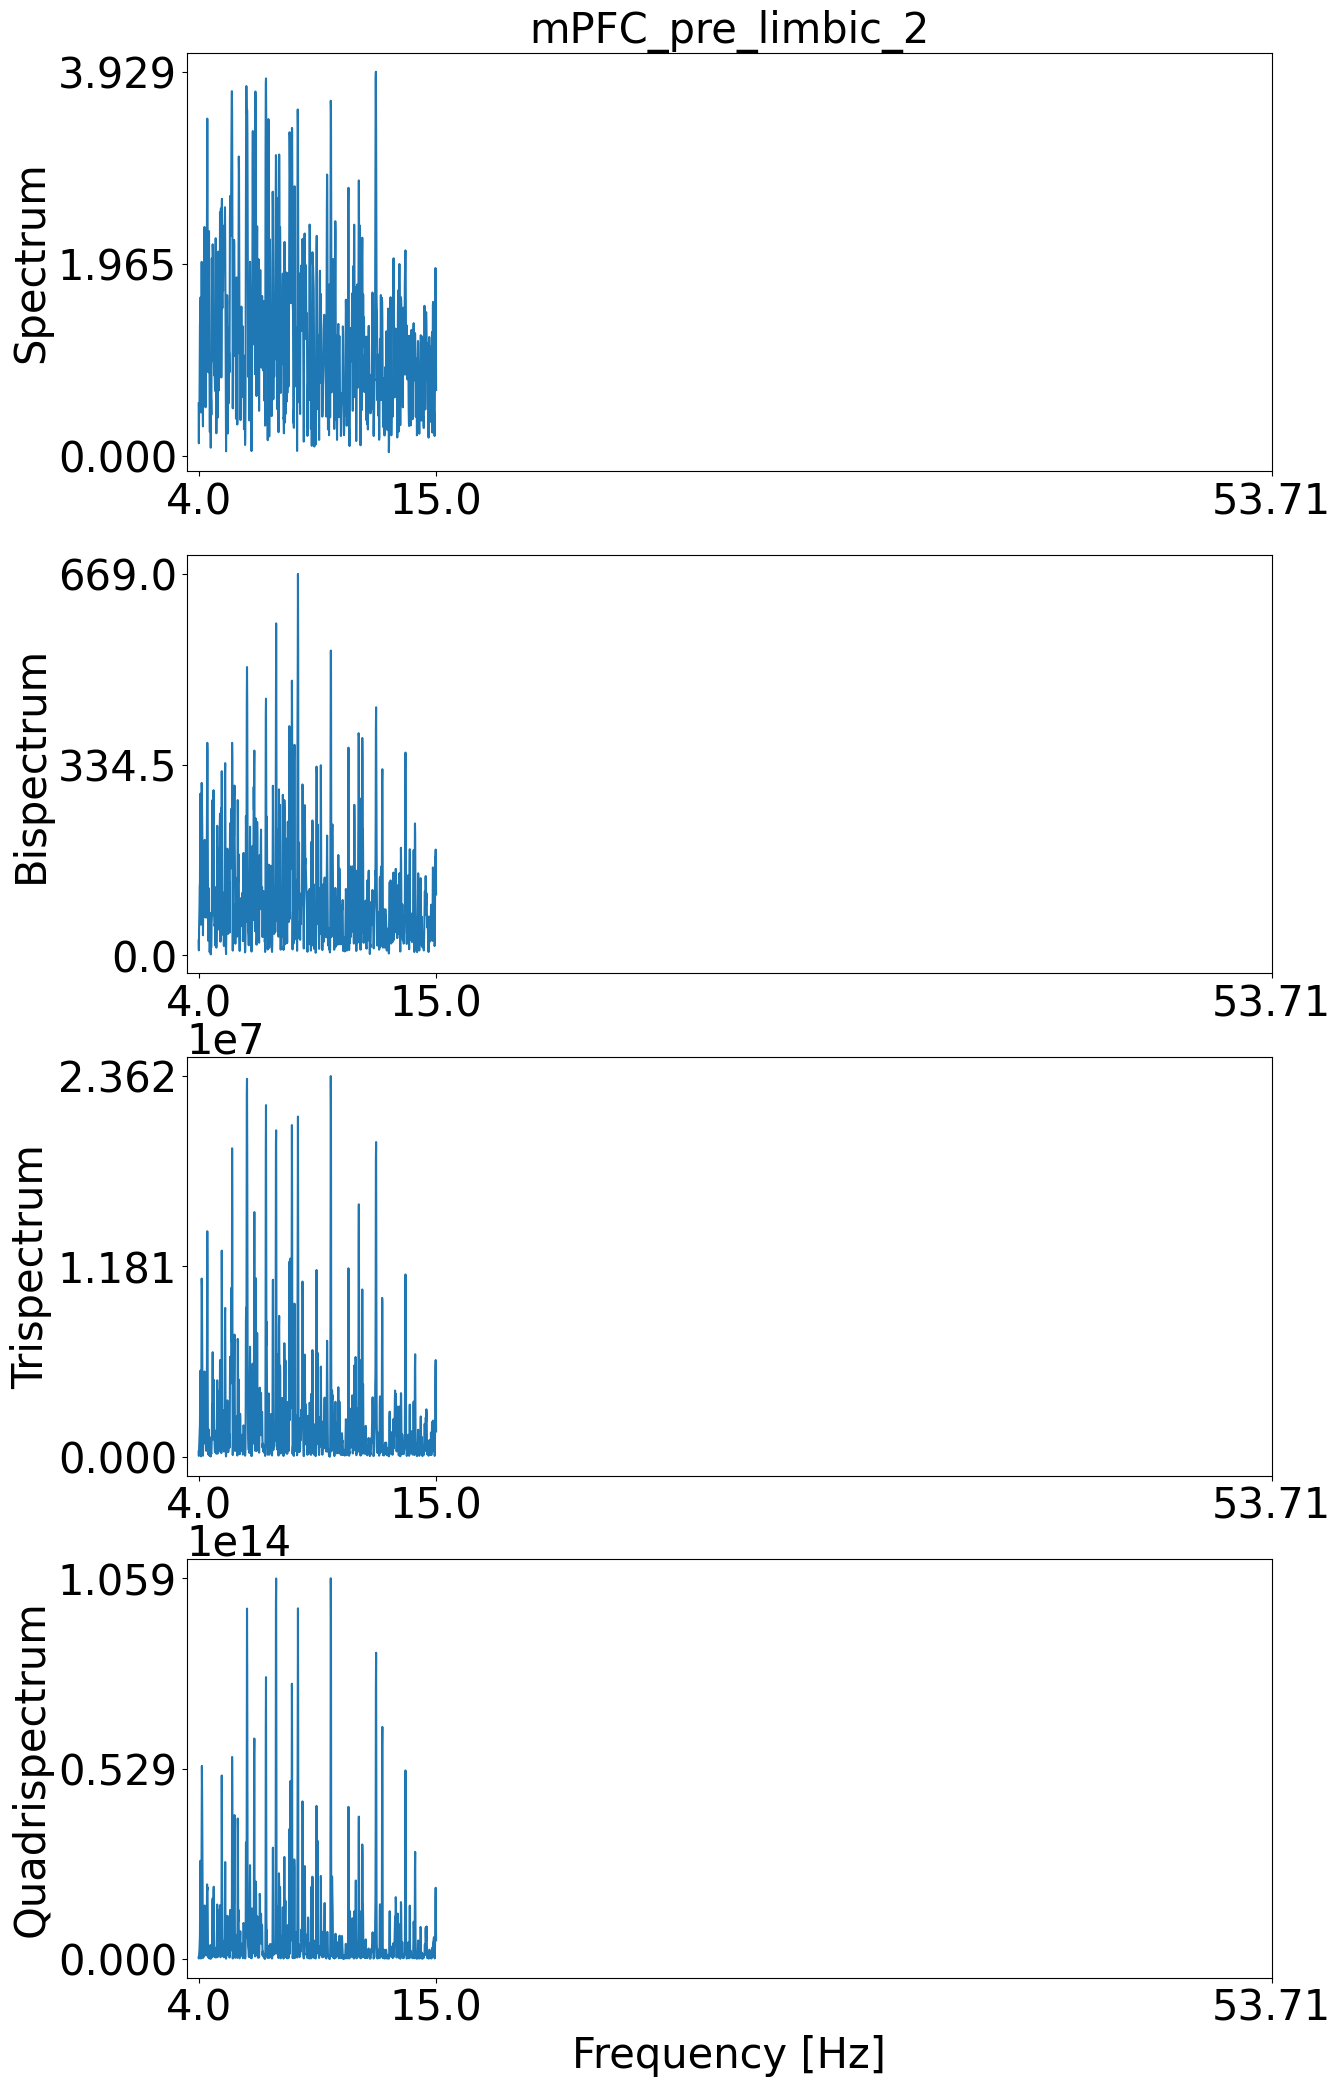

####################################################################################################


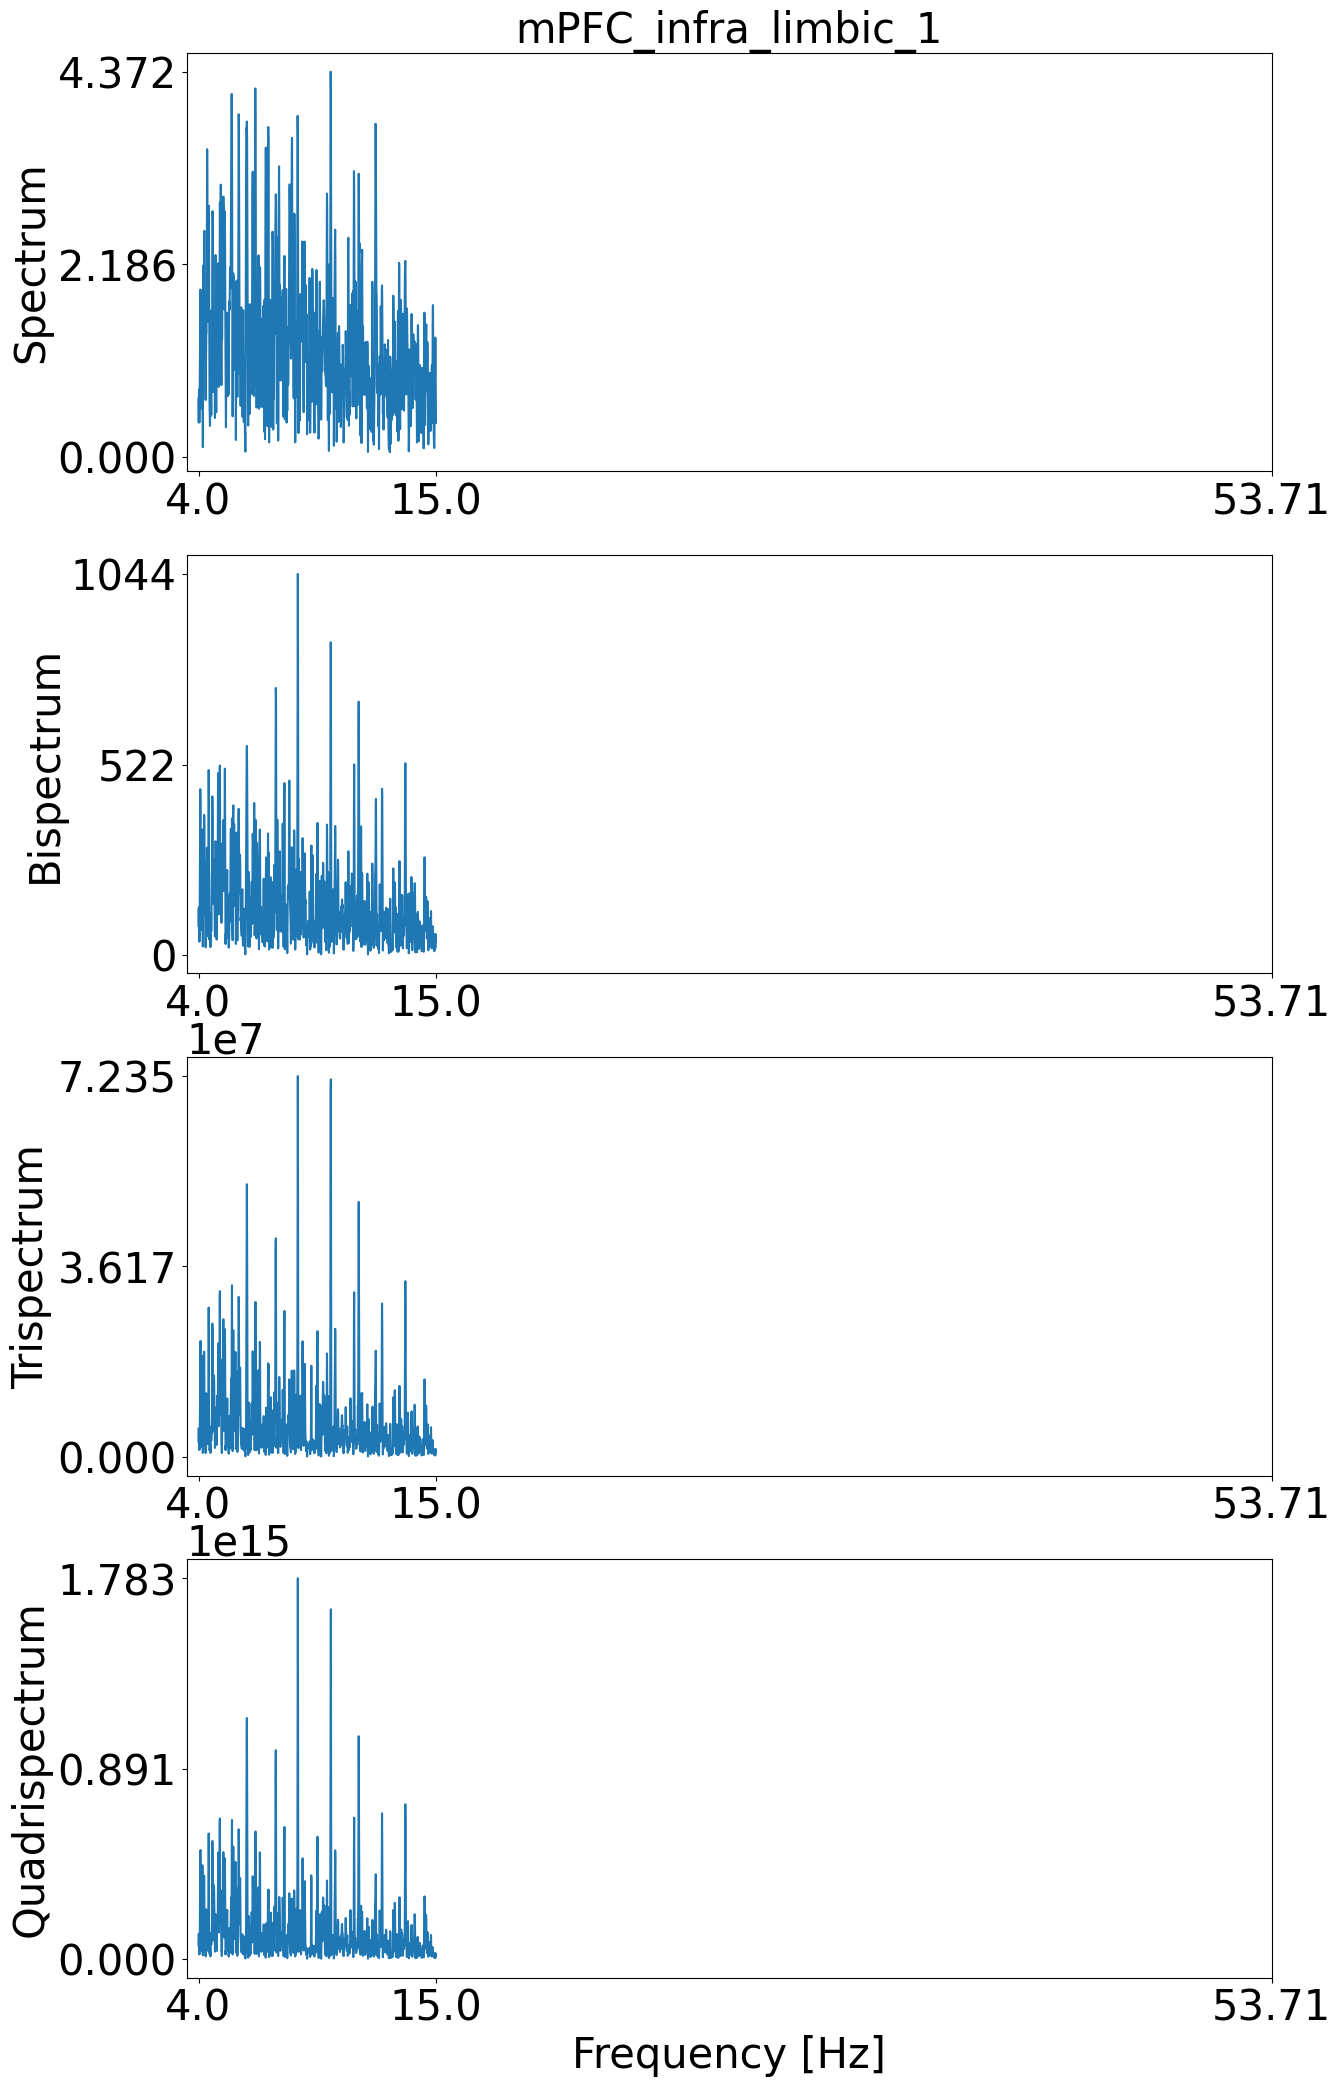

####################################################################################################


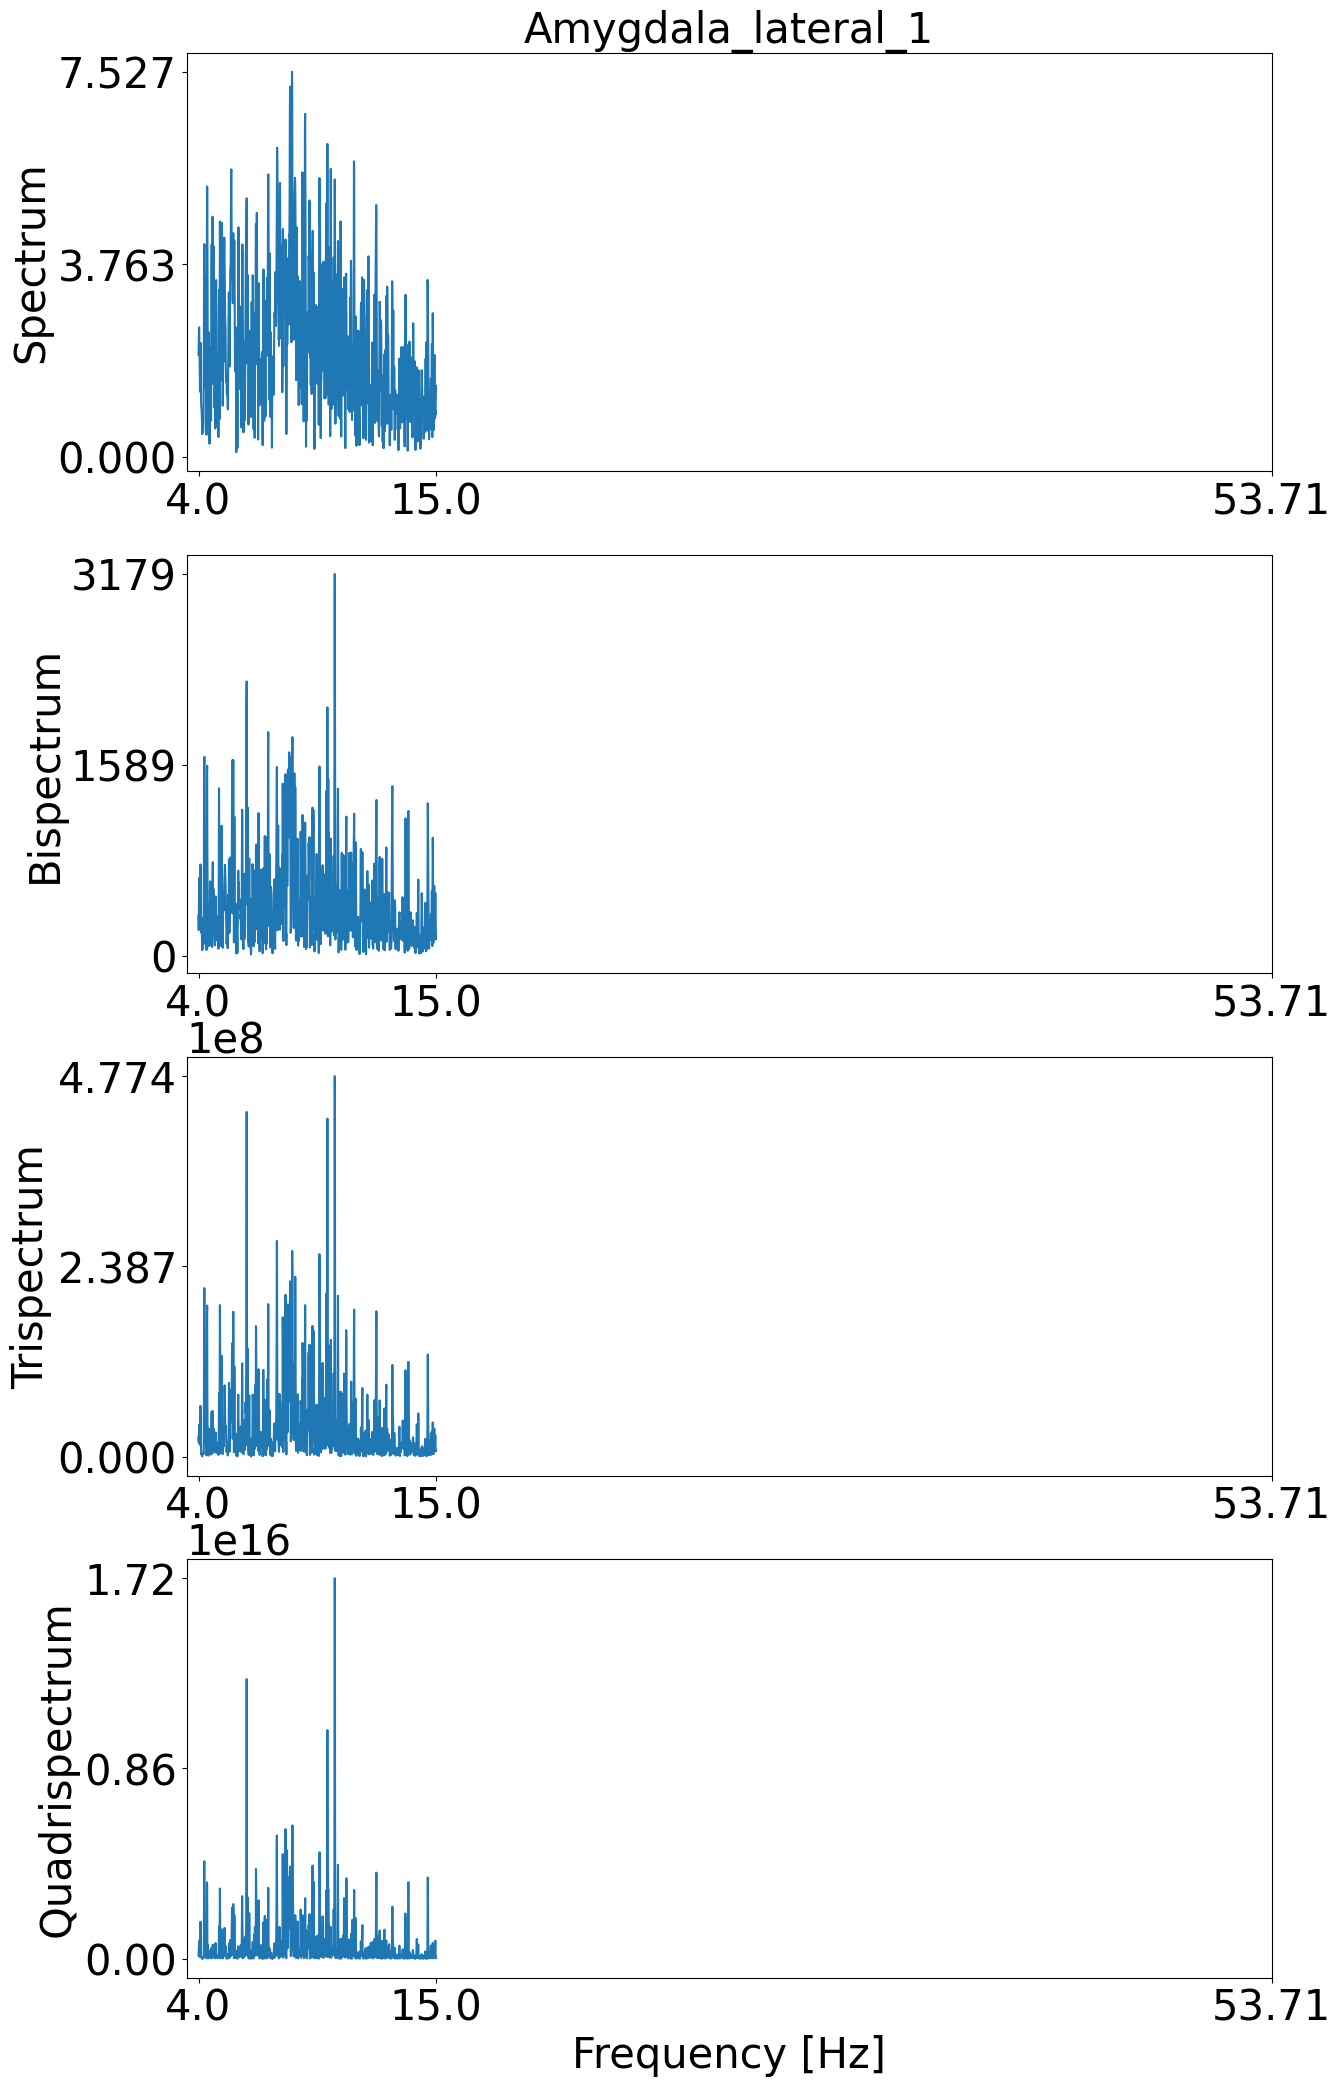

####################################################################################################


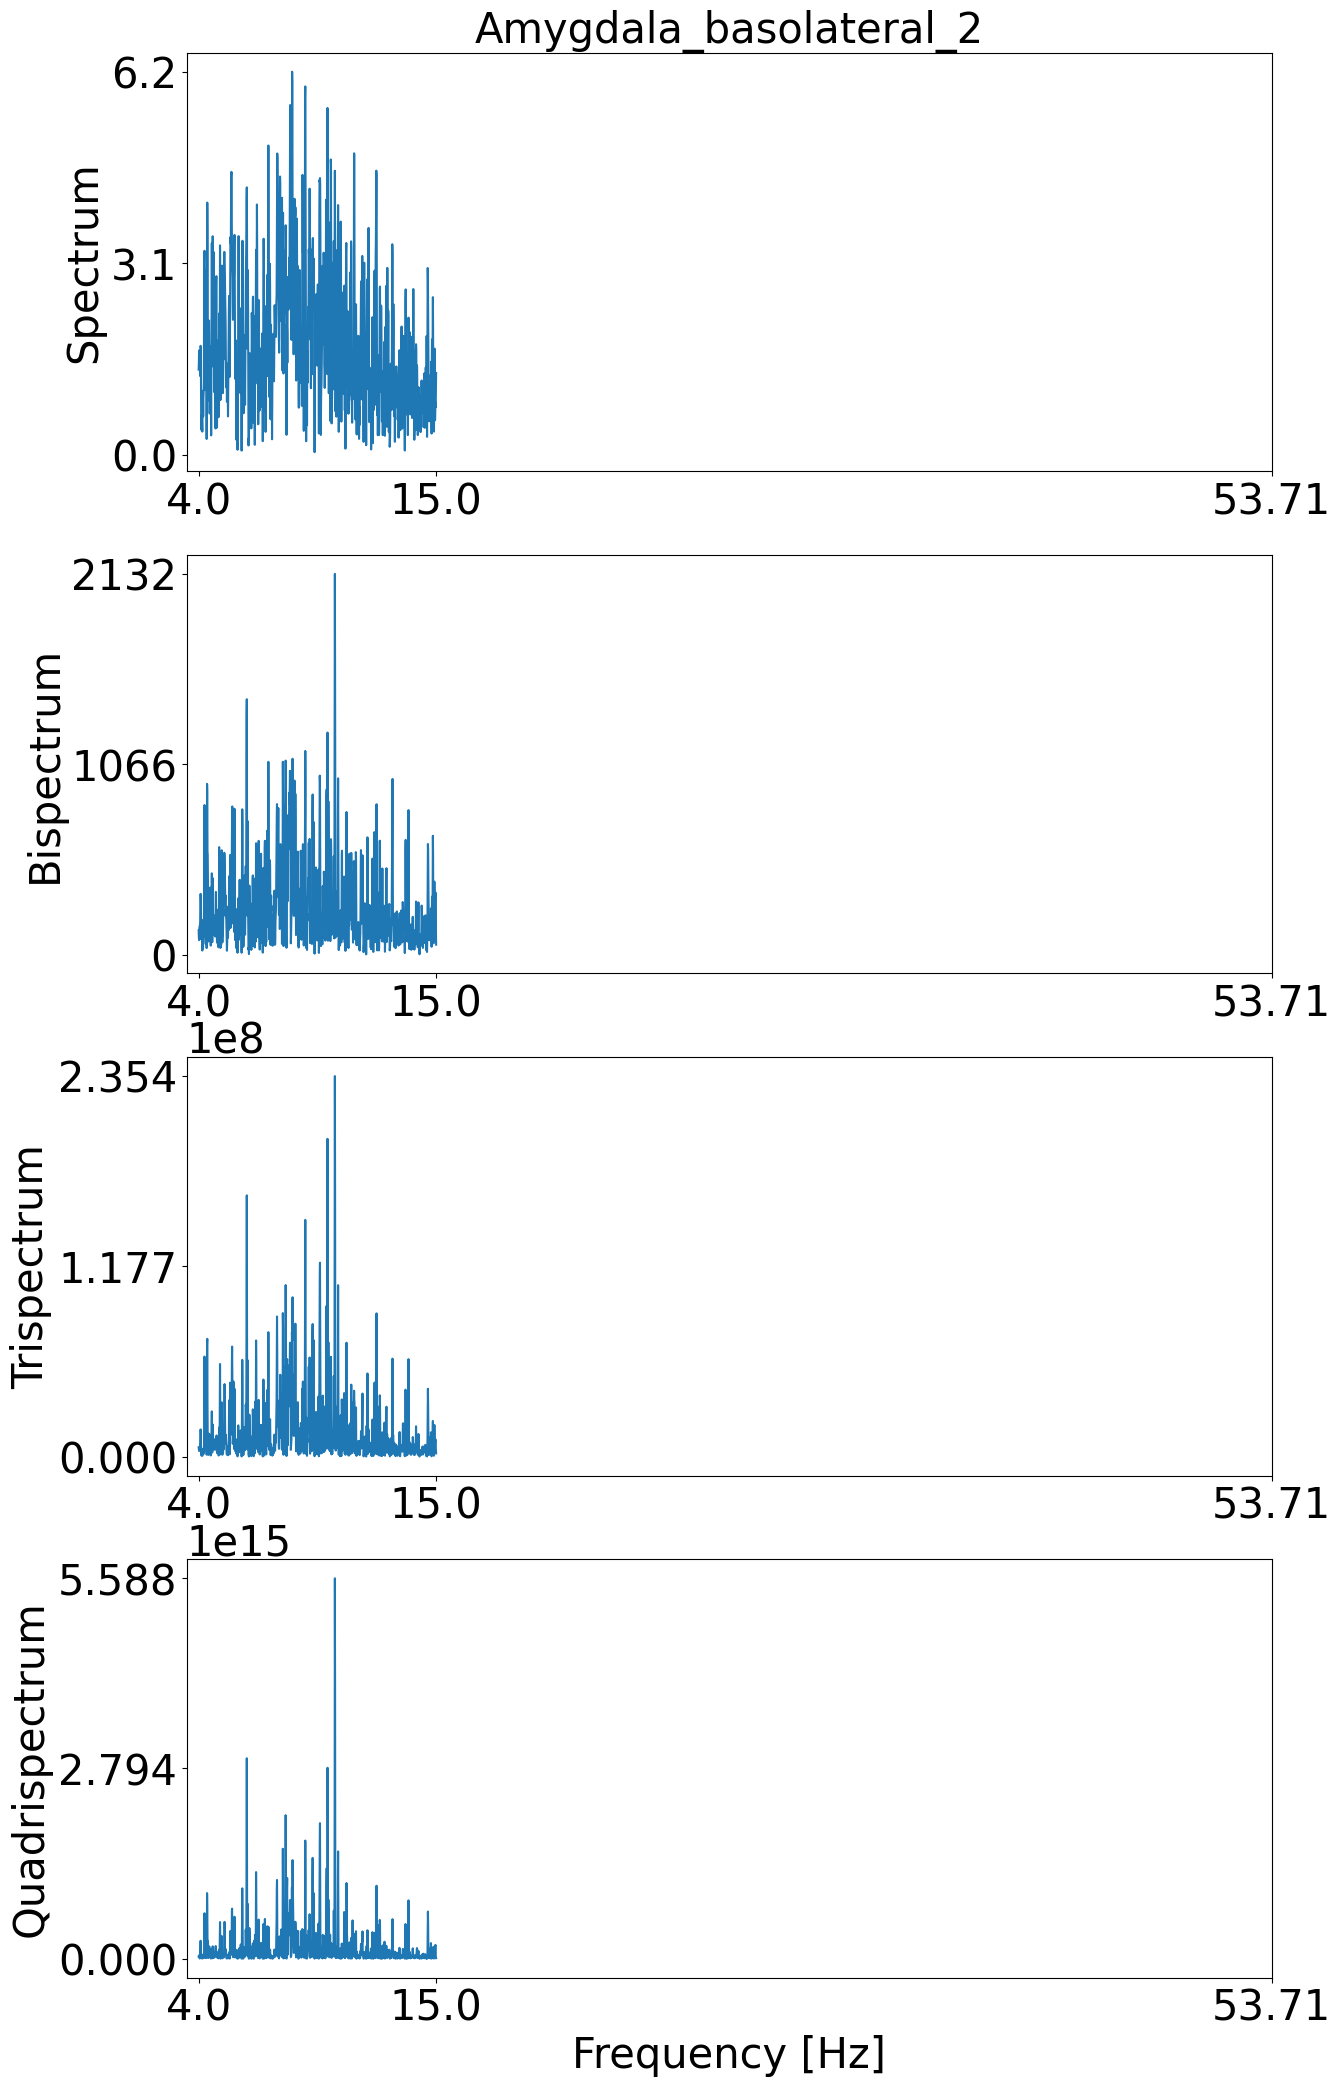

####################################################################################################


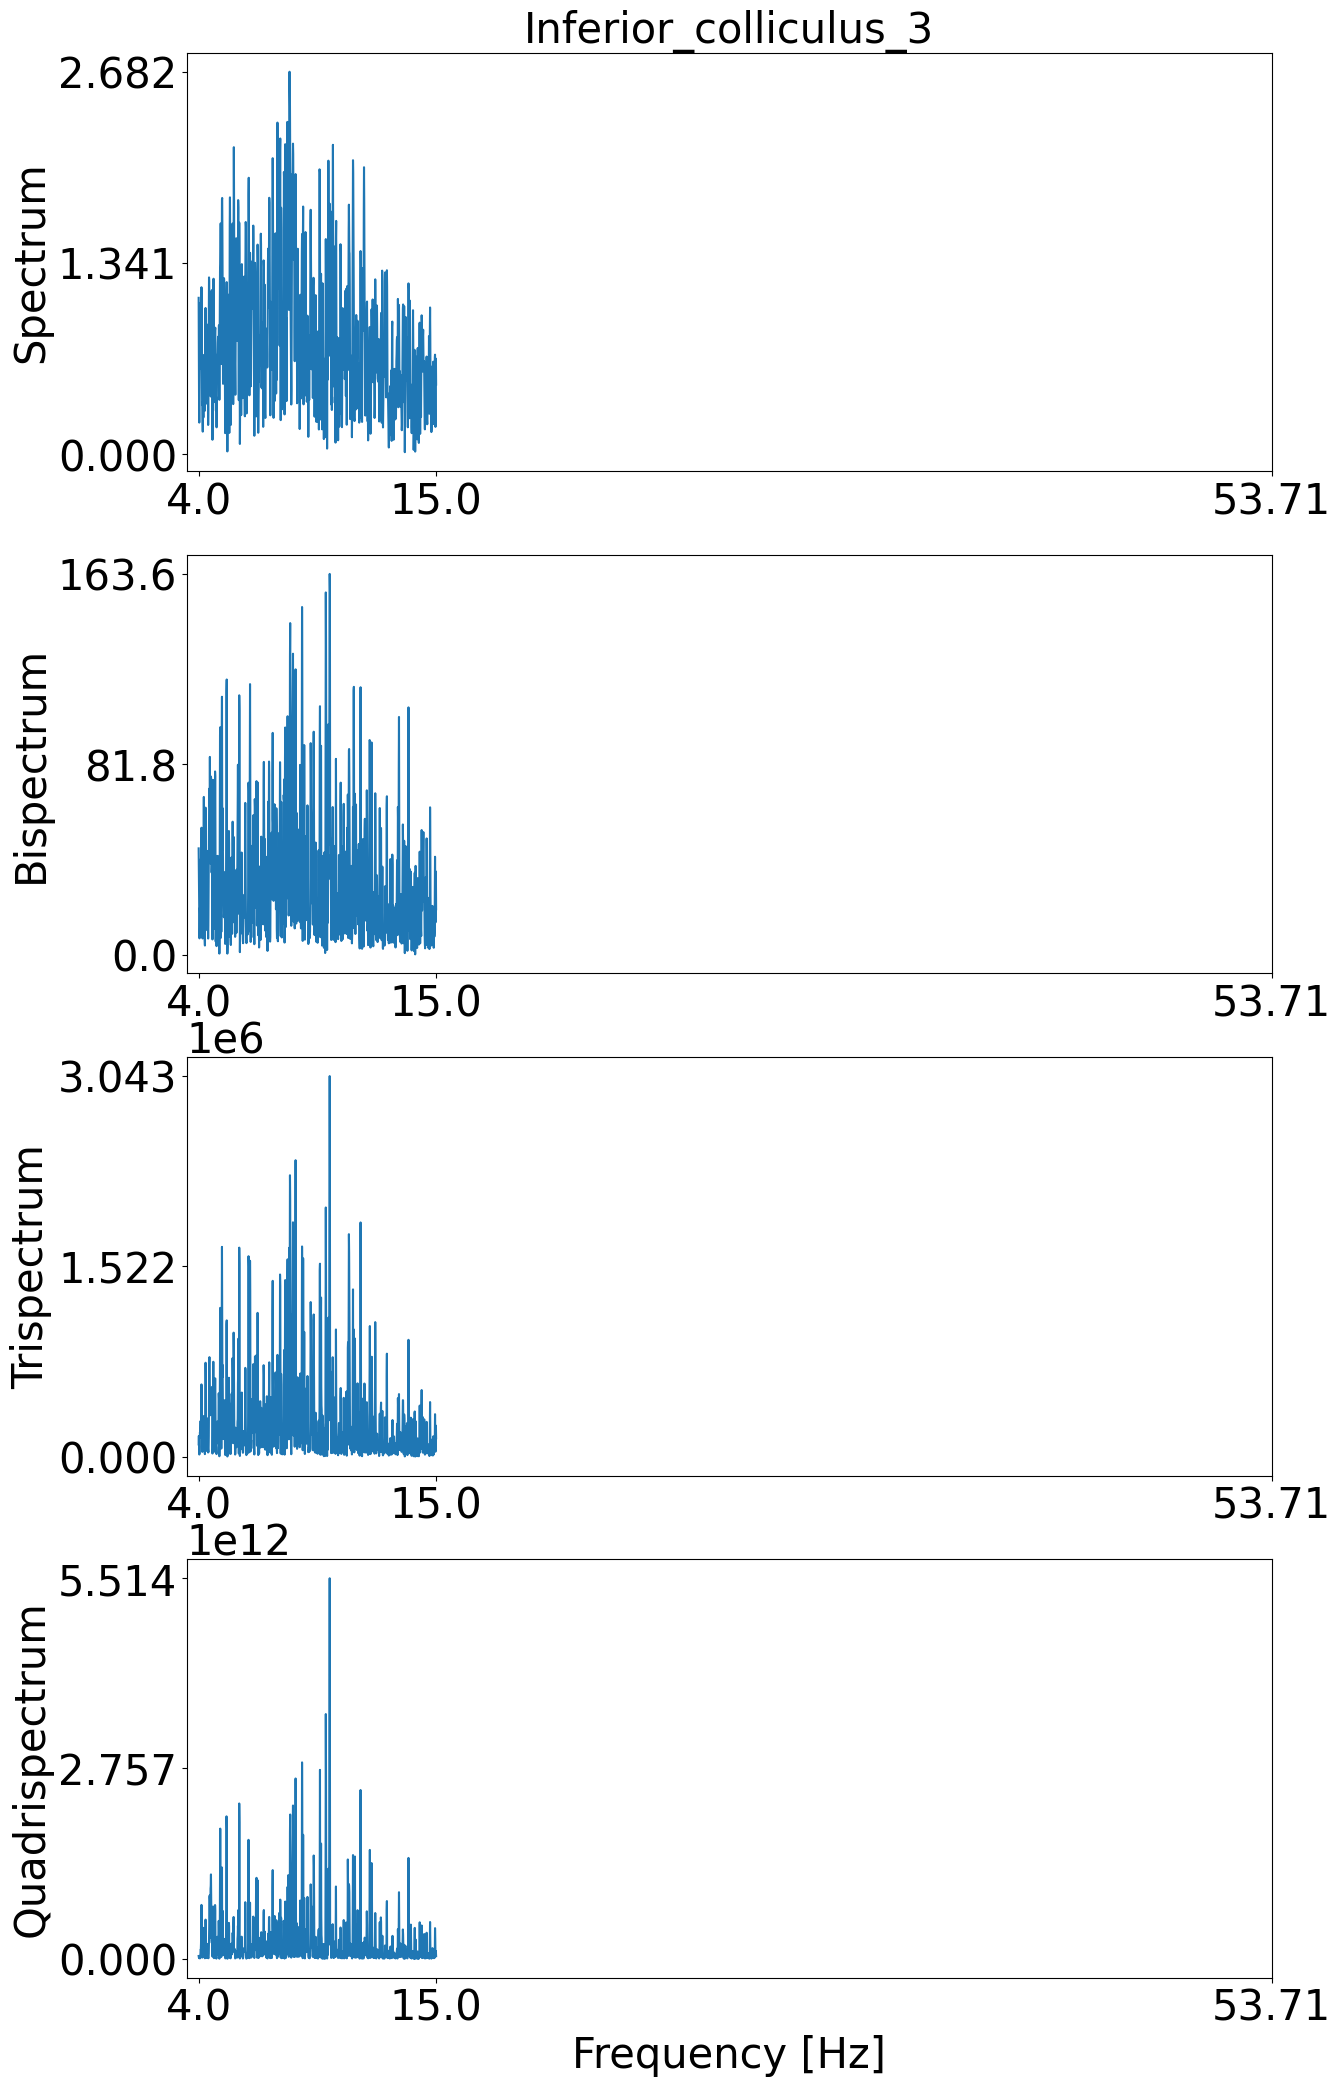

####################################################################################################


In [54]:
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)


freq_array = hosa_df.loc[(hosa_df.frequency>=(lim or [0, 100])[0])&(hosa_df.frequency<=(lim or [0, 100])[1]), "frequency"].to_numpy()

for column in columns[1:]:
    y_spectrum = hosa_df.loc[(hosa_df.frequency>=(lim or [4, 60])[0])&(hosa_df.frequency<=(lim or [4, 60])[1]), f"tds_amp_{column}"].to_numpy()
    y_bispectrum = hosa_df.loc[(hosa_df.frequency>=(lim or [4, 60])[0])&(hosa_df.frequency<=(lim or [4, 60])[1]), f"tdbs_amp_{column}"].to_numpy()
    y_trispectrum = hosa_df.loc[(hosa_df.frequency>=(lim or [4, 60])[0])&(hosa_df.frequency<=(lim or [4, 60])[1]), f"tdts_amp_{column}"].to_numpy()
    y_quadrispectrum = hosa_df.loc[(hosa_df.frequency>=(lim or [4, 60])[0])&(hosa_df.frequency<=(lim or [4, 60])[1]), f"tdqs_amp_{column}"].to_numpy()

    fig = plt.figure(figsize=(14,25))

    plt.subplot(411)
    plt.title(column)
    plt.plot(freq_array, y_spectrum)
    plt.ylabel("Spectrum")
    y_ticks = np.array([0, y_spectrum.max()/2, y_spectrum.max()])
    plt.yticks(y_ticks)
    plt.xticks(ticks=ticks, labels=labels)

    plt.subplot(412)
    plt.plot(freq_array, y_bispectrum)
    plt.ylabel("Bispectrum")
    y_ticks = np.array([0, y_bispectrum.max()/2, y_bispectrum.max()])
    plt.yticks(y_ticks)
    plt.xticks(ticks=ticks, labels=labels)

    plt.subplot(413)
    plt.plot(freq_array, y_trispectrum)
    plt.ylabel("Trispectrum")
    y_ticks = np.array([0, y_trispectrum.max()/2, y_trispectrum.max()])
    plt.yticks(y_ticks)
    plt.xticks(ticks=ticks, labels=labels)

    plt.subplot(414)
    plt.plot(freq_array, y_quadrispectrum)
    plt.ylabel("Quadrispectrum")
    y_ticks = np.array([0, y_quadrispectrum.max()/2, y_quadrispectrum.max()])
    plt.yticks(y_ticks)
    plt.xticks(ticks=ticks, labels=labels)

    plt.xlabel("Frequency [Hz]")
    plt.savefig(
        f"{'with_zoom'*zoom + 'without_zoom'*(not zoom)}/hosa_{id_file}_{id_results}_{column}_{'zoom'*(lim is not None)}.jpg",
        format="jpg",
        bbox_inches='tight', 
        dpi=150
    )

    plt.show()

    print(f"#"*100)

# Average TDHOSA

In [55]:
hosa_df: pd.DataFrame = pd.DataFrame()

for event_number in range(1, 5+1):
    id_results: str = f"event_{event_number}"
    path_files = f'{os.getcwd()}/hosa_{id_file}_{id_results}.csv'
    file_exists: bool = os.path.isfile(path_files)
    if not file_exists:
        raise FileNotFoundError(f"File {f'hosa_{id_file}_{id_results}.csv'} do not exists.")
    current_hosa_df = pd.read_csv(path_files)
    logger.success(f"HOSA loaded! {f'hosa_{id_file}_{id_results}.csv'}")

    hosa_df = pd.concat([hosa_df, current_hosa_df], axis=0)

2023-09-07 15:43:19.609 | SUCCESS  | __main__:<module>:10 - HOSA loaded! hosa_train_freezing_event_1.csv
2023-09-07 15:43:19.624 | SUCCESS  | __main__:<module>:10 - HOSA loaded! hosa_train_freezing_event_2.csv
2023-09-07 15:43:19.640 | SUCCESS  | __main__:<module>:10 - HOSA loaded! hosa_train_freezing_event_3.csv
2023-09-07 15:43:19.656 | SUCCESS  | __main__:<module>:10 - HOSA loaded! hosa_train_freezing_event_4.csv
2023-09-07 15:43:19.673 | SUCCESS  | __main__:<module>:10 - HOSA loaded! hosa_train_freezing_event_5.csv


In [56]:
hosa_df = hosa_df.groupby('frequency').mean().reset_index()

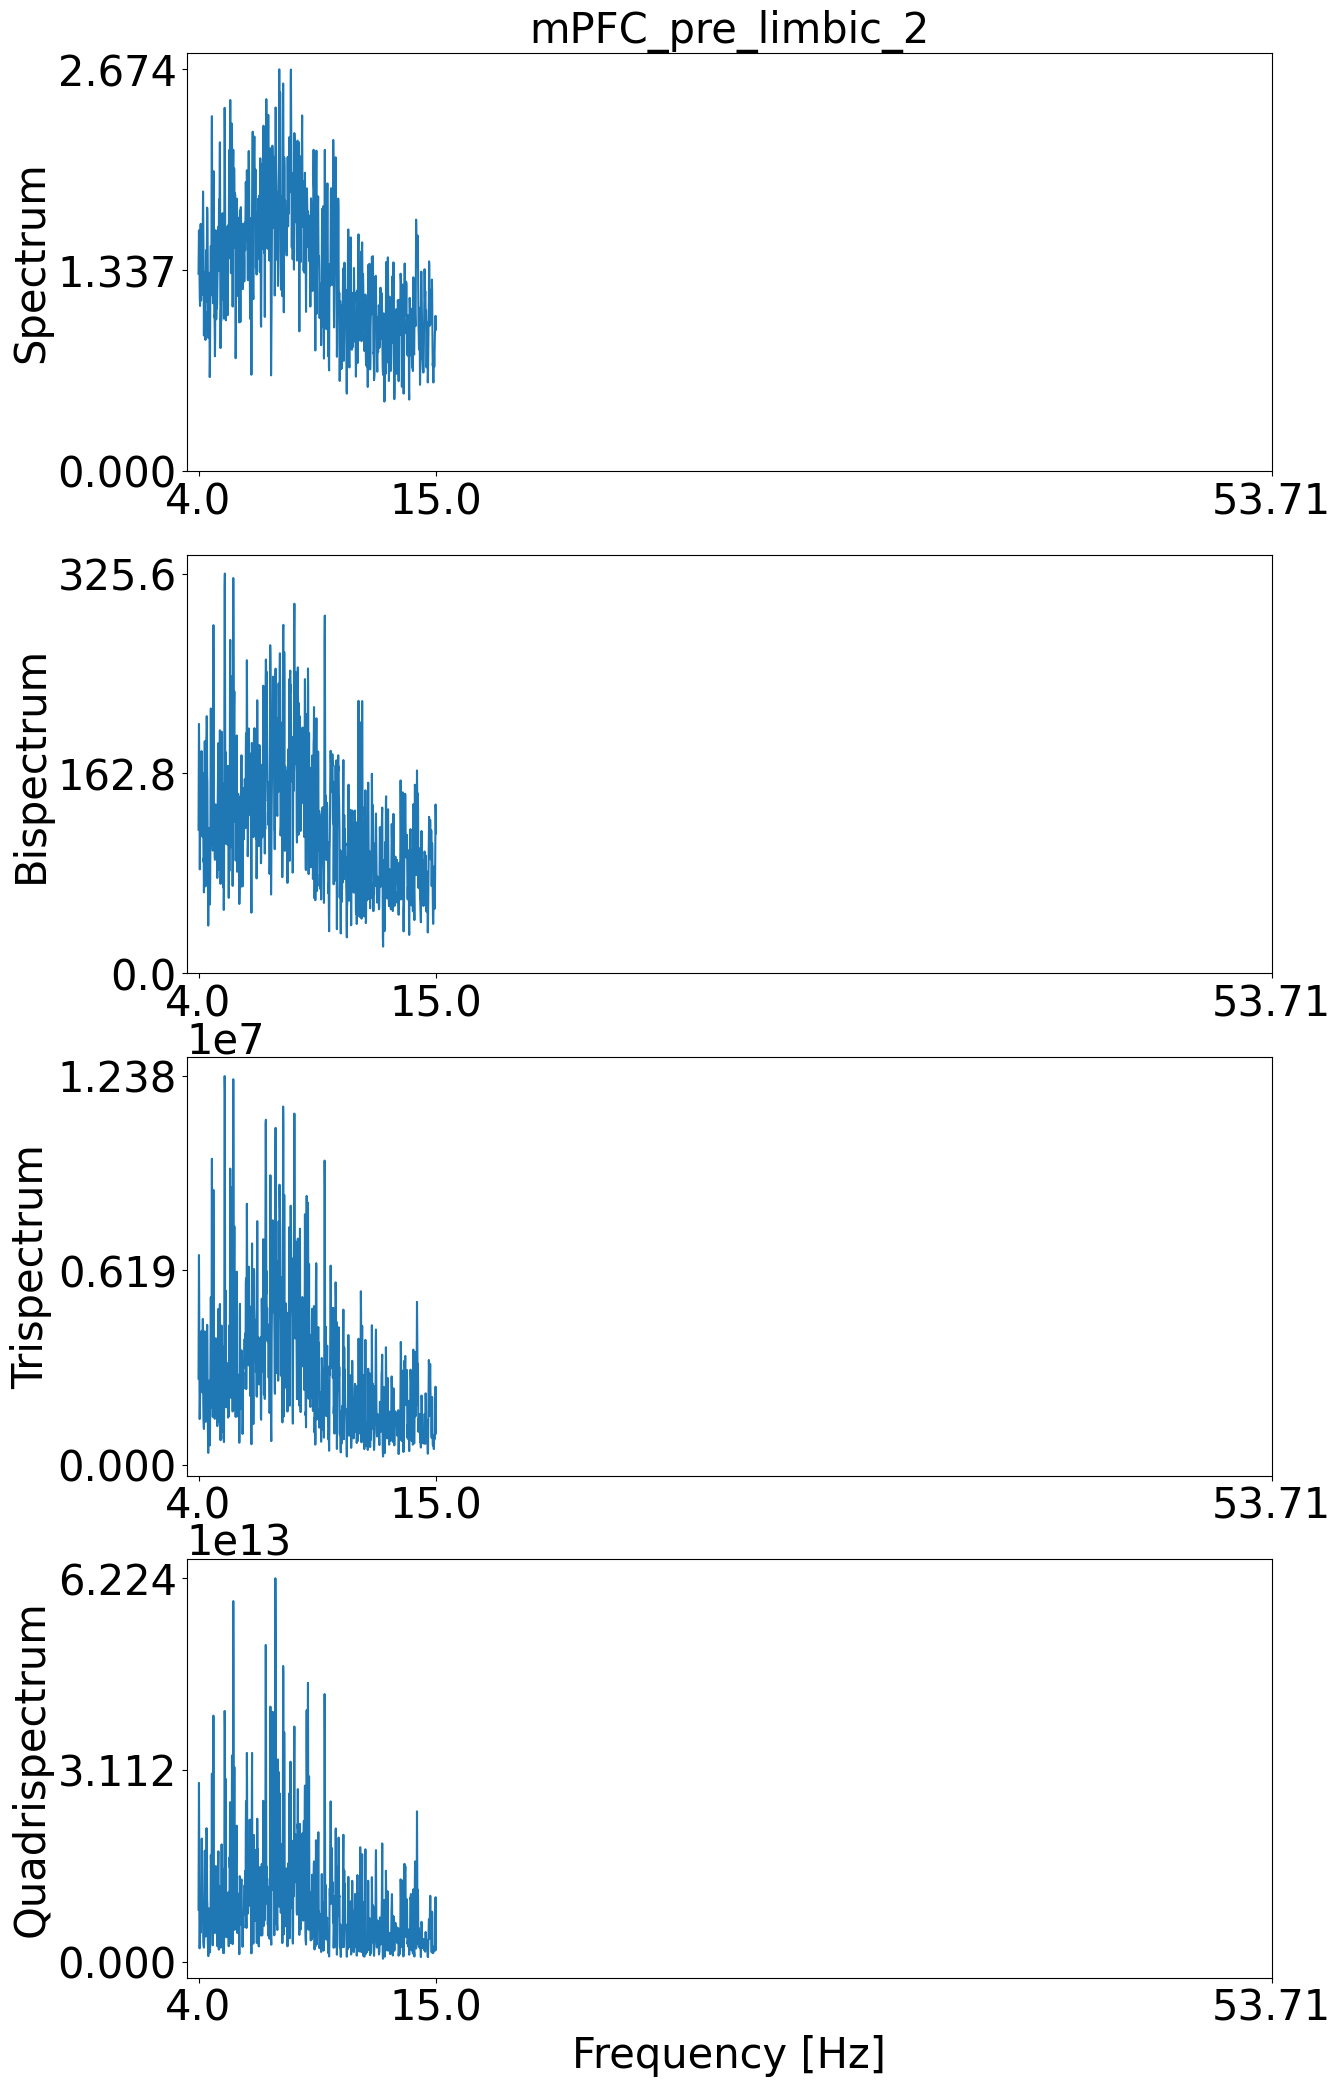

####################################################################################################


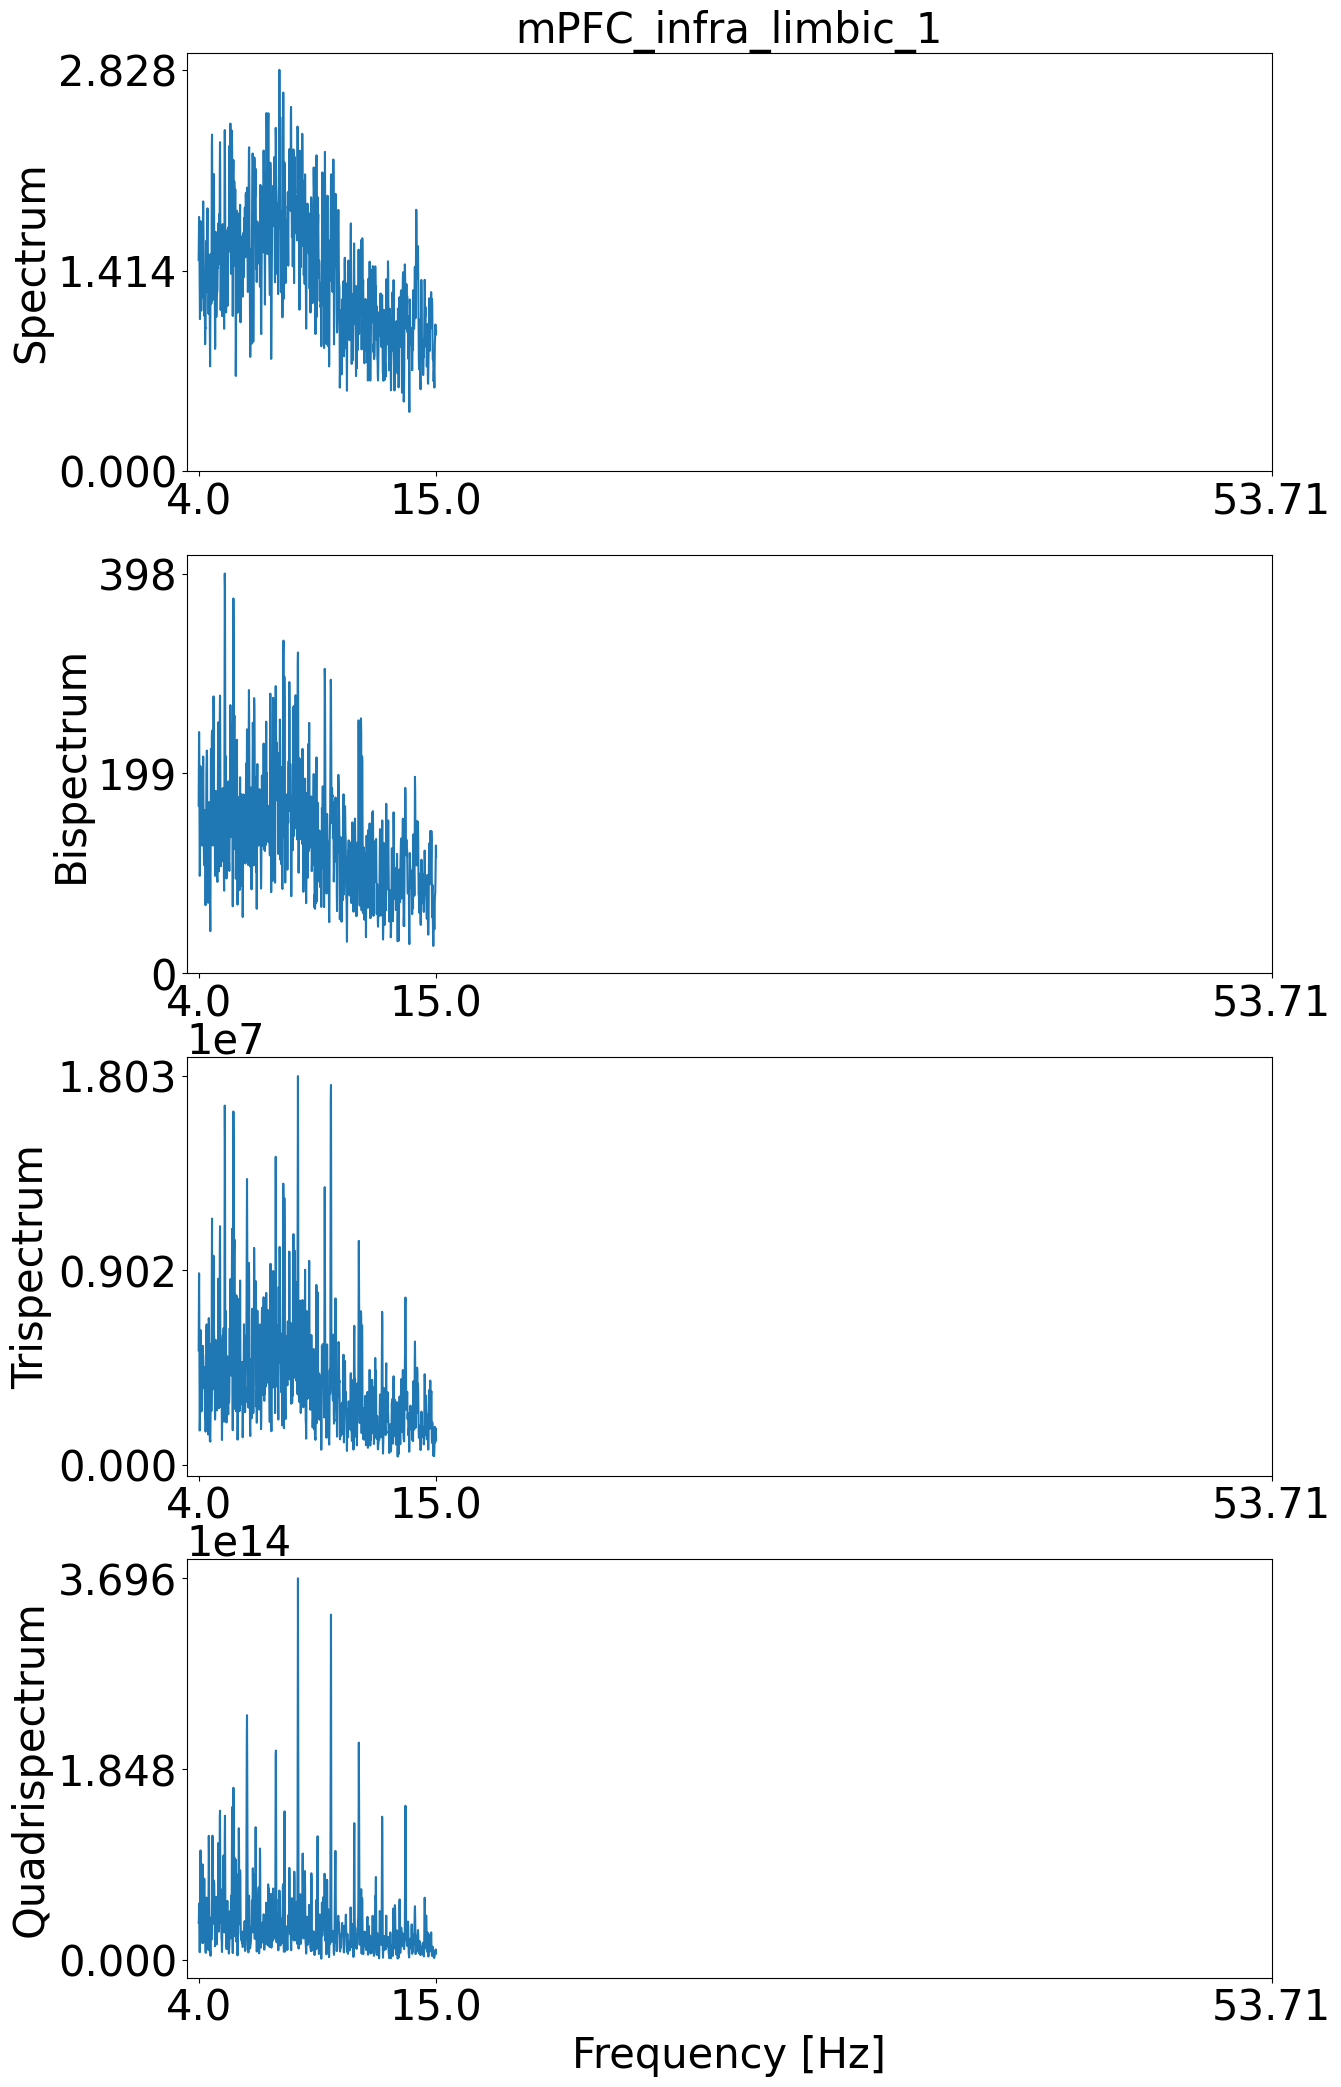

####################################################################################################


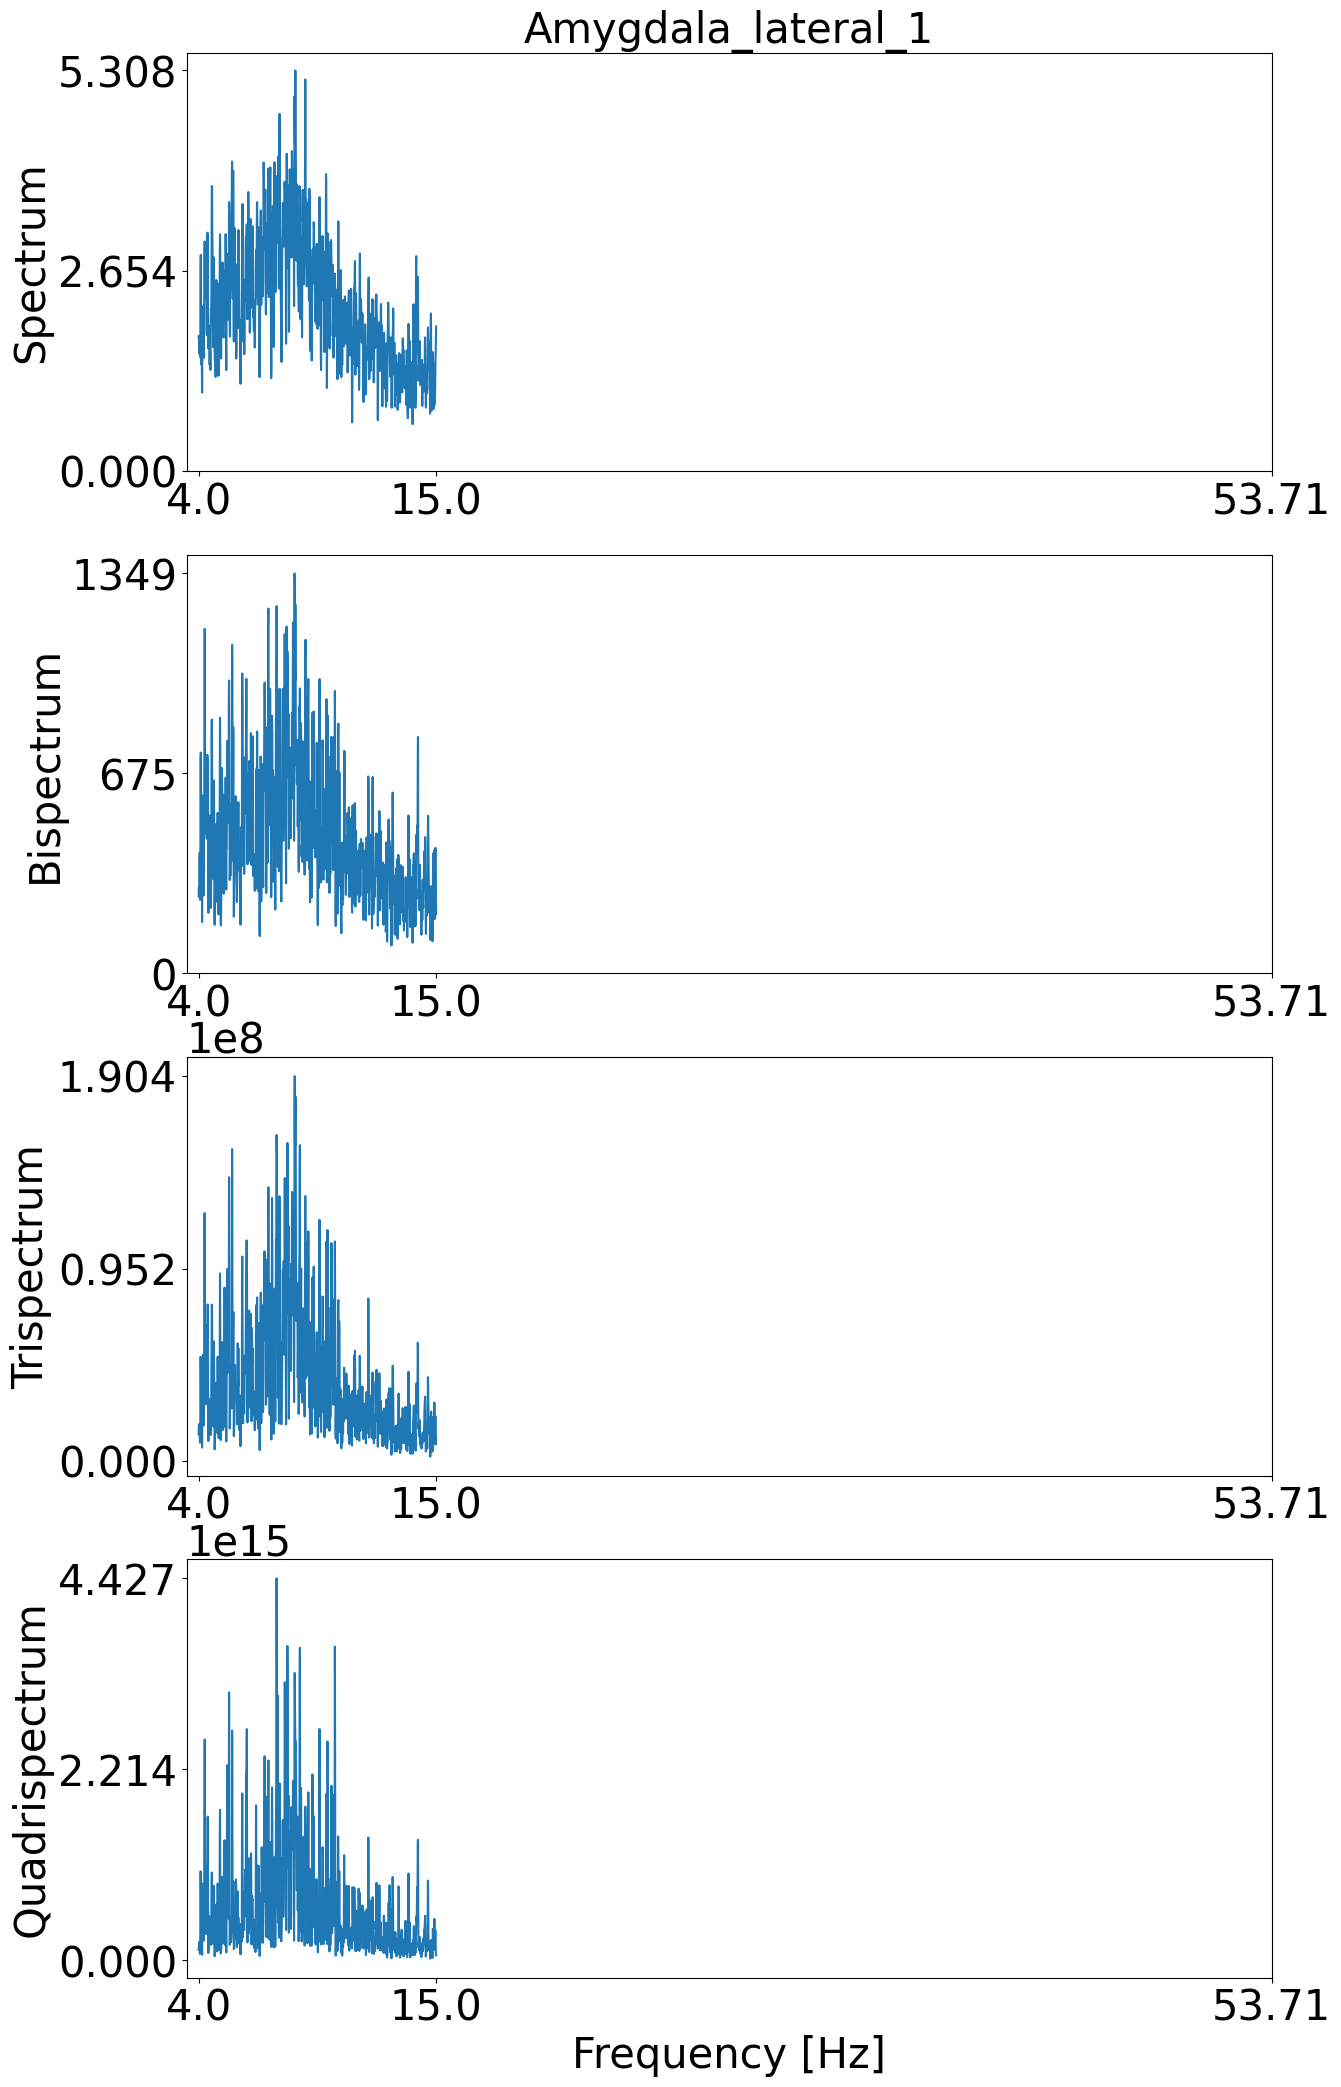

####################################################################################################


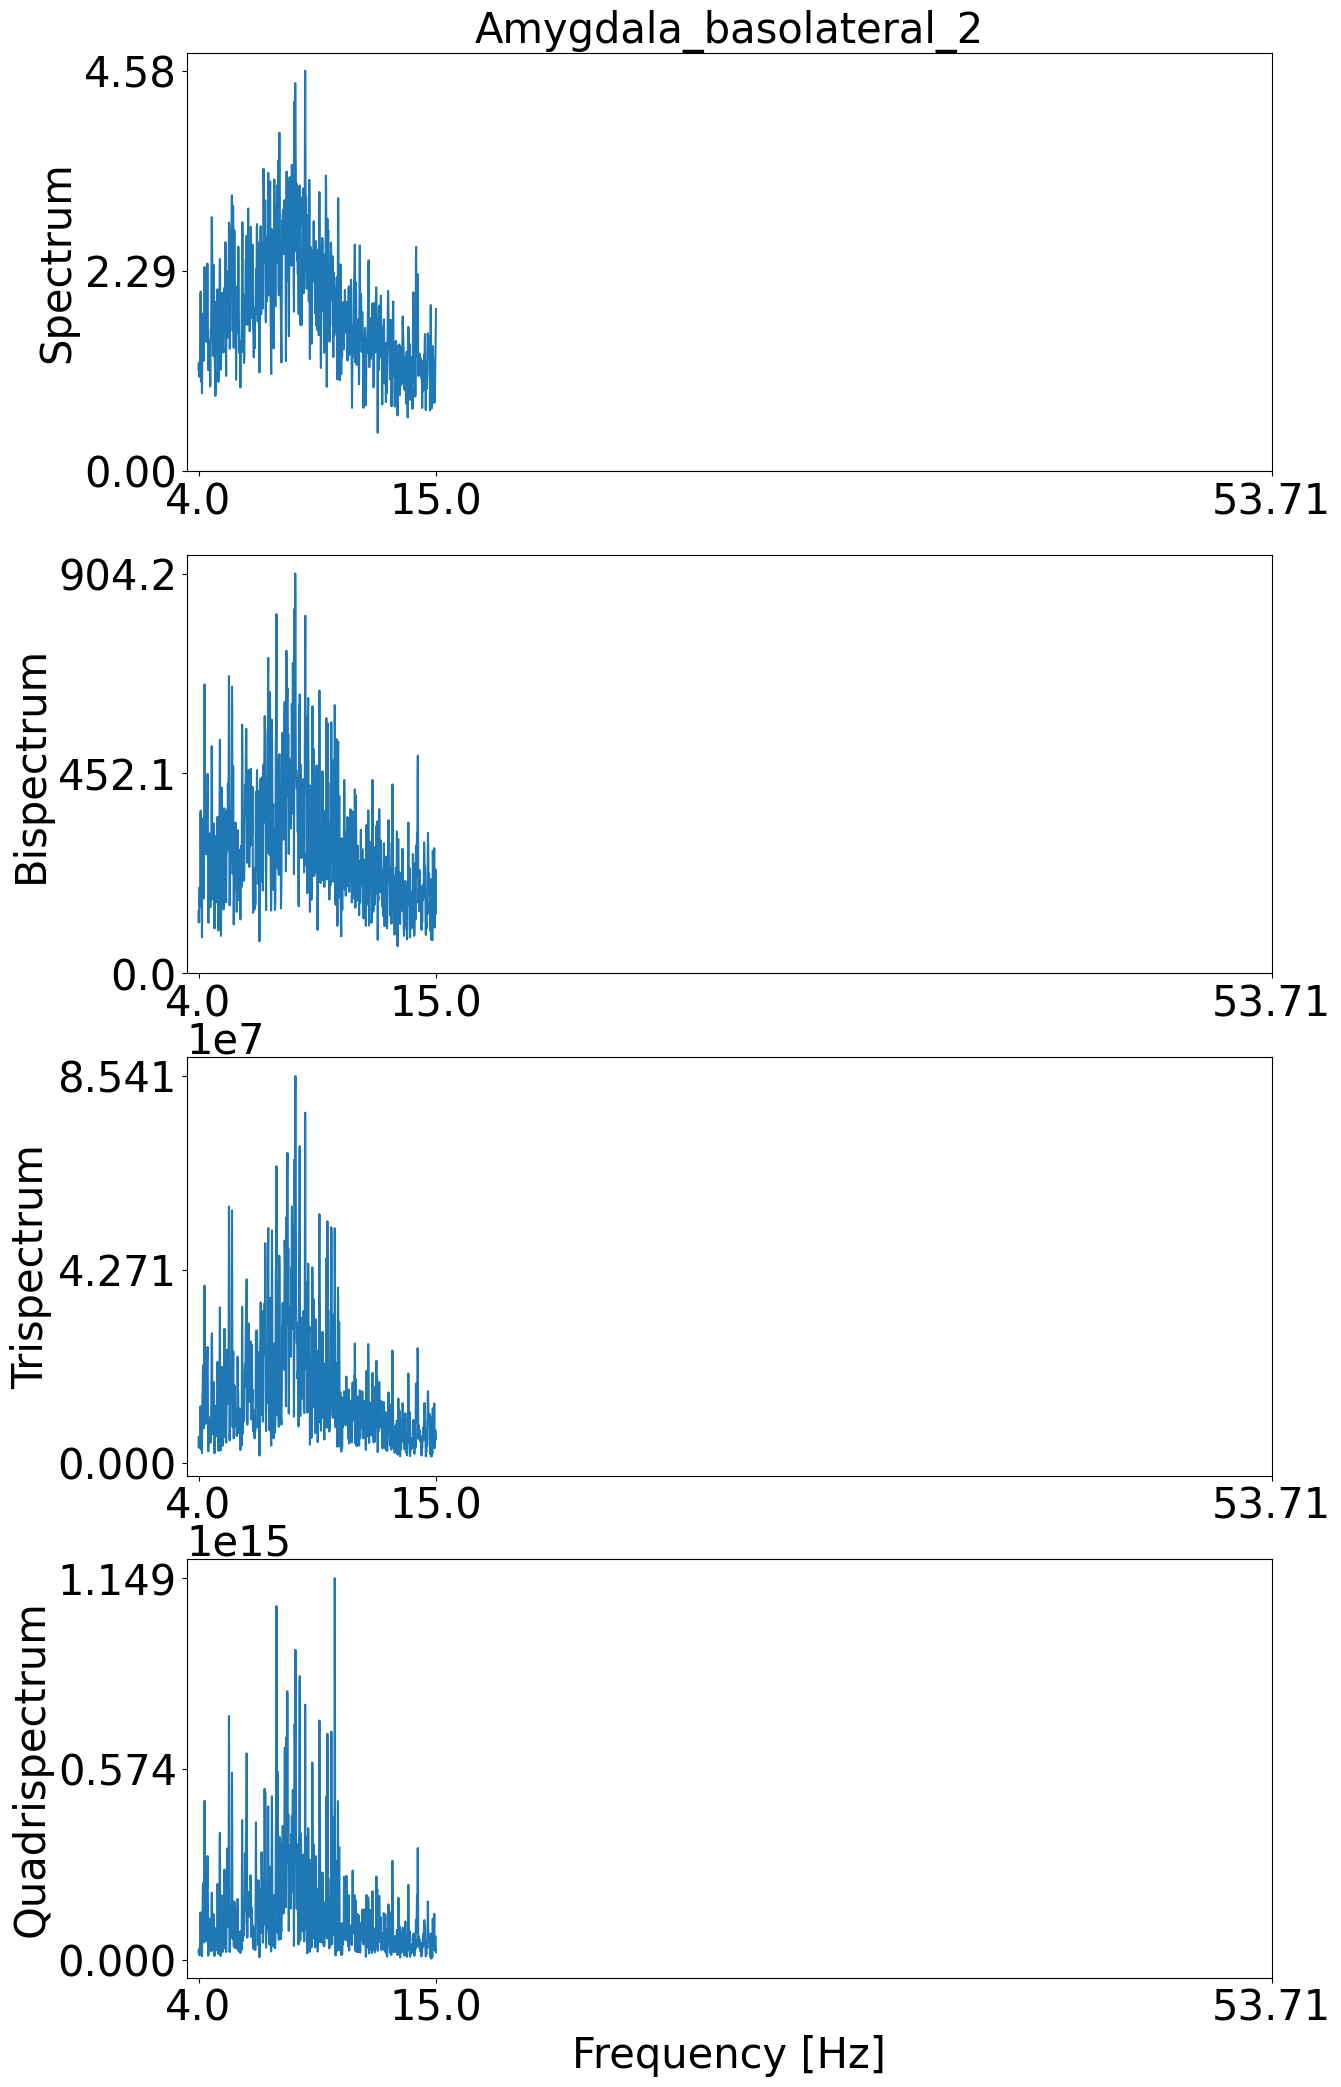

####################################################################################################


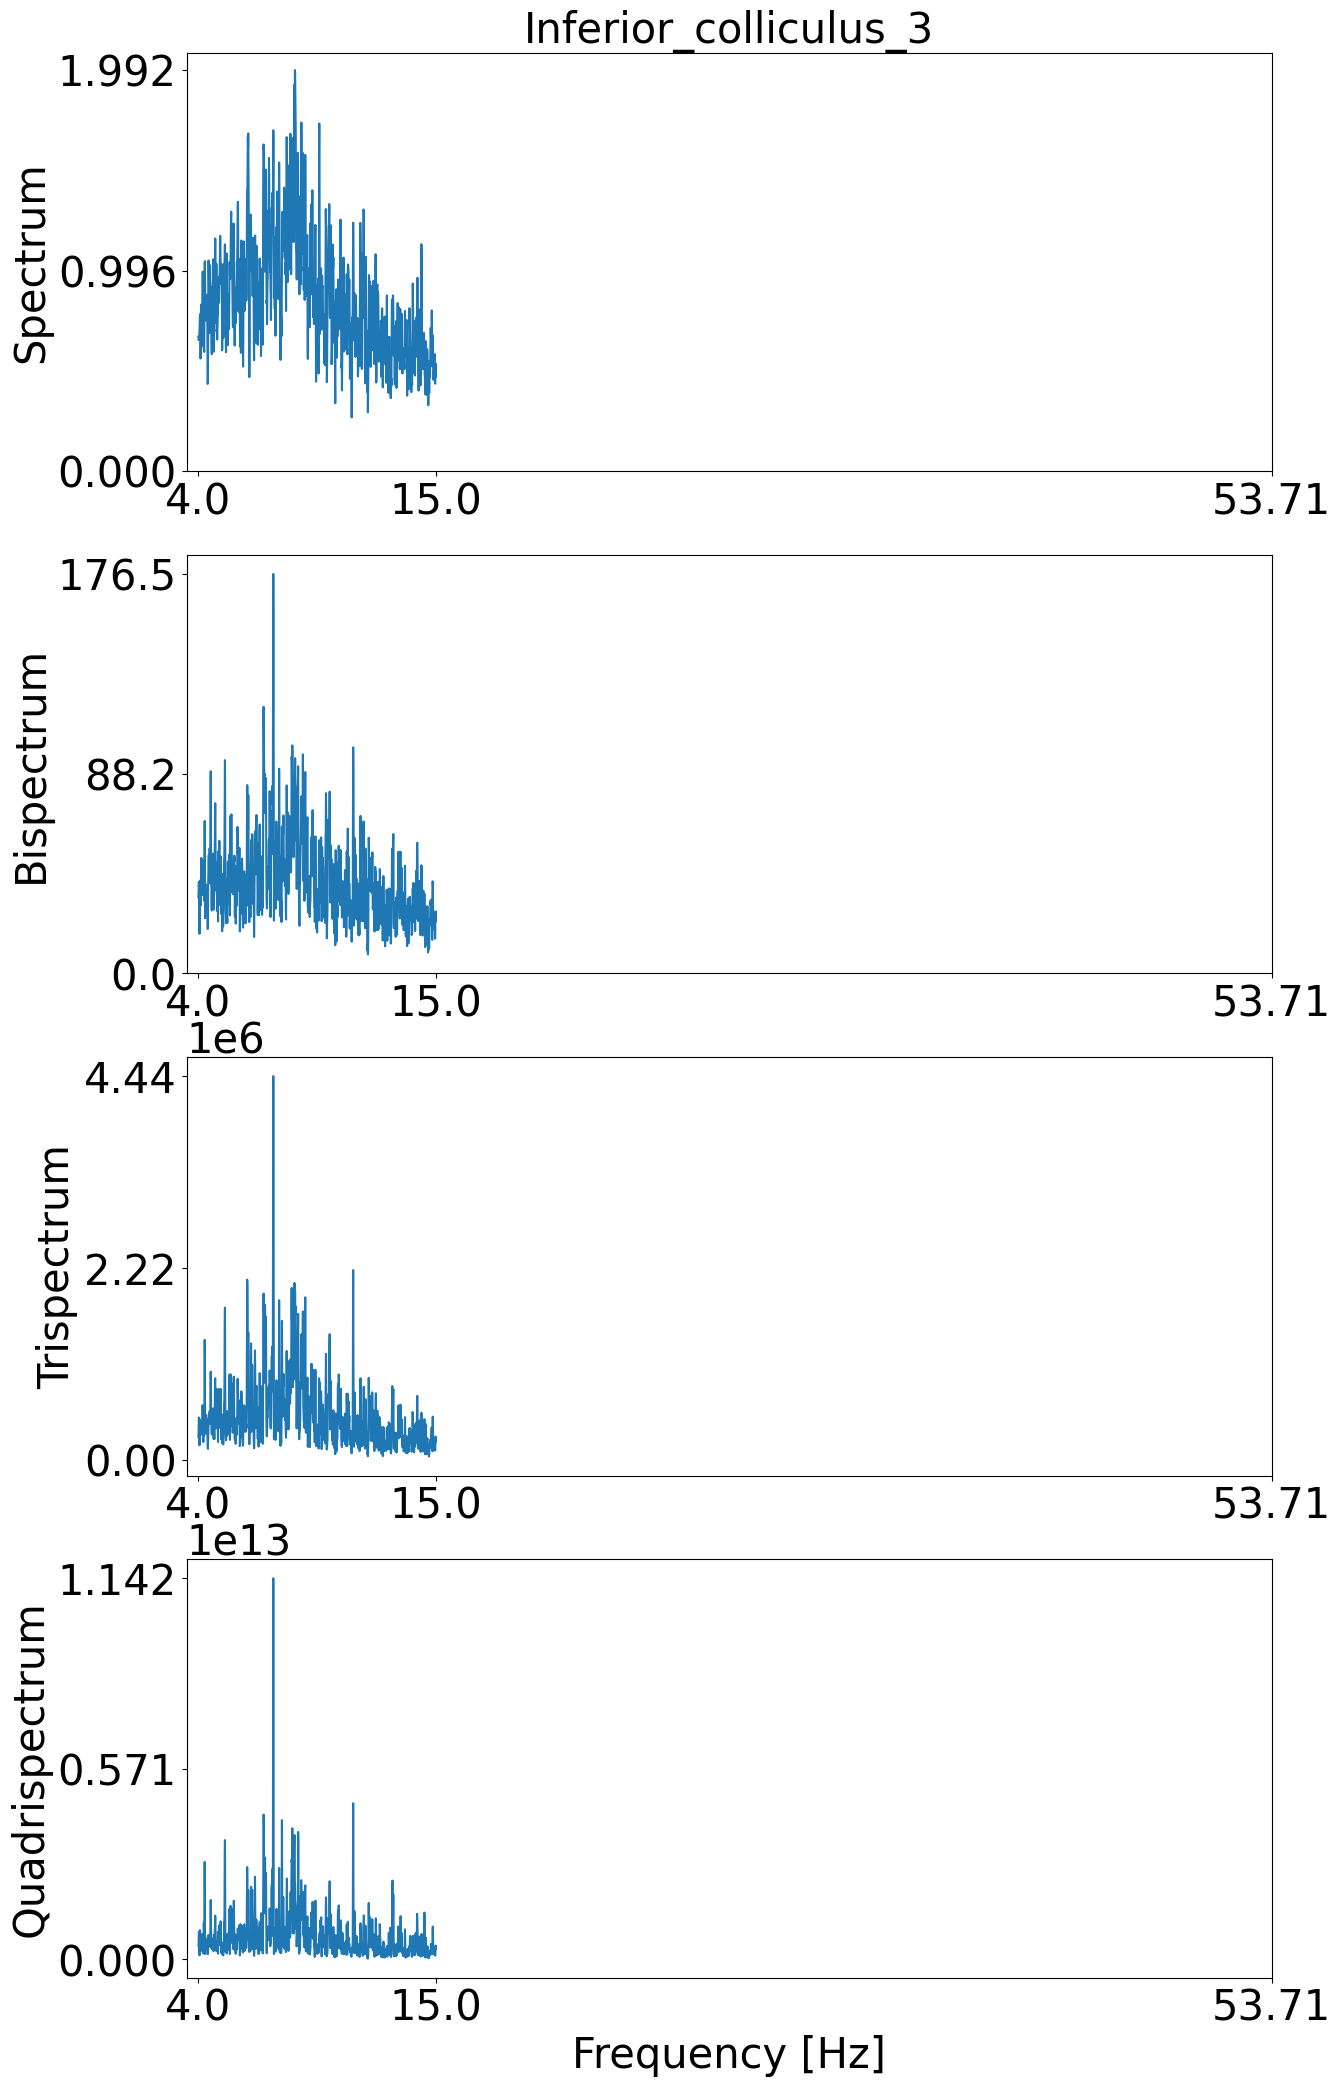

####################################################################################################


In [57]:
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)


freq_array = hosa_df.loc[(hosa_df.frequency>=(lim or [0, 100])[0])&(hosa_df.frequency<=(lim or [0, 100])[1]), "frequency"].to_numpy()

for column in columns[1:]:
    y_spectrum = hosa_df.loc[(hosa_df.frequency>=(lim or [4, 60])[0])&(hosa_df.frequency<=(lim or [4, 60])[1]), f"tds_amp_{column}"].to_numpy()
    y_bispectrum = hosa_df.loc[(hosa_df.frequency>=(lim or [4, 60])[0])&(hosa_df.frequency<=(lim or [4, 60])[1]), f"tdbs_amp_{column}"].to_numpy()
    y_trispectrum = hosa_df.loc[(hosa_df.frequency>=(lim or [4, 60])[0])&(hosa_df.frequency<=(lim or [4, 60])[1]), f"tdts_amp_{column}"].to_numpy()
    y_quadrispectrum = hosa_df.loc[(hosa_df.frequency>=(lim or [4, 60])[0])&(hosa_df.frequency<=(lim or [4, 60])[1]), f"tdqs_amp_{column}"].to_numpy()

    fig = plt.figure(figsize=(14,25))

    plt.subplot(411)
    plt.title(column)
    plt.plot(freq_array, y_spectrum)
    plt.ylabel("Spectrum")
    y_ticks = np.array([0, y_spectrum.max()/2, y_spectrum.max()])
    plt.yticks(y_ticks)
    plt.xticks(ticks=ticks, labels=labels)

    plt.subplot(412)
    plt.plot(freq_array, y_bispectrum)
    plt.ylabel("Bispectrum")
    y_ticks = np.array([0, y_bispectrum.max()/2, y_bispectrum.max()])
    plt.yticks(y_ticks)
    plt.xticks(ticks=ticks, labels=labels)

    plt.subplot(413)
    plt.plot(freq_array, y_trispectrum)
    plt.ylabel("Trispectrum")
    y_ticks = np.array([0, y_trispectrum.max()/2, y_trispectrum.max()])
    plt.yticks(y_ticks)
    plt.xticks(ticks=ticks, labels=labels)

    plt.subplot(414)
    plt.plot(freq_array, y_quadrispectrum)
    plt.ylabel("Quadrispectrum")
    y_ticks = np.array([0, y_quadrispectrum.max()/2, y_quadrispectrum.max()])
    plt.yticks(y_ticks)
    plt.xticks(ticks=ticks, labels=labels)

    plt.xlabel("Frequency [Hz]")
    plt.savefig(
        f"{'with_zoom'*zoom + 'without_zoom'*(not zoom)}/hosa_{id_file}_{column}_{'zoom'*(lim is not None)}_mean.jpg",
        format="jpg",
        bbox_inches='tight', 
        dpi=150
    )

    plt.show()

    print(f"#"*100)